In [46]:
!pip install ucimlrepo numpy pandas matplotlib scikit-learn

# ***Wine Dataset Fetching***

In [47]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine = fetch_ucirepo(id=109)

In [48]:
import pandas as pd
import numpy as np

# Convert features and targets into DataFrames
wine_features = pd.DataFrame(wine.data.features, columns=wine.data.feature_names)
wine_targets = pd.DataFrame(wine.data.targets, columns=wine.data.target_names)

# Optionally, combine features and target into a single DataFrame
wine_dataset = pd.concat([wine_features, wine_targets], axis=1)
wine_dataset.head()

Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
0    14.23       1.71  2.43               15.6        127           2.80   
1    13.20       1.78  2.14               11.2        100           2.65   
2    13.16       2.36  2.67               18.6        101           2.80   
3    14.37       1.95  2.50               16.8        113           3.85   
4    13.24       2.59  2.87               21.0        118           2.80   

   Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   0D280_0D315_of_diluted_wines  Proline  class  
0                          3.92     1065      1  
1                          3.40     1050      1  
2                          3.17     1185      1  
3                          3.45     1480      1  
4                          2.93      735      1

In [49]:
#checking for null value
wine_dataset.isnull().sum()

Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
class                           0
dtype: int64

# ***SVC Classifier***

In [50]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, f1_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def svc_classifier(X, Y, kernels=['linear', 'poly', 'rbf', 'sigmoid'], test_sizes=[0.2, 0.3, 0.4, 0.5], apply_pca=False, n_components=10):
    """
    SVC classifier with various kernels, testing across different train-test splits.
    Optionally applies PCA for dimensionality reduction.
    """

    results = {}
    class_names = np.unique(Y)

    for kernel in kernels:
        accuracies = []
        for test_size in test_sizes:
            print(f"Running SVC with kernel '{kernel}' and test size {test_size}...")

            # Split the data
            X_train, X_test, Y_train, Y_test = train_test_split(
                X, Y, test_size=test_size, random_state=40, stratify=Y
            )

            # Apply PCA if enabled
            if apply_pca:
                pca = PCA(n_components=n_components)
                X_train = pca.fit_transform(X_train)
                X_test = pca.transform(X_test)

            # Train SVC
            svc = SVC(kernel=kernel, C=1, probability=True)
            svc.fit(X_train, Y_train)
            Y_pred = svc.predict(X_test)

            # Metrics
            accuracy = accuracy_score(Y_test, Y_pred)
            precision = precision_score(Y_test, Y_pred, average='weighted')
            recall = recall_score(Y_test, Y_pred, average='weighted')
            f1 = f1_score(Y_test, Y_pred, average='weighted')
            cm = confusion_matrix(Y_test, Y_pred)
            class_report = classification_report(Y_test, Y_pred)

            # Store results
            results[(kernel, test_size)] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'confusion_matrix': cm,
                'classification_report': class_report
            }

            # Print metrics
            print("=========================================================================================")
            print(f"Kernel: {kernel}, Test Size: {test_size}")
            print(f"Accuracy:  {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall:    {recall:.4f}")
            print(f"F1-Score:  {f1:.4f}")
            print("Confusion Matrix:")
            print(cm)
            print(f"Classification Report:\n{class_report}")
            print("----------------------------------------------------------------------------------------------")

            # Confusion matrix heatmap
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                        xticklabels=class_names, yticklabels=class_names)
            plt.title(f'Confusion Matrix for {kernel} Kernel (Test Size {test_size})')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

            accuracies.append(accuracy)

            # ROC–AUC curve (per-split)
            y_test_bin = label_binarize(Y_test, classes=class_names)
            model_bin = OneVsRestClassifier(SVC(kernel=kernel, probability=True))
            model_bin.fit(X_train, Y_train)
            y_score = model_bin.decision_function(X_test)

            plt.figure()
            for i in range(len(class_names)):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve for {kernel} Kernel (Test Size {test_size})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc="lower right")
            plt.show()

        # Accuracy bar graph for this kernel across splits
        plt.figure(figsize=(8, 6))
        plt.bar([f'{int((1-size)*100)}:{int(size*100)}' for size in test_sizes],
                accuracies, align='center', color='yellow', edgecolor='black')
        plt.title(f'Accuracy for {kernel} Kernel Across Splits')
        plt.xlabel('Train:Test Split')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.0)
        plt.show()

        print("=========================================================================================")

    return results


Running SVC with kernel 'linear' and test size 0.2...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: linear, Test Size: 0.2
Accuracy:  0.9167
Precision: 0.9225
Recall:    0.9167
F1-Score:  0.9165
Confusion Matrix:
[[12  0  0]
 [ 2 12  0]
 [ 0  1  9]]
Classification Report:
              precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       0.92      0.86      0.89        14
           3       1.00      0.90      0.95        10

    accuracy                           0.92        36
   macro avg       0.93      0.92      0.92        36
weighted avg       0.92      0.92      0.92        36

----------------------------------------------------------------------------------------------


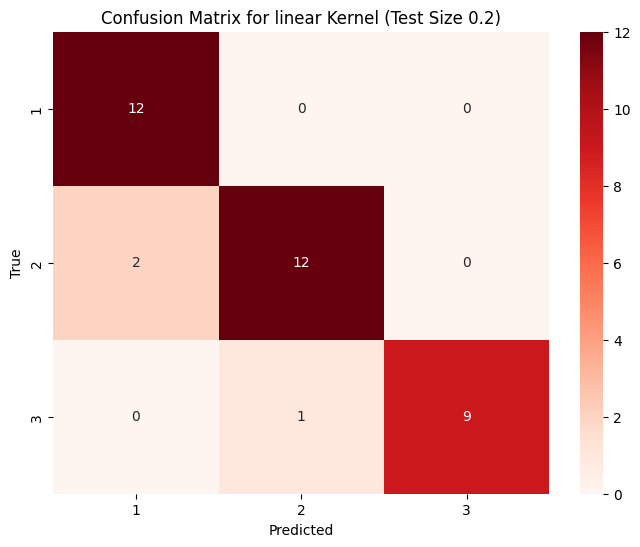

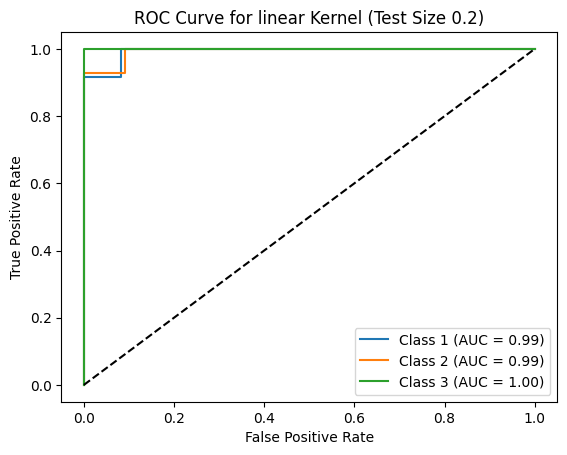

Running SVC with kernel 'linear' and test size 0.3...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: linear, Test Size: 0.3
Accuracy:  0.9259
Precision: 0.9296
Recall:    0.9259
F1-Score:  0.9256
Confusion Matrix:
[[18  0  0]
 [ 2 19  0]
 [ 0  2 13]]
Classification Report:
              precision    recall  f1-score   support

           1       0.90      1.00      0.95        18
           2       0.90      0.90      0.90        21
           3       1.00      0.87      0.93        15

    accuracy                           0.93        54
   macro avg       0.93      0.92      0.93        54
weighted avg       0.93      0.93      0.93        54

----------------------------------------------------------------------------------------------


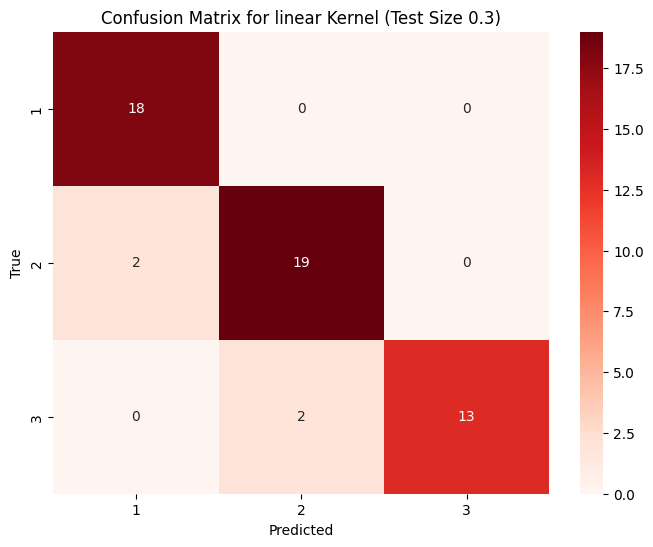

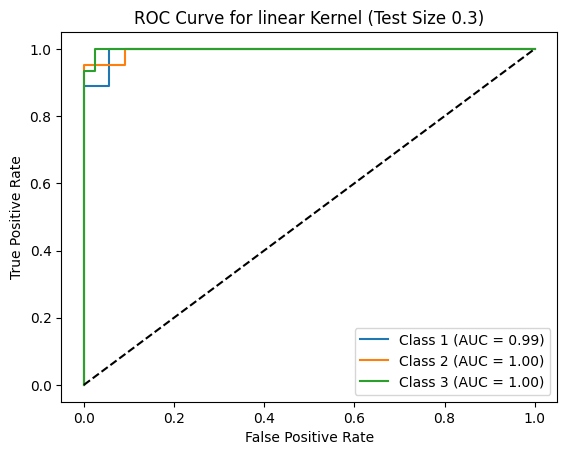

Running SVC with kernel 'linear' and test size 0.4...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: linear, Test Size: 0.4
Accuracy:  0.9444
Precision: 0.9466
Recall:    0.9444
F1-Score:  0.9442
Confusion Matrix:
[[24  0  0]
 [ 2 27  0]
 [ 0  2 17]]
Classification Report:
              precision    recall  f1-score   support

           1       0.92      1.00      0.96        24
           2       0.93      0.93      0.93        29
           3       1.00      0.89      0.94        19

    accuracy                           0.94        72
   macro avg       0.95      0.94      0.95        72
weighted avg       0.95      0.94      0.94        72

----------------------------------------------------------------------------------------------


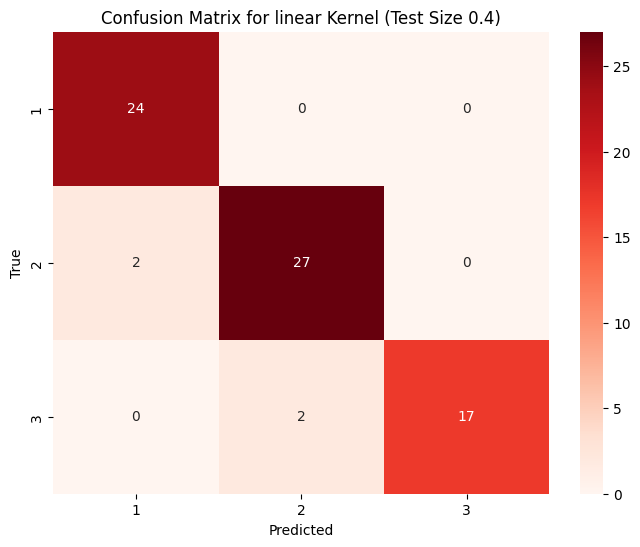

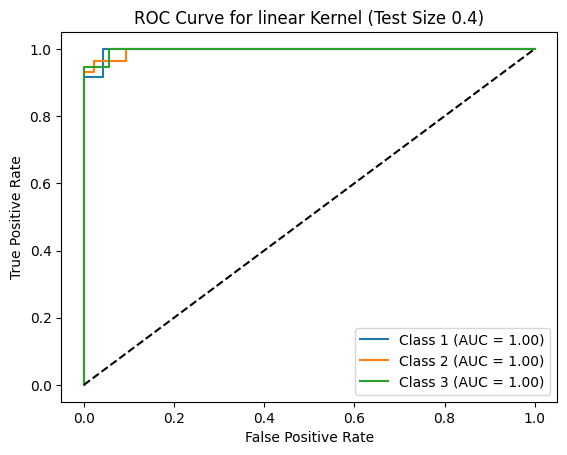

Running SVC with kernel 'linear' and test size 0.5...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: linear, Test Size: 0.5
Accuracy:  0.9551
Precision: 0.9565
Recall:    0.9551
F1-Score:  0.9549
Confusion Matrix:
[[30  0  0]
 [ 2 33  0]
 [ 0  2 22]]
Classification Report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        30
           2       0.94      0.94      0.94        35
           3       1.00      0.92      0.96        24

    accuracy                           0.96        89
   macro avg       0.96      0.95      0.96        89
weighted avg       0.96      0.96      0.95        89

----------------------------------------------------------------------------------------------


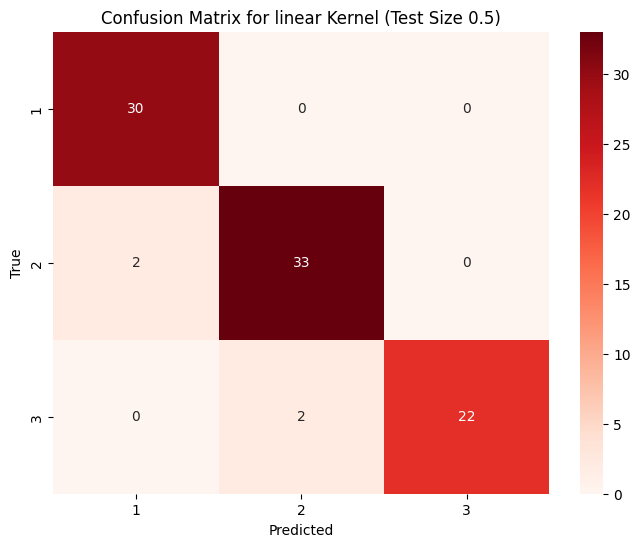

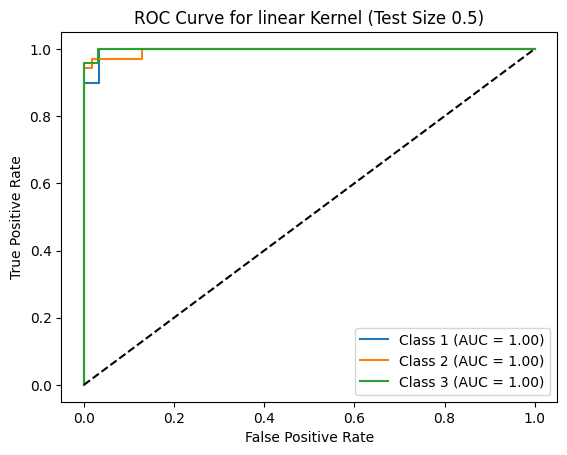

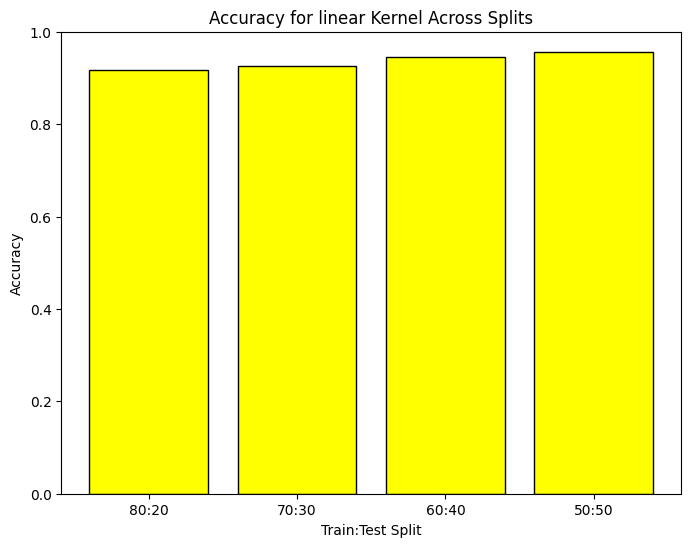

Running SVC with kernel 'poly' and test size 0.2...
Kernel: poly, Test Size: 0.2
Accuracy:  0.7222
Precision: 0.7968
Recall:    0.7222
F1-Score:  0.6748
Confusion Matrix:
[[12  0  0]
 [ 2 12  0]
 [ 0  8  2]]
Classification Report:
              precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       0.60      0.86      0.71        14
           3       1.00      0.20      0.33        10

    accuracy                           0.72        36
   macro avg       0.82      0.69      0.65        36
weighted avg       0.80      0.72      0.67        36

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


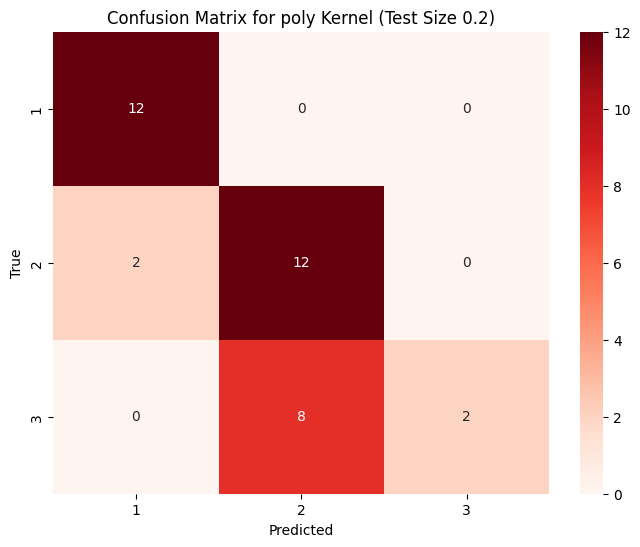

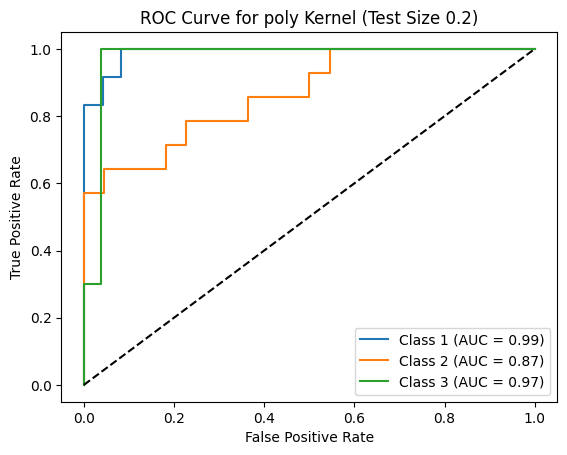

Running SVC with kernel 'poly' and test size 0.3...
Kernel: poly, Test Size: 0.3
Accuracy:  0.7037
Precision: 0.6982
Recall:    0.7037
F1-Score:  0.6641
Confusion Matrix:
[[17  0  1]
 [ 2 18  1]
 [ 0 12  3]]
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.94      0.92        18
           2       0.60      0.86      0.71        21
           3       0.60      0.20      0.30        15

    accuracy                           0.70        54
   macro avg       0.70      0.67      0.64        54
weighted avg       0.70      0.70      0.66        54

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


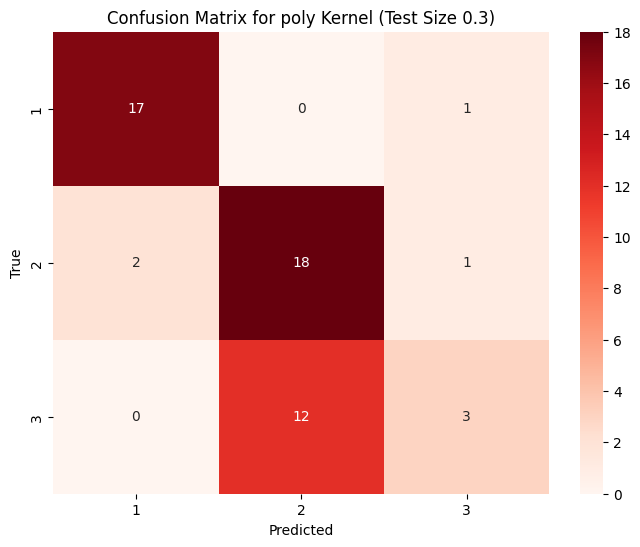

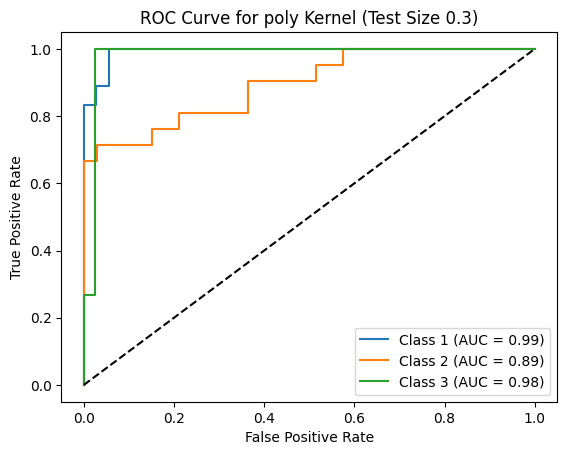

Running SVC with kernel 'poly' and test size 0.4...
Kernel: poly, Test Size: 0.4
Accuracy:  0.7083
Precision: 0.6842
Recall:    0.7083
F1-Score:  0.6640
Confusion Matrix:
[[23  0  1]
 [ 2 25  2]
 [ 0 16  3]]
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.96      0.94        24
           2       0.61      0.86      0.71        29
           3       0.50      0.16      0.24        19

    accuracy                           0.71        72
   macro avg       0.68      0.66      0.63        72
weighted avg       0.68      0.71      0.66        72

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


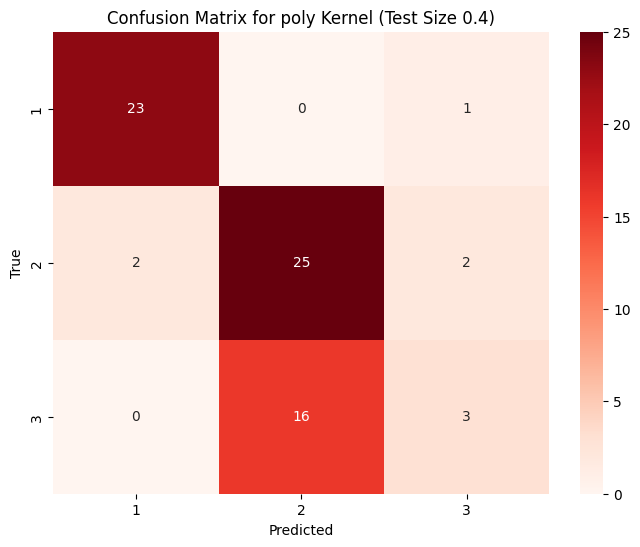

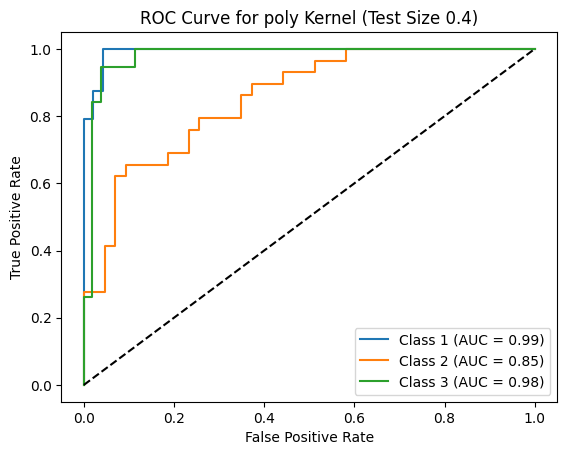

Running SVC with kernel 'poly' and test size 0.5...
Kernel: poly, Test Size: 0.5
Accuracy:  0.7416
Precision: 0.7689
Recall:    0.7416
F1-Score:  0.6881
Confusion Matrix:
[[30  0  0]
 [ 2 32  1]
 [ 1 19  4]]
Classification Report:
              precision    recall  f1-score   support

           1       0.91      1.00      0.95        30
           2       0.63      0.91      0.74        35
           3       0.80      0.17      0.28        24

    accuracy                           0.74        89
   macro avg       0.78      0.69      0.66        89
weighted avg       0.77      0.74      0.69        89

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


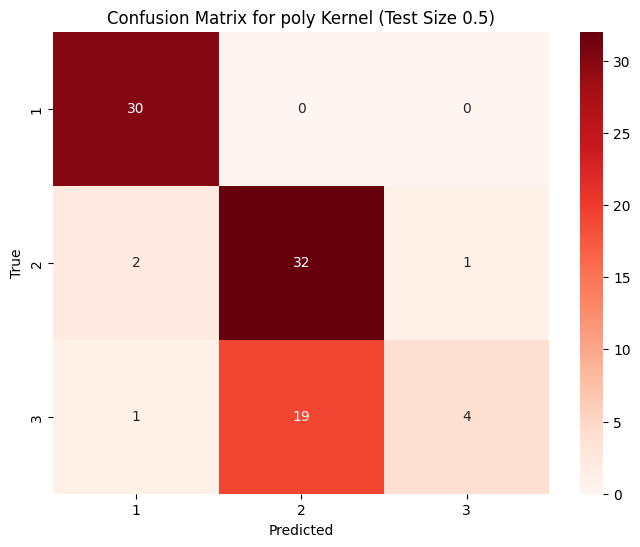

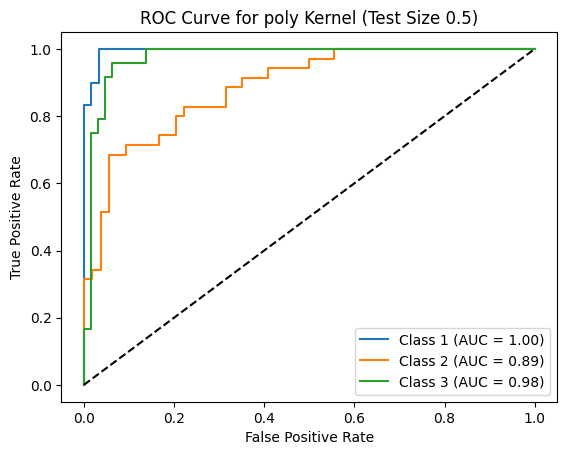

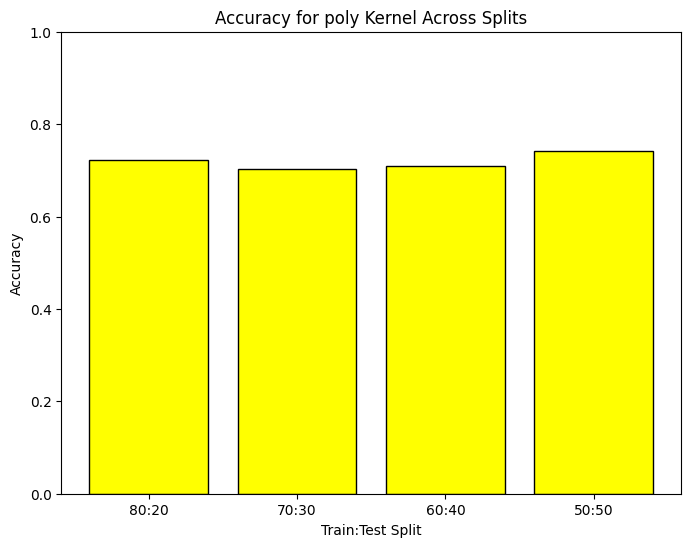

Running SVC with kernel 'rbf' and test size 0.2...
Kernel: rbf, Test Size: 0.2
Accuracy:  0.6944
Precision: 0.6960
Recall:    0.6944
F1-Score:  0.6524
Confusion Matrix:
[[12  0  0]
 [ 2 11  1]
 [ 0  8  2]]
Classification Report:
              precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       0.58      0.79      0.67        14
           3       0.67      0.20      0.31        10

    accuracy                           0.69        36
   macro avg       0.70      0.66      0.63        36
weighted avg       0.70      0.69      0.65        36

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


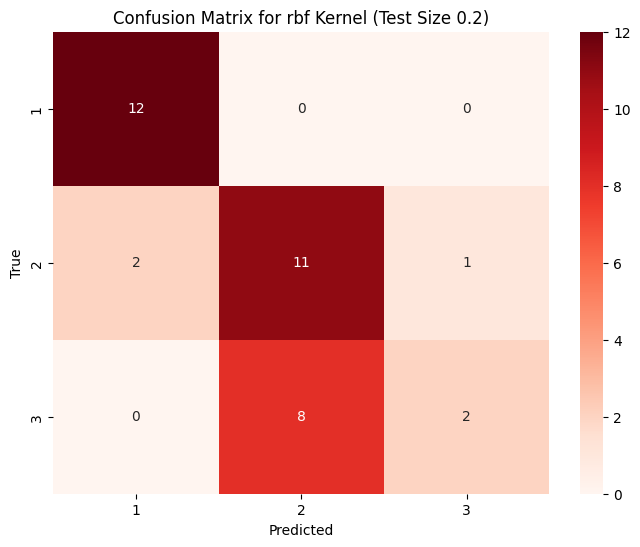

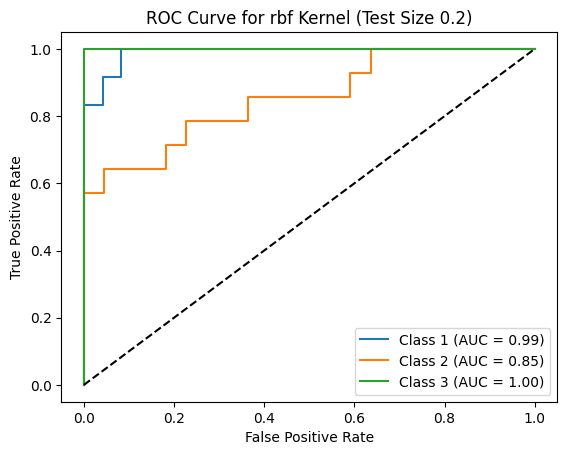

Running SVC with kernel 'rbf' and test size 0.3...
Kernel: rbf, Test Size: 0.3
Accuracy:  0.7222
Precision: 0.7213
Recall:    0.7222
F1-Score:  0.6915
Confusion Matrix:
[[18  0  0]
 [ 2 17  2]
 [ 0 11  4]]
Classification Report:
              precision    recall  f1-score   support

           1       0.90      1.00      0.95        18
           2       0.61      0.81      0.69        21
           3       0.67      0.27      0.38        15

    accuracy                           0.72        54
   macro avg       0.72      0.69      0.67        54
weighted avg       0.72      0.72      0.69        54

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


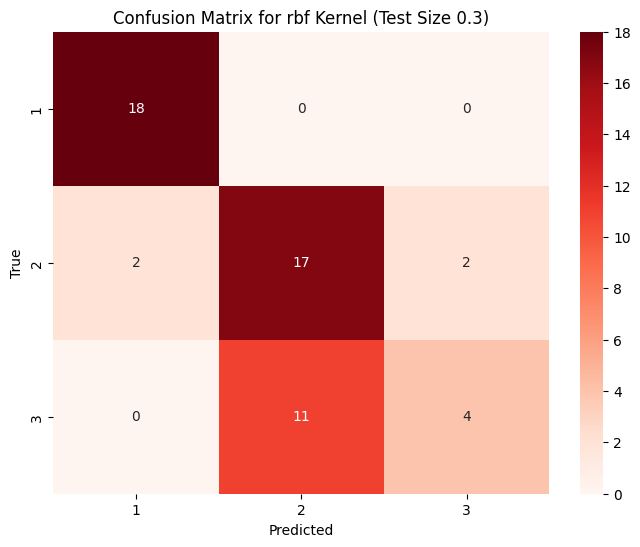

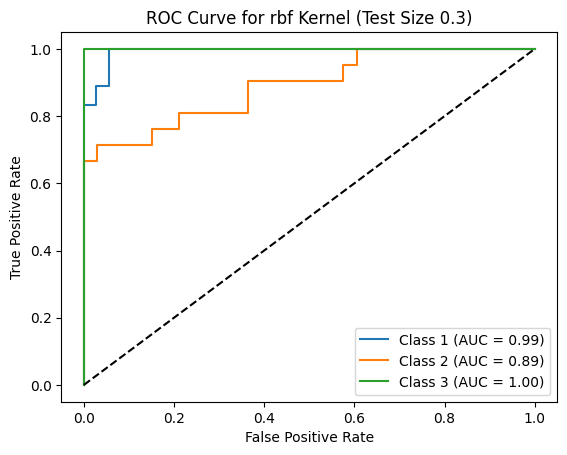

Running SVC with kernel 'rbf' and test size 0.4...
Kernel: rbf, Test Size: 0.4
Accuracy:  0.7500
Precision: 0.7415
Recall:    0.7500
F1-Score:  0.7390
Confusion Matrix:
[[23  0  1]
 [ 2 23  4]
 [ 0 11  8]]
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.96      0.94        24
           2       0.68      0.79      0.73        29
           3       0.62      0.42      0.50        19

    accuracy                           0.75        72
   macro avg       0.74      0.72      0.72        72
weighted avg       0.74      0.75      0.74        72

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


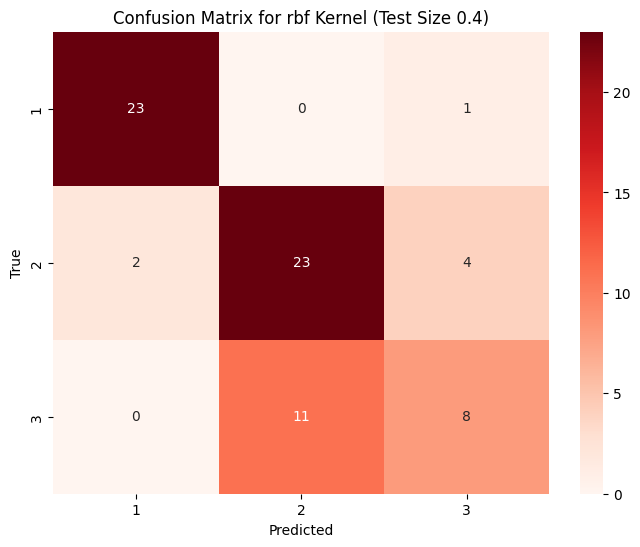

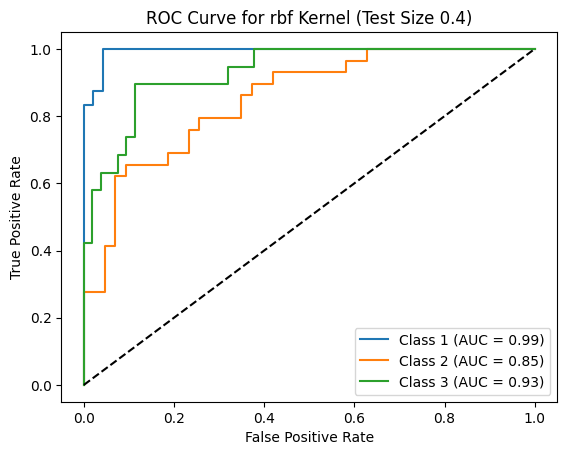

Running SVC with kernel 'rbf' and test size 0.5...
Kernel: rbf, Test Size: 0.5
Accuracy:  0.7079
Precision: 0.5382
Recall:    0.7079
F1-Score:  0.6062
Confusion Matrix:
[[30  0  0]
 [ 2 33  0]
 [ 1 23  0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.91      1.00      0.95        30
           2       0.59      0.94      0.73        35
           3       0.00      0.00      0.00        24

    accuracy                           0.71        89
   macro avg       0.50      0.65      0.56        89
weighted avg       0.54      0.71      0.61        89

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning

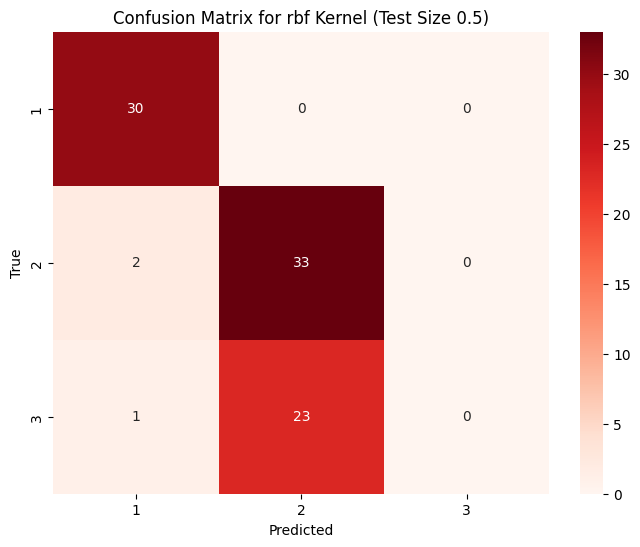

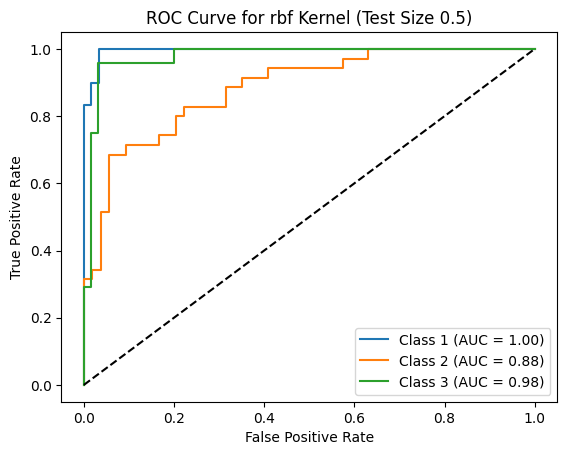

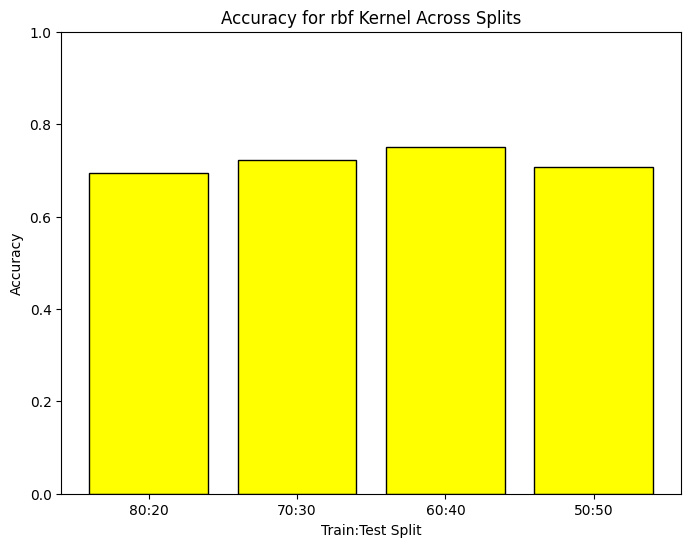

Running SVC with kernel 'sigmoid' and test size 0.2...
Kernel: sigmoid, Test Size: 0.2
Accuracy:  0.1667
Precision: 0.1167
Recall:    0.1667
F1-Score:  0.1373
Confusion Matrix:
[[ 0 12  0]
 [ 8  6  0]
 [ 8  2  0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.30      0.43      0.35        14
           3       0.00      0.00      0.00        10

    accuracy                           0.17        36
   macro avg       0.10      0.14      0.12        36
weighted avg       0.12      0.17      0.14        36

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning

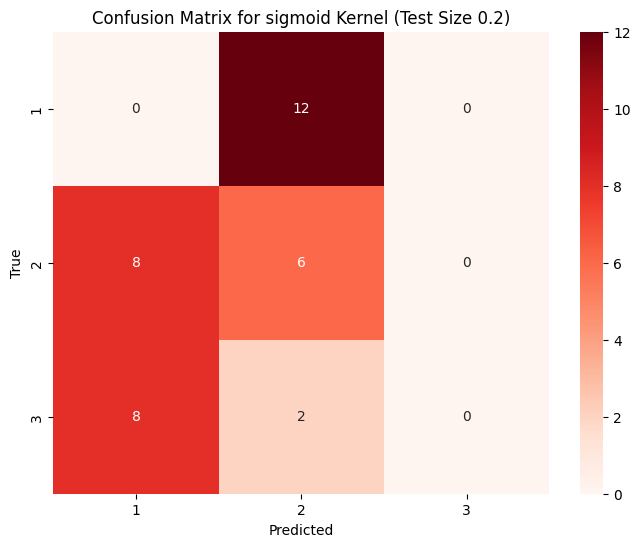

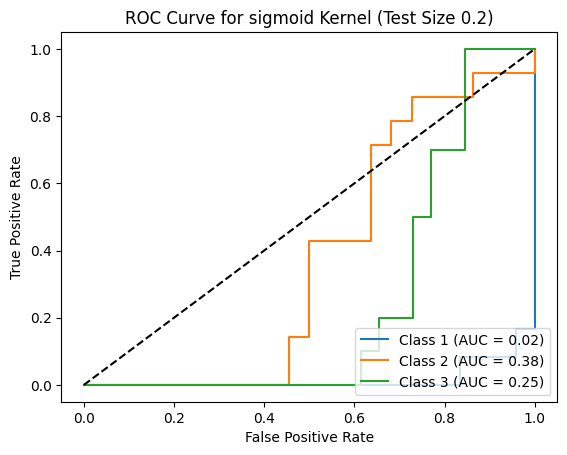

Running SVC with kernel 'sigmoid' and test size 0.3...
Kernel: sigmoid, Test Size: 0.3
Accuracy:  0.2222
Precision: 0.1373
Recall:    0.2222
F1-Score:  0.1697
Confusion Matrix:
[[ 0 18  0]
 [ 9 12  0]
 [11  4  0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        18
           2       0.35      0.57      0.44        21
           3       0.00      0.00      0.00        15

    accuracy                           0.22        54
   macro avg       0.12      0.19      0.15        54
weighted avg       0.14      0.22      0.17        54

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning

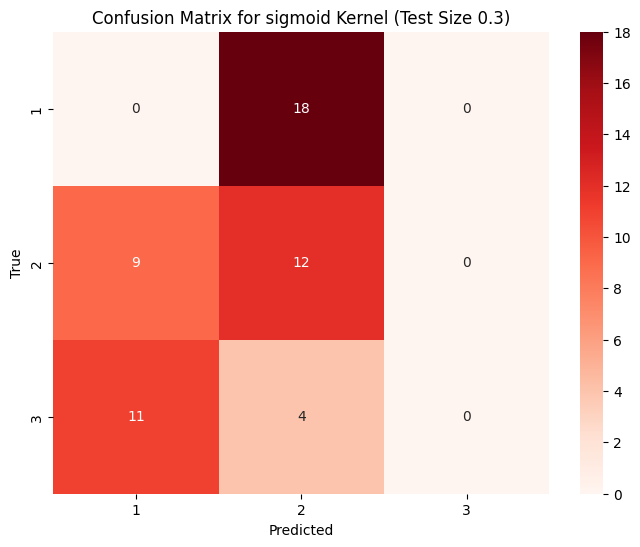

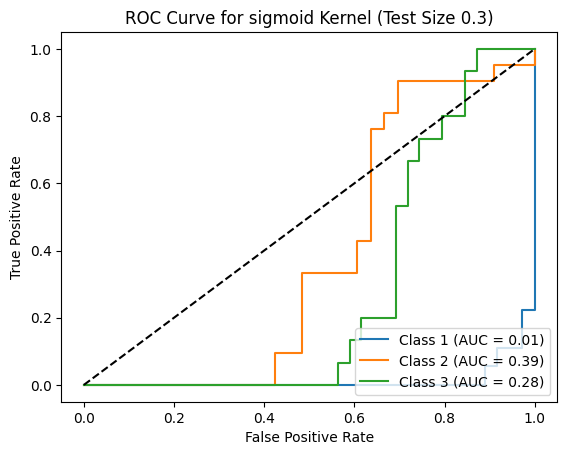

Running SVC with kernel 'sigmoid' and test size 0.4...
Kernel: sigmoid, Test Size: 0.4
Accuracy:  0.2222
Precision: 0.1432
Recall:    0.2222
F1-Score:  0.1742
Confusion Matrix:
[[ 0 24  0]
 [13 16  0]
 [14  5  0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.36      0.55      0.43        29
           3       0.00      0.00      0.00        19

    accuracy                           0.22        72
   macro avg       0.12      0.18      0.14        72
weighted avg       0.14      0.22      0.17        72

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning

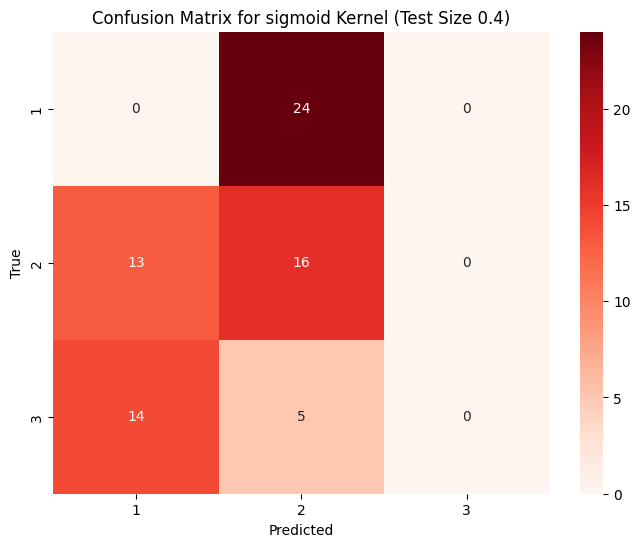

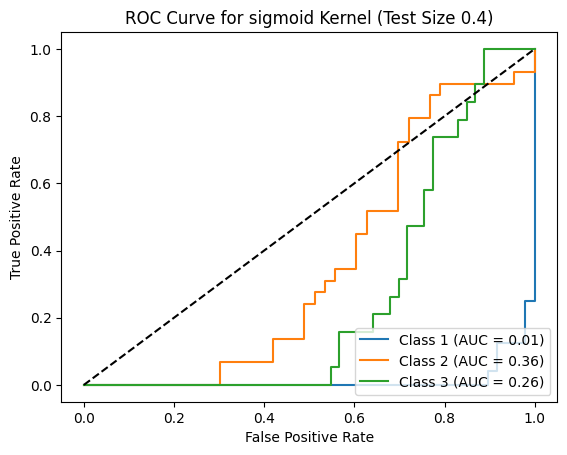

Running SVC with kernel 'sigmoid' and test size 0.5...
Kernel: sigmoid, Test Size: 0.5
Accuracy:  0.3933
Precision: 0.1547
Recall:    0.3933
F1-Score:  0.2220
Confusion Matrix:
[[ 0 30  0]
 [ 0 35  0]
 [ 0 24  0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        30
           2       0.39      1.00      0.56        35
           3       0.00      0.00      0.00        24

    accuracy                           0.39        89
   macro avg       0.13      0.33      0.19        89
weighted avg       0.15      0.39      0.22        89

----------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning

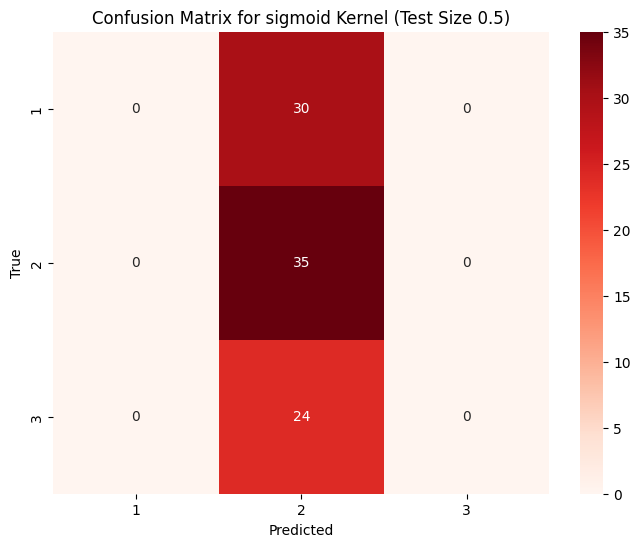

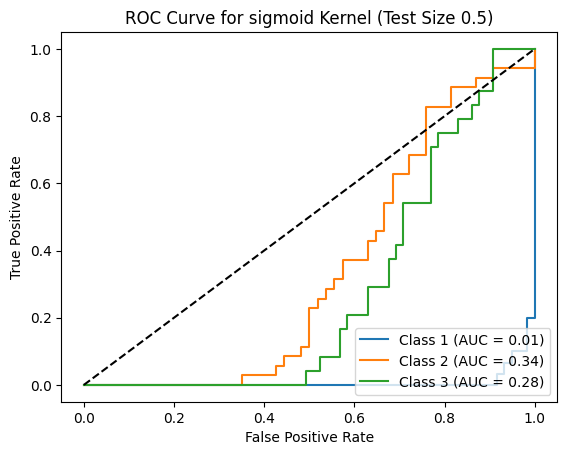

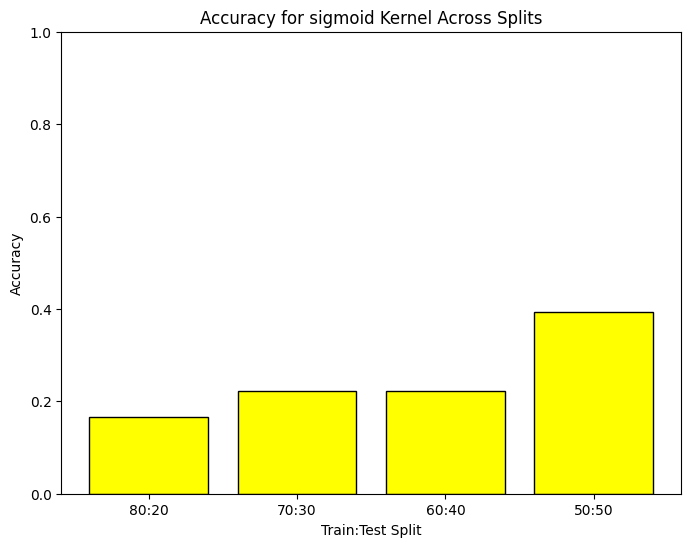

{('linear', 0.2): {'accuracy': 0.9166666666666666,
  'precision': 0.9224664224664225,
  'recall': 0.9166666666666666,
  'f1': 0.9165292147748288,
  'confusion_matrix': array([[12,  0,  0],
         [ 2, 12,  0],
         [ 0,  1,  9]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           1       0.86      1.00      0.92        12\n           2       0.92      0.86      0.89        14\n           3       1.00      0.90      0.95        10\n\n    accuracy                           0.92        36\n   macro avg       0.93      0.92      0.92        36\nweighted avg       0.92      0.92      0.92        36\n'},
 ('linear', 0.3): {'accuracy': 0.9259259259259259,
  'precision': 0.9296296296296297,
  'recall': 0.9259259259259259,
  'f1': 0.9255778334725704,
  'confusion_matrix': array([[18,  0,  0],
         [ 2, 19,  0],
         [ 0,  2, 13]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           1       0

In [51]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
test_sizes = [0.2, 0.3, 0.4, 0.5]

# Call the function to run SVC classifier for each kernel and test size
svc_classifier(wine_features, wine_targets, kernels=kernels, test_sizes=test_sizes)




# ***MLP Classifier***

In [53]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.multiclass import OneVsRestClassifier

def mlp_classifier(X, Y, test_sizes=[0.2, 0.3, 0.4, 0.5],momentum=0.9, max_iter=300, learning_rate='adaptive'):
    """
    MLP classifier testing across different train-test splits.
    Includes accuracy, precision, recall, f1-score, confusion matrices, and ROC curves.
    """

    results = {}
    accuracies = []

    # Get class labels
    class_labels = np.unique(Y)

    for test_size in test_sizes:
        print(f"\nRunning MLPClassifier with Test Size {test_size}...")

        # Split the data
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=40, stratify=Y
        )

        # MLP classifier
        mlp = MLPClassifier(hidden_layer_sizes=(10,10,10),momentum=momentum,learning_rate=learning_rate,max_iter=max_iter,random_state=2)

        mlp.fit(X_train, Y_train)
        Y_pred = mlp.predict(X_test)

        # --- Metrics ---
        accuracy = accuracy_score(Y_test, Y_pred)
        precision = precision_score(Y_test, Y_pred, average='weighted', zero_division=0)
        recall = recall_score(Y_test, Y_pred, average='weighted', zero_division=0)
        f1 = f1_score(Y_test, Y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(Y_test, Y_pred)
        class_report = classification_report(Y_test, Y_pred)

        results[test_size] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'classification_report': class_report,
            'Y_test': Y_test,
            'Y_pred': Y_pred
        }

        accuracies.append(accuracy)

        # --- Print metrics ---
        print("=================================================")
        print(f"Test Size: {test_size}")
        print(f"Accuracy : {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall   : {recall:.4f}")
        print(f"F1-Score : {f1:.4f}")
        print("Classification Report:\n", class_report)

        # --- Confusion Matrix ---
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f'Confusion Matrix (Test Size {test_size})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # --- ROC-AUC ---
        y_test_bin = label_binarize(Y_test, classes=class_labels)
        model_bin = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(10,10,10),momentum=momentum,learning_rate=learning_rate,max_iter=max_iter,random_state=42))
        model_bin.fit(X_train, Y_train)
        y_score = model_bin.predict_proba(X_test)

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(class_labels)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure()
        for i in range(len(class_labels)):
            plt.plot(fpr[i], tpr[i], label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve (Test Size {test_size})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

        print("--------------------------------------------------")

    # --- Accuracy Bar Graph Across Test Sizes ---
    plt.figure(figsize=(8, 6))
    plt.bar([f'{int(100*(1-size))}:{int(100*size)}' for size in test_sizes],
            accuracies, align='center', edgecolor='black',color='purple')
    plt.title('Accuracy of MLPClassifier Across Test Sizes')
    plt.xlabel('Train-Test Split')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

    return results



Running MLPClassifier with Test Size 0.2...
Test Size: 0.2
Accuracy : 0.9444
Precision: 0.9466
Recall   : 0.9444
F1-Score : 0.9443
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.93      0.93      0.93        14
           2       1.00      0.90      0.95        10

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.95        36
weighted avg       0.95      0.94      0.94        36



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


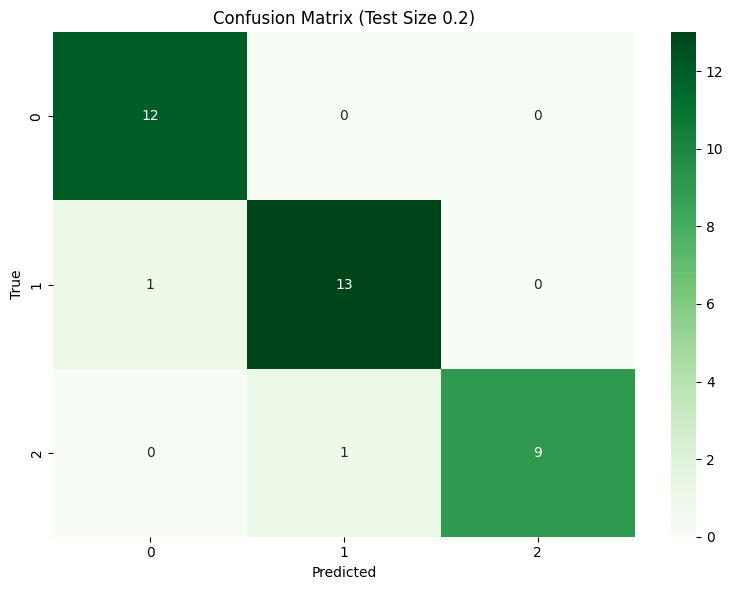

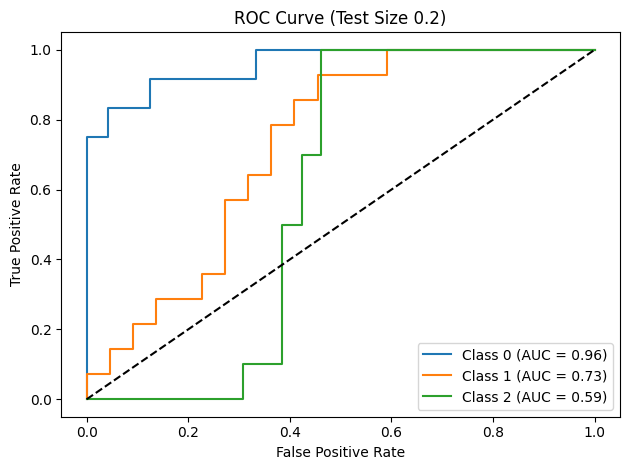

--------------------------------------------------

Running MLPClassifier with Test Size 0.3...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Size: 0.3
Accuracy : 0.9444
Precision: 0.9471
Recall   : 0.9444
F1-Score : 0.9440
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       0.91      0.95      0.93        21
           2       1.00      0.87      0.93        15

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.95      0.94      0.94        54



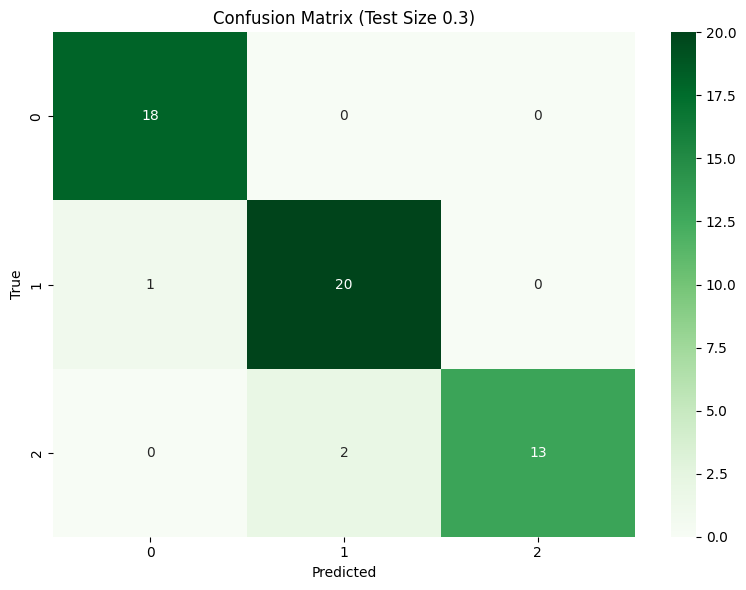

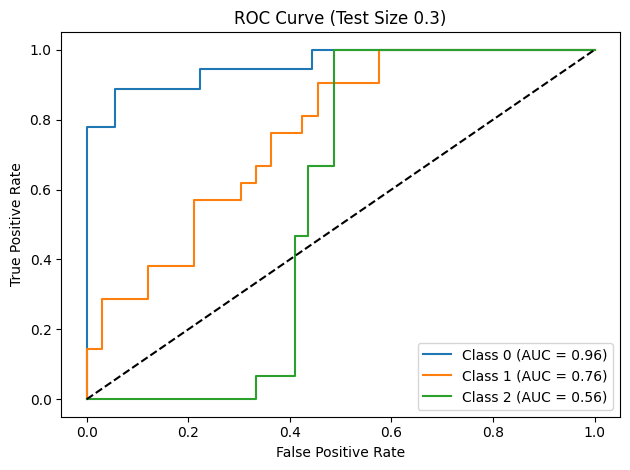

--------------------------------------------------

Running MLPClassifier with Test Size 0.4...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Size: 0.4
Accuracy : 0.9444
Precision: 0.9480
Recall   : 0.9444
F1-Score : 0.9445
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        24
           1       0.96      0.90      0.93        29
           2       1.00      0.95      0.97        19

    accuracy                           0.94        72
   macro avg       0.95      0.95      0.95        72
weighted avg       0.95      0.94      0.94        72



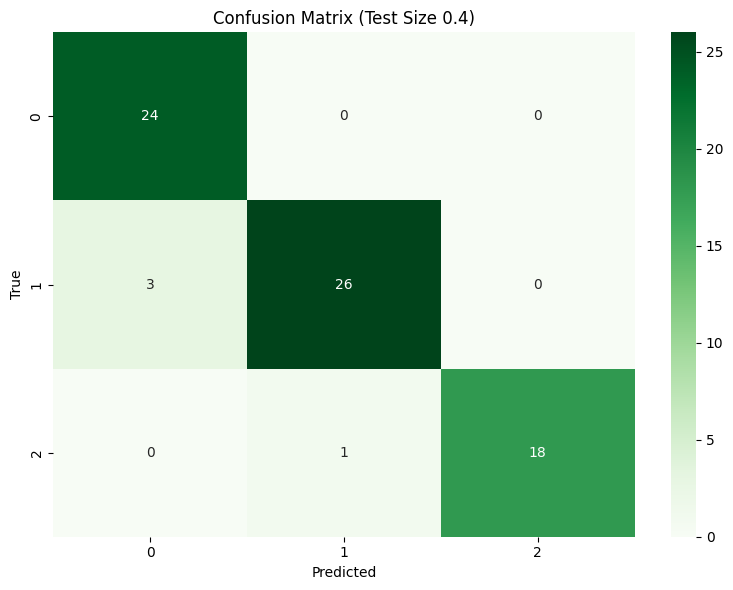

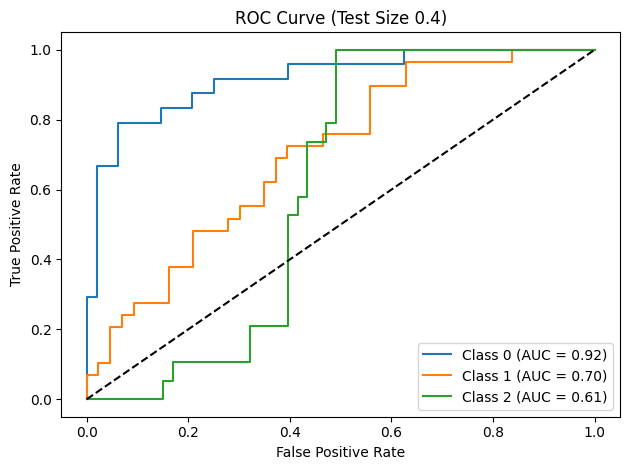

--------------------------------------------------

Running MLPClassifier with Test Size 0.5...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Size: 0.5
Accuracy : 0.9438
Precision: 0.9462
Recall   : 0.9438
F1-Score : 0.9435
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       0.92      0.94      0.93        35
           2       1.00      0.88      0.93        24

    accuracy                           0.94        89
   macro avg       0.95      0.94      0.94        89
weighted avg       0.95      0.94      0.94        89



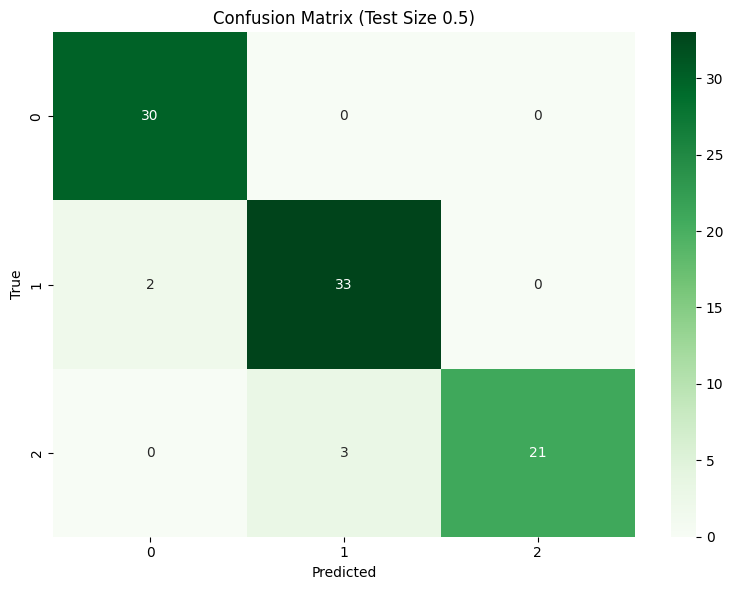

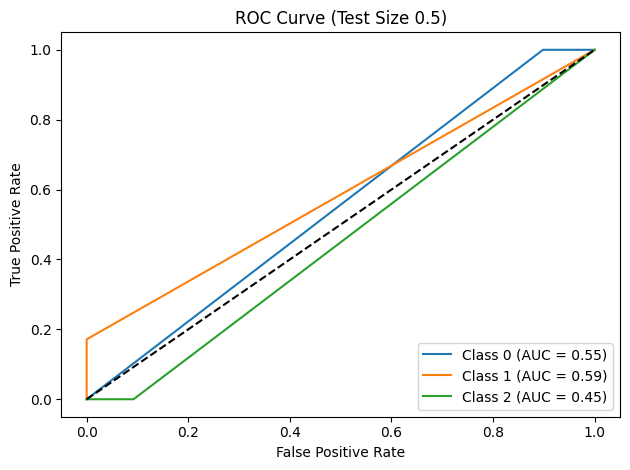

--------------------------------------------------


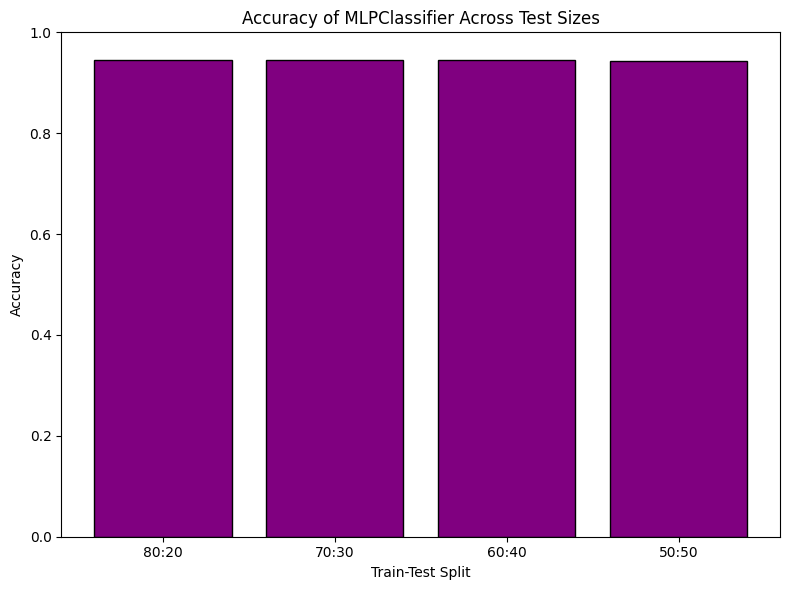

{0.2: {'accuracy': 0.9444444444444444,
  'precision': 0.9465811965811967,
  'recall': 0.9444444444444444,
  'f1_score': 0.944269005847953,
  'confusion_matrix': array([[12,  0,  0],
         [ 1, 13,  0],
         [ 0,  1,  9]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96        12\n           1       0.93      0.93      0.93        14\n           2       1.00      0.90      0.95        10\n\n    accuracy                           0.94        36\n   macro avg       0.95      0.94      0.95        36\nweighted avg       0.95      0.94      0.94        36\n',
  'Y_test': array([0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 1, 1, 1, 2, 1, 1, 1,
         1, 1, 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2]),
  'Y_pred': array([0, 0, 2, 2, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1,
         1, 1, 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2])},
 0.3: {'accuracy': 0.9444444444444444,
  'precision': 0.9471026049973418,

In [54]:
from sklearn.datasets import load_wine

# Load dataset
wine = load_wine()
wine_features = wine.data
wine_targets = wine.target

# Now call your MLP function
mlp_classifier(
    X=wine_features,
    Y=wine_targets,
    test_sizes=[0.2, 0.3, 0.4, 0.5],
    momentum=0.95,
    max_iter=1000,
    learning_rate='adaptive'
)



# ***Random Forest Classifier***

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# Load Wine Dataset
# -----------------------------
wine = load_wine()
wine_features = pd.DataFrame(wine.data, columns=wine.feature_names)  # X
wine_targets = pd.Series(wine.target)  # y


# -----------------------------
# Random Forest Classifier Function
# -----------------------------
def random_forest_classifier(X, Y, test_sizes=[0.2, 0.3, 0.4, 0.5],n_estimators=100, max_depth=5, random_state=2):
    results = {}

    for test_size in test_sizes:
        print(f"\nRunning RandomForest with test size {test_size}...")
        print("="*80)

        # Split dataset
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=random_state, stratify=Y
        )

        # Train Random Forest
        rf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,random_state=random_state)
        rf.fit(X_train, Y_train)

        # Predictions
        Y_pred = rf.predict(X_test)

        # Metrics
        accuracy = accuracy_score(Y_test, Y_pred)
        precision = precision_score(Y_test, Y_pred, average="weighted")
        recall = recall_score(Y_test, Y_pred, average="weighted")
        f1 = f1_score(Y_test, Y_pred, average="weighted")
        class_report = classification_report(Y_test, Y_pred)

        results[test_size] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "classification_report": class_report
        }

        # Print report
        print(f"Test Size: {test_size}")
        print(f"Accuracy : {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall   : {recall:.4f}")
        print(f"F1-Score : {f1:.4f}")
        print("Classification Report:\n", class_report)

        # Plot confusion matrix
        cm = confusion_matrix(Y_test, Y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=wine.target_names)
        disp.plot(cmap="Purples", values_format="d")
        plt.title(f"Confusion Matrix (Test Size={test_size})")
        plt.show()

    # -----------------------------
    # Feature Importance Plot
    # -----------------------------
    feature_importances = rf.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx],
            edgecolor="black",color='pink')
    plt.xticks(range(len(feature_importances)),
               np.array(X.columns)[sorted_idx], rotation=90)
    plt.title("Random Forest Feature Importances")
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.tight_layout()
    plt.show()

    return results


Running RandomForest with test size 0.2...
Test Size: 0.2
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-Score : 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



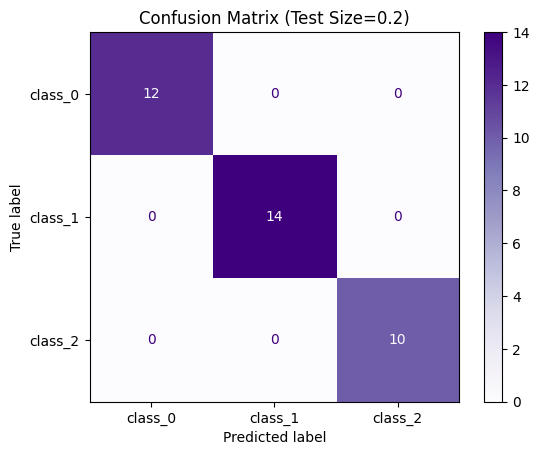


Running RandomForest with test size 0.3...
Test Size: 0.3
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-Score : 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        15

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



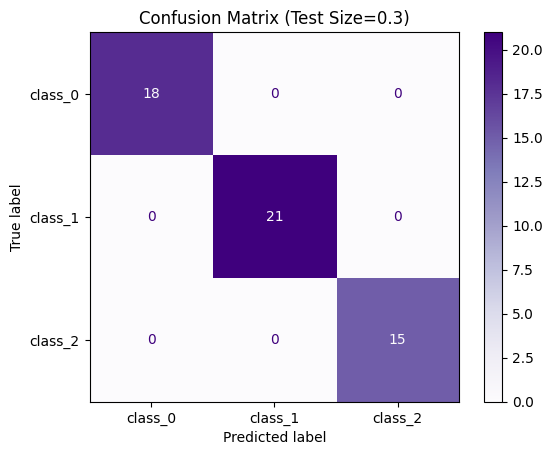


Running RandomForest with test size 0.4...
Test Size: 0.4
Accuracy : 0.9722
Precision: 0.9729
Recall   : 0.9722
F1-Score : 0.9723
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.97      0.97      0.97        29
           2       0.95      1.00      0.97        19

    accuracy                           0.97        72
   macro avg       0.97      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72



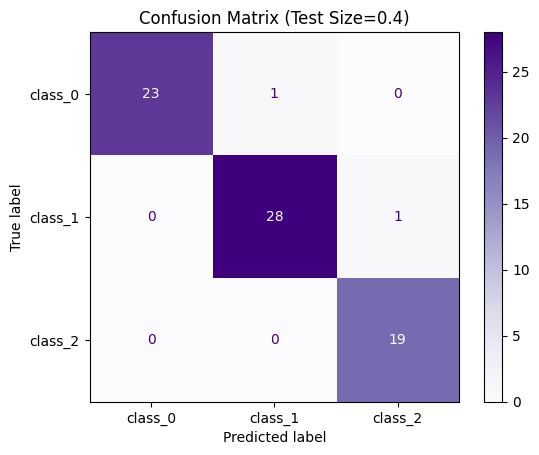


Running RandomForest with test size 0.5...
Test Size: 0.5
Accuracy : 0.9775
Precision: 0.9787
Recall   : 0.9775
F1-Score : 0.9775
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.95      1.00      0.97        35
           2       1.00      1.00      1.00        24

    accuracy                           0.98        89
   macro avg       0.98      0.98      0.98        89
weighted avg       0.98      0.98      0.98        89



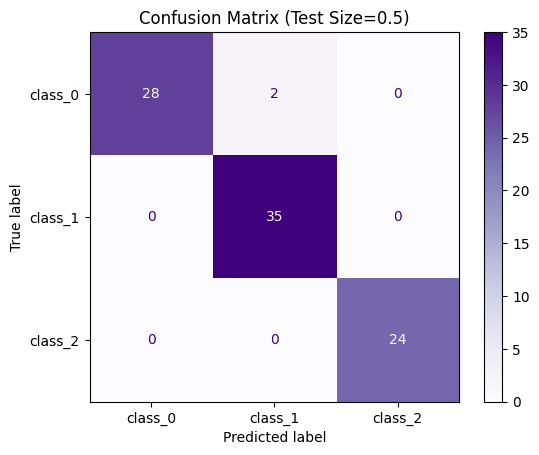

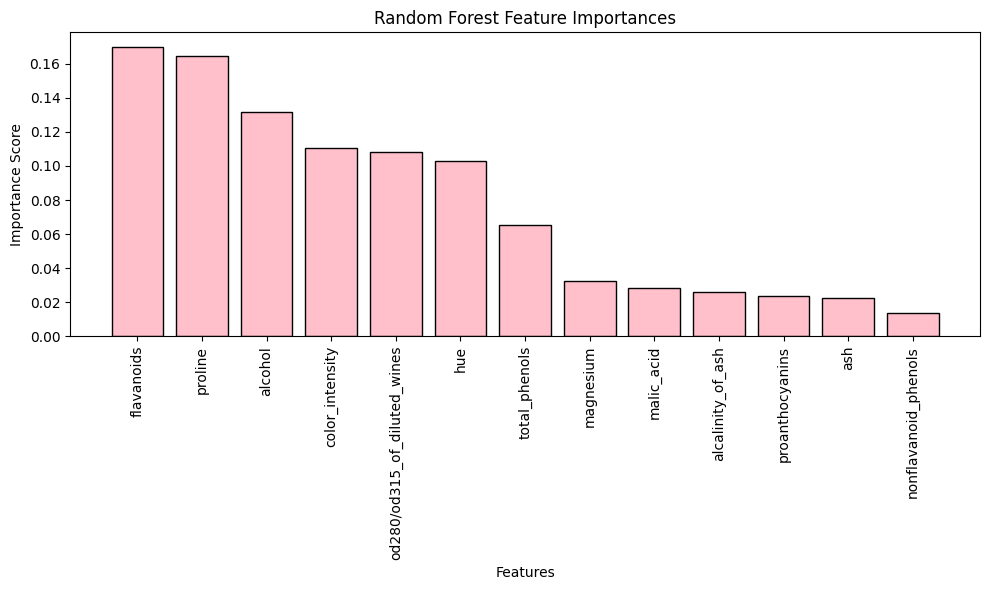

In [56]:
rf_results = random_forest_classifier(
    X=wine_features,
    Y=wine_targets,
    test_sizes=[0.2, 0.3, 0.4, 0.5],
    n_estimators=100,
    max_depth=5,
    random_state=2
)

# ***SVC Classifier with PCA***

In [57]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import numpy as np

def svc_classifier_with_pca(X, Y, kernels=['linear', 'poly', 'rbf', 'sigmoid'], test_sizes=[0.2, 0.3, 0.4, 0.5]):
    """
    SVC classifier with various kernels, testing across different train-test splits.
    Applies PCA for dimensionality reduction to 5 components.
    Shows confusion matrix + accuracy/precision/recall/f1 plots.
    """

    results = {}

    for kernel in kernels:
        accuracies, precisions, recalls, f1s = [], [], [], []

        for test_size in test_sizes:
            print(f"\nRunning SVC with kernel '{kernel}' and test size {test_size}...")

            # Split data
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=40)

            # Apply PCA
            pca = PCA(n_components=5)
            X_train_pca = pca.fit_transform(X_train)
            X_test_pca = pca.transform(X_test)

            # Train SVC
            svc = SVC(kernel=kernel, C=1, probability=True, random_state=42)
            svc.fit(X_train_pca, Y_train)
            Y_pred = svc.predict(X_test_pca)

            # Metrics
            accuracy = accuracy_score(Y_test, Y_pred)
            precision = precision_score(Y_test, Y_pred, average='weighted', zero_division=0)
            recall = recall_score(Y_test, Y_pred, average='weighted', zero_division=0)
            f1 = f1_score(Y_test, Y_pred, average='weighted', zero_division=0)
            cm = confusion_matrix(Y_test, Y_pred)
            class_report = classification_report(Y_test, Y_pred)

            # Store results
            results[(kernel, test_size)] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'confusion_matrix': cm,
                'classification_report': class_report
            }

            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)

            # Print
            print("=========================================================")
            print(f"Kernel: {kernel}, Test Size: {test_size}")
            print(f"Accuracy : {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall   : {recall:.4f}")
            print(f"F1-Score : {f1:.4f}")
            print("Classification Report:\n", class_report)

            # Plot confusion matrix
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap="Greens", values_format="d")
            plt.title(f"Confusion Matrix ({kernel}, test_size={test_size})")
            plt.show()

        # Bar plot for this kernel
        print("\nAccuracy, Precision, Recall, F1 across test sizes\n")
        plt.figure(figsize=(8, 6))
        x = np.arange(len(test_sizes))
        width = 0.2

        plt.bar(x - 0.3, accuracies, width, label='Accuracy', edgecolor='black')
        plt.bar(x - 0.1, precisions, width, label='Precision', edgecolor='black')
        plt.bar(x + 0.1, recalls, width, label='Recall', edgecolor='black')
        plt.bar(x + 0.3, f1s, width, label='F1-score', edgecolor='black')

        plt.xticks(x, [f'{int(100*(1-size))}:{int(100*size)}' for size in test_sizes])
        plt.ylim(0, 1.05)
        plt.title(f'Metrics for {kernel} Kernel Across Different Test Sizes')
        plt.xlabel('Train-Test Split')
        plt.ylabel('Score')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return results



Running SVC with kernel 'linear' and test size 0.2...
Kernel: linear, Test Size: 0.2
Accuracy : 0.9722
Precision: 0.9744
Recall   : 0.9722
F1-Score : 0.9722
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      1.00      1.00        11
           2       1.00      0.92      0.96        13

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



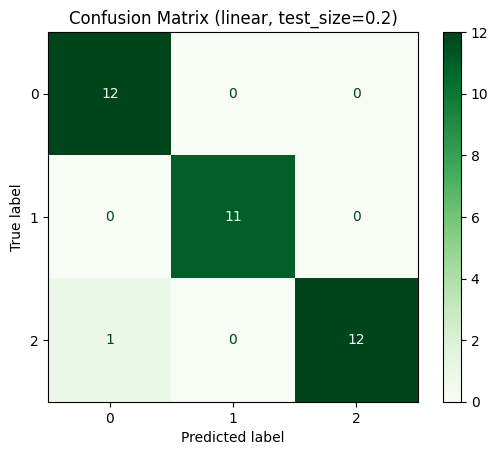


Running SVC with kernel 'linear' and test size 0.3...
Kernel: linear, Test Size: 0.3
Accuracy : 0.9444
Precision: 0.9478
Recall   : 0.9444
F1-Score : 0.9443
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.91      1.00      0.95        20
           2       1.00      0.89      0.94        19

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.95      0.94      0.94        54



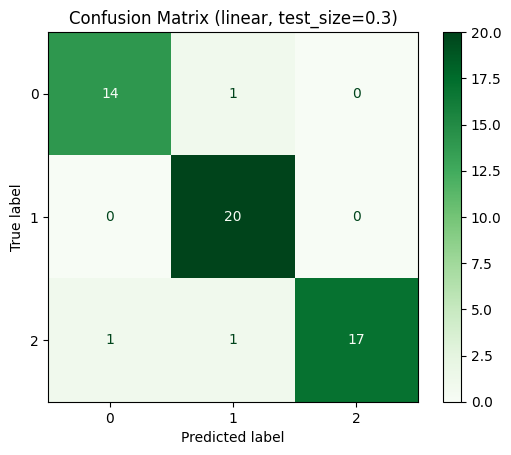


Running SVC with kernel 'linear' and test size 0.4...
Kernel: linear, Test Size: 0.4
Accuracy : 0.9583
Precision: 0.9601
Recall   : 0.9583
F1-Score : 0.9580
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.94      1.00      0.97        30
           2       1.00      0.89      0.94        19

    accuracy                           0.96        72
   macro avg       0.96      0.95      0.96        72
weighted avg       0.96      0.96      0.96        72



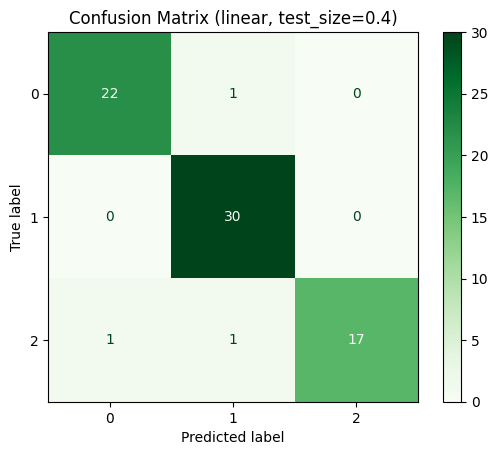


Running SVC with kernel 'linear' and test size 0.5...
Kernel: linear, Test Size: 0.5
Accuracy : 0.9438
Precision: 0.9475
Recall   : 0.9438
F1-Score : 0.9437
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       0.90      1.00      0.95        36
           2       1.00      0.91      0.95        23

    accuracy                           0.94        89
   macro avg       0.95      0.94      0.94        89
weighted avg       0.95      0.94      0.94        89



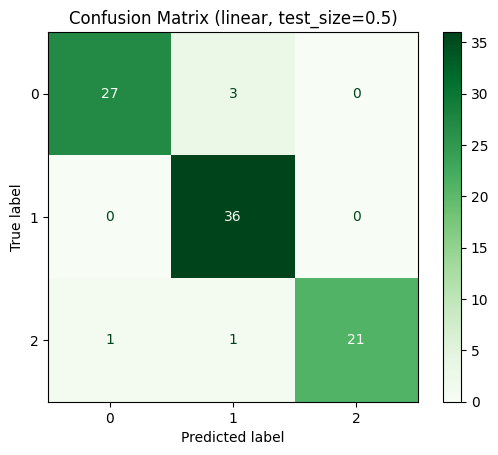


Accuracy, Precision, Recall, F1 across test sizes



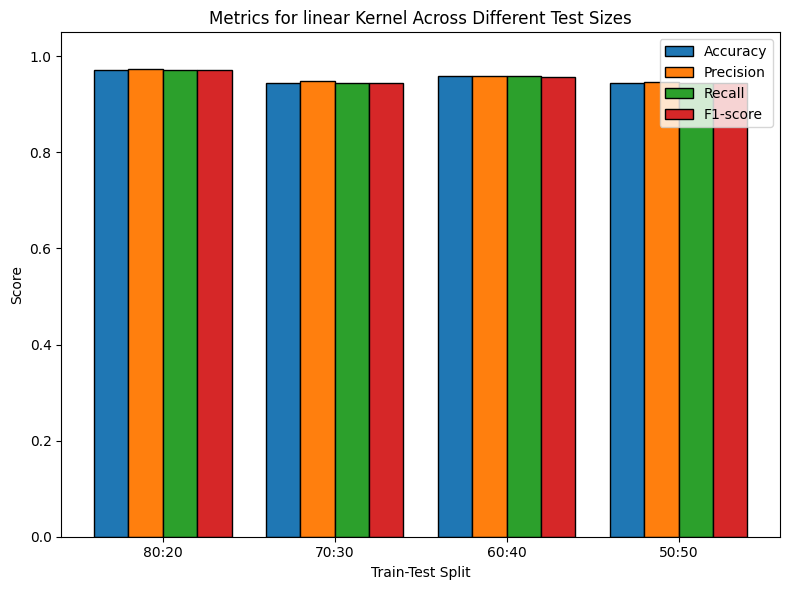


Running SVC with kernel 'poly' and test size 0.2...
Kernel: poly, Test Size: 0.2
Accuracy : 0.6389
Precision: 0.6667
Recall   : 0.6389
F1-Score : 0.6497
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.50      0.55      0.52        11
           2       0.50      0.54      0.52        13

    accuracy                           0.64        36
   macro avg       0.67      0.64      0.65        36
weighted avg       0.67      0.64      0.65        36



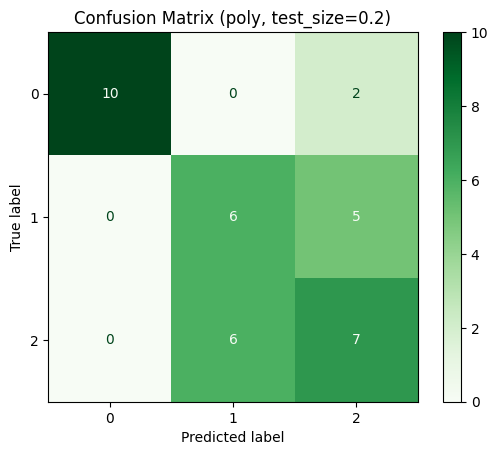


Running SVC with kernel 'poly' and test size 0.3...
Kernel: poly, Test Size: 0.3
Accuracy : 0.5926
Precision: 0.6384
Recall   : 0.5926
F1-Score : 0.6059
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.56      0.50      0.53        20
           2       0.44      0.58      0.50        19

    accuracy                           0.59        54
   macro avg       0.67      0.60      0.62        54
weighted avg       0.64      0.59      0.61        54



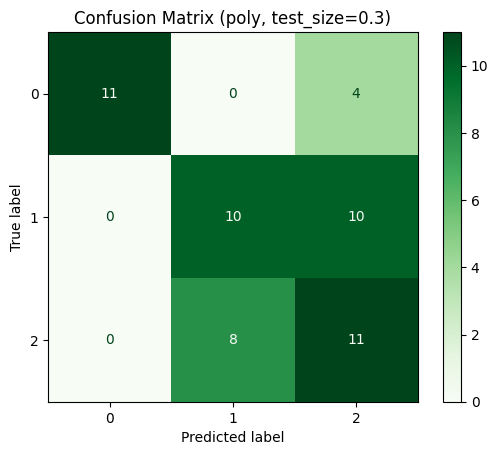


Running SVC with kernel 'poly' and test size 0.4...
Kernel: poly, Test Size: 0.4
Accuracy : 0.6667
Precision: 0.7202
Recall   : 0.6667
F1-Score : 0.6845
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88        23
           1       0.70      0.63      0.67        30
           2       0.41      0.58      0.48        19

    accuracy                           0.67        72
   macro avg       0.70      0.66      0.67        72
weighted avg       0.72      0.67      0.68        72



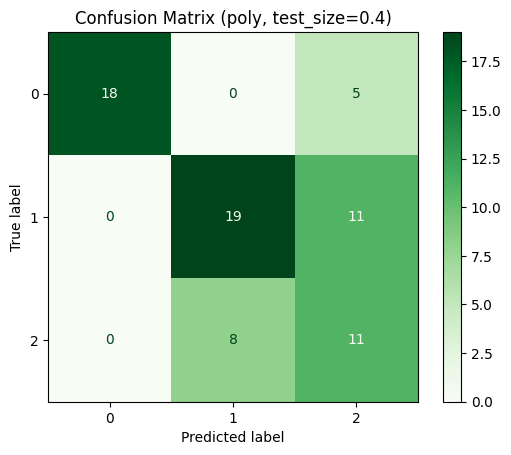


Running SVC with kernel 'poly' and test size 0.5...
Kernel: poly, Test Size: 0.5
Accuracy : 0.6854
Precision: 0.7557
Recall   : 0.6854
F1-Score : 0.7042
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87        30
           1       0.76      0.61      0.68        36
           2       0.43      0.70      0.53        23

    accuracy                           0.69        89
   macro avg       0.73      0.69      0.69        89
weighted avg       0.76      0.69      0.70        89



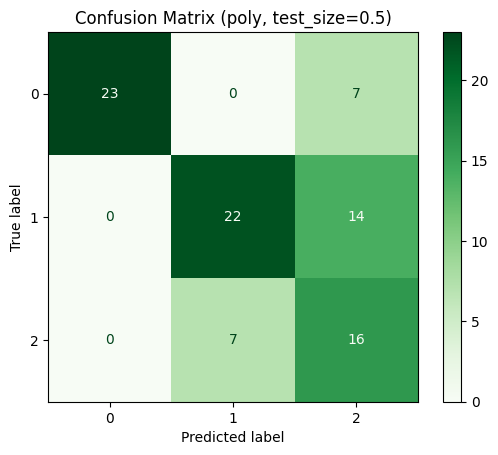


Accuracy, Precision, Recall, F1 across test sizes



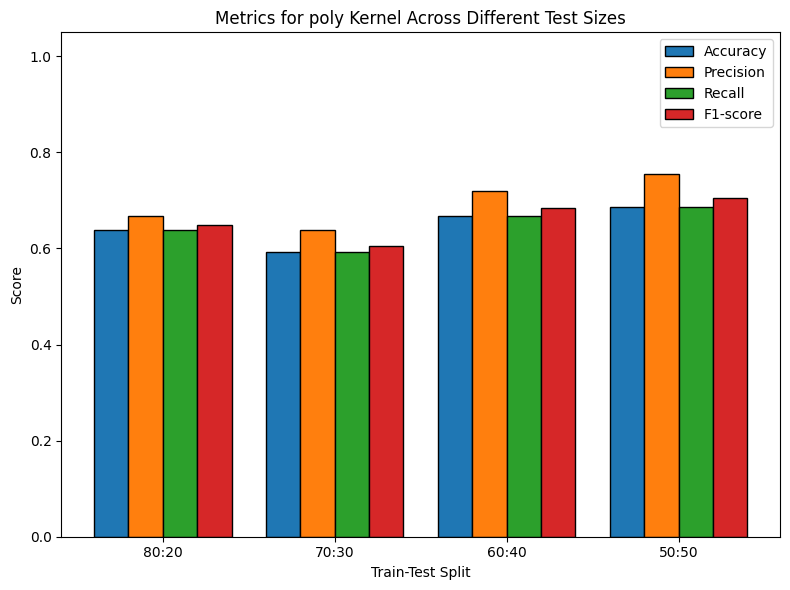


Running SVC with kernel 'rbf' and test size 0.2...
Kernel: rbf, Test Size: 0.2
Accuracy : 0.6389
Precision: 0.6293
Recall   : 0.6389
F1-Score : 0.6298
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.46      0.55      0.50        11
           2       0.50      0.38      0.43        13

    accuracy                           0.64        36
   macro avg       0.63      0.64      0.63        36
weighted avg       0.63      0.64      0.63        36



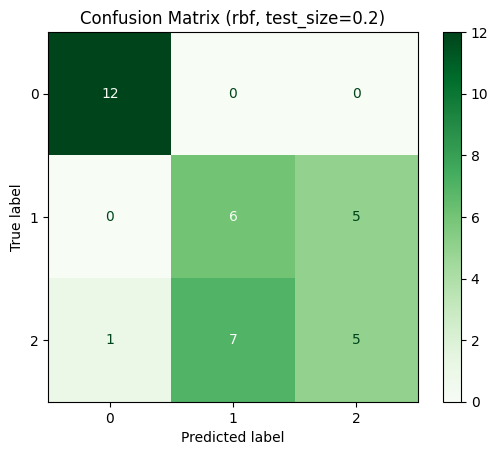


Running SVC with kernel 'rbf' and test size 0.3...
Kernel: rbf, Test Size: 0.3
Accuracy : 0.6111
Precision: 0.6072
Recall   : 0.6111
F1-Score : 0.6082
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.56      0.50      0.53        20
           2       0.45      0.47      0.46        19

    accuracy                           0.61        54
   macro avg       0.63      0.64      0.63        54
weighted avg       0.61      0.61      0.61        54



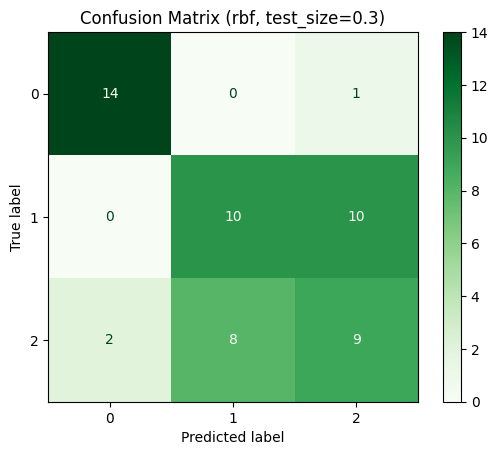


Running SVC with kernel 'rbf' and test size 0.4...
Kernel: rbf, Test Size: 0.4
Accuracy : 0.6944
Precision: 0.7129
Recall   : 0.6944
F1-Score : 0.7016
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.70      0.63      0.67        30
           2       0.43      0.53      0.48        19

    accuracy                           0.69        72
   macro avg       0.70      0.69      0.69        72
weighted avg       0.71      0.69      0.70        72



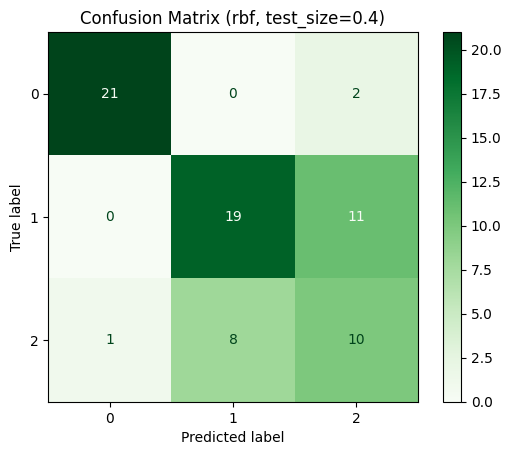


Running SVC with kernel 'rbf' and test size 0.5...
Kernel: rbf, Test Size: 0.5
Accuracy : 0.6854
Precision: 0.7232
Recall   : 0.6854
F1-Score : 0.6990
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.72      0.64      0.68        36
           2       0.42      0.57      0.48        23

    accuracy                           0.69        89
   macro avg       0.70      0.68      0.68        89
weighted avg       0.72      0.69      0.70        89



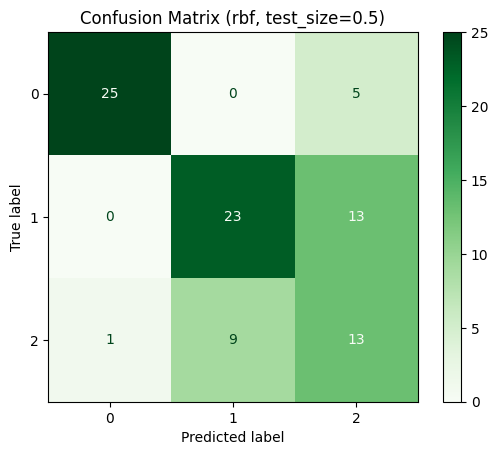


Accuracy, Precision, Recall, F1 across test sizes



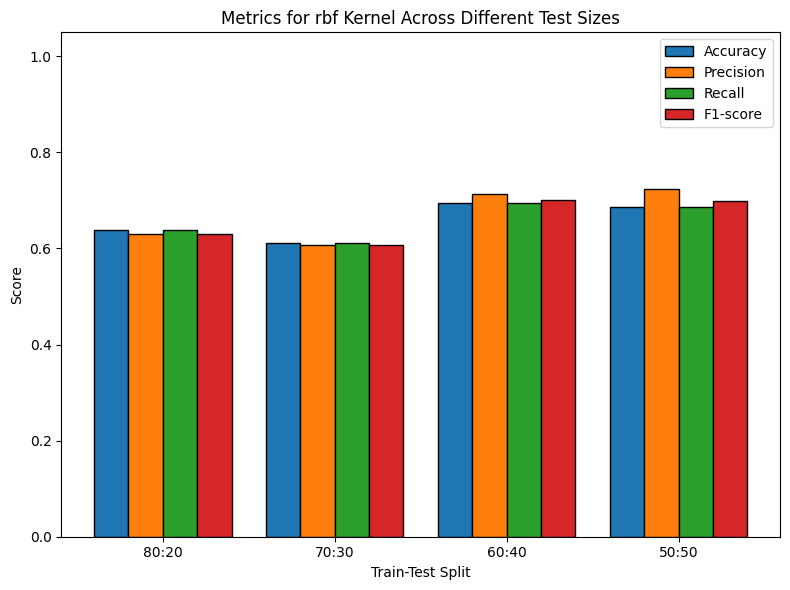


Running SVC with kernel 'sigmoid' and test size 0.2...
Kernel: sigmoid, Test Size: 0.2
Accuracy : 0.5833
Precision: 0.5266
Recall   : 0.5833
F1-Score : 0.5254
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.42      0.73      0.53        11
           2       0.25      0.08      0.12        13

    accuracy                           0.58        36
   macro avg       0.53      0.60      0.54        36
weighted avg       0.53      0.58      0.53        36



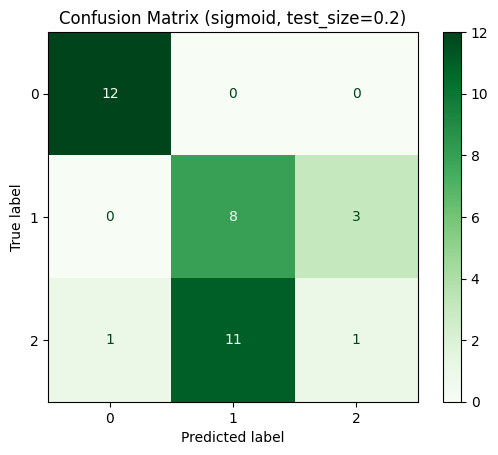


Running SVC with kernel 'sigmoid' and test size 0.3...
Kernel: sigmoid, Test Size: 0.3
Accuracy : 0.5926
Precision: 0.5042
Recall   : 0.5926
F1-Score : 0.5178
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.52      0.85      0.64        20
           2       0.20      0.05      0.08        19

    accuracy                           0.59        54
   macro avg       0.53      0.61      0.54        54
weighted avg       0.50      0.59      0.52        54



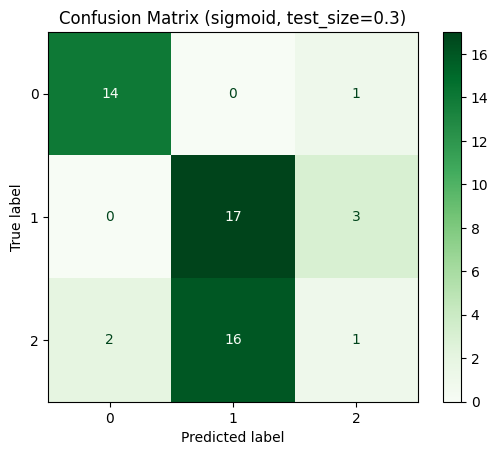


Running SVC with kernel 'sigmoid' and test size 0.4...
Kernel: sigmoid, Test Size: 0.4
Accuracy : 0.6250
Precision: 0.5604
Recall   : 0.6250
F1-Score : 0.5869
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        23
           1       0.58      0.73      0.65        30
           2       0.10      0.05      0.07        19

    accuracy                           0.62        72
   macro avg       0.53      0.58      0.55        72
weighted avg       0.56      0.62      0.59        72



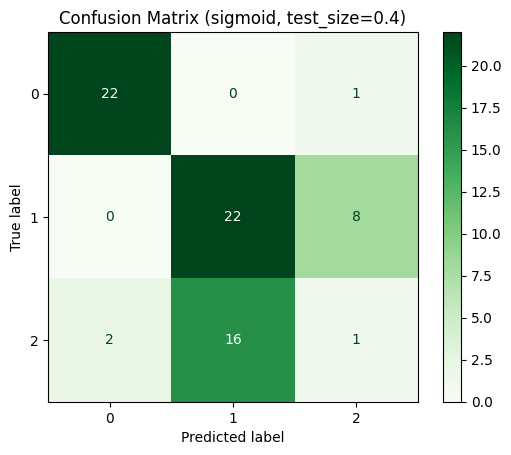


Running SVC with kernel 'sigmoid' and test size 0.5...
Kernel: sigmoid, Test Size: 0.5
Accuracy : 0.6629
Precision: 0.6175
Recall   : 0.6629
F1-Score : 0.6262
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91        30
           1       0.61      0.86      0.71        36
           2       0.18      0.09      0.12        23

    accuracy                           0.66        89
   macro avg       0.58      0.60      0.58        89
weighted avg       0.62      0.66      0.63        89



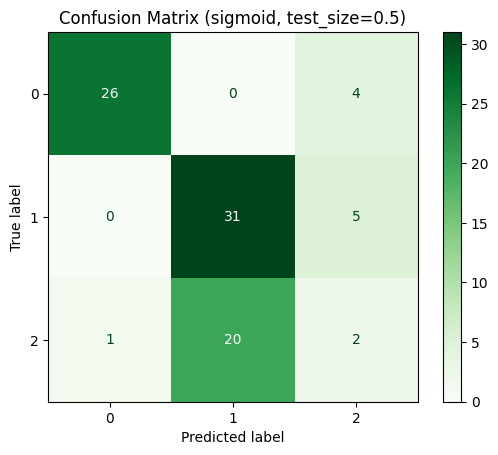


Accuracy, Precision, Recall, F1 across test sizes



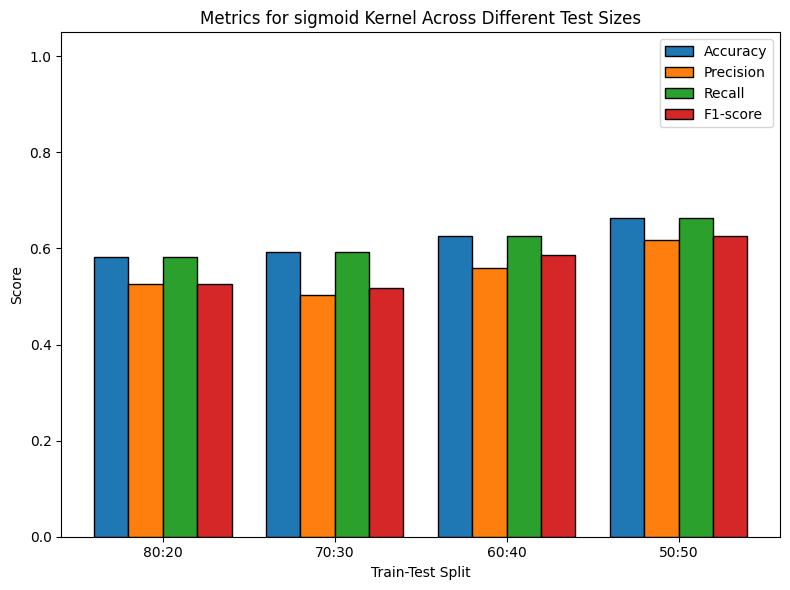

{('linear', 0.2): {'accuracy': 0.9722222222222222,
  'precision': 0.9743589743589745,
  'recall': 0.9722222222222222,
  'f1': 0.9722222222222222,
  'confusion_matrix': array([[12,  0,  0],
         [ 0, 11,  0],
         [ 1,  0, 12]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96        12\n           1       1.00      1.00      1.00        11\n           2       1.00      0.92      0.96        13\n\n    accuracy                           0.97        36\n   macro avg       0.97      0.97      0.97        36\nweighted avg       0.97      0.97      0.97        36\n'},
 ('linear', 0.3): {'accuracy': 0.9444444444444444,
  'precision': 0.9478114478114478,
  'recall': 0.9444444444444444,
  'f1': 0.9442974720752498,
  'confusion_matrix': array([[14,  1,  0],
         [ 0, 20,  0],
         [ 1,  1, 17]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0

In [58]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
test_sizes= [0.2, 0.3, 0.4, 0.5]

# Call the function to run SVC classifier for each kernel and test size
svc_classifier_with_pca(X=wine_features, Y=wine_targets, kernels=kernels, test_sizes=test_sizes)

# ***MLP Classifier with PCA***

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,roc_curve, auc)
from sklearn.multiclass import OneVsRestClassifier


def mlp_classifier_with_pca(X, Y, test_sizes=[0.2, 0.3, 0.4, 0.5],momentum=0.9, max_iter=1000,learning_rate='adaptive', n_components=5):
    """
    MLP classifier with PCA for dimensionality reduction.
    Tests across different train-test splits.
    Includes confusion matrices, accuracy plots, and ROC curves.
    """

    results = {}
    accuracies = []

    # --- Fix: Detect Y correctly ---
    if isinstance(Y, pd.DataFrame):   # If Y is DataFrame
        if "class" in Y.columns:
            Y = Y["class"]
        elif "quality" in Y.columns:
            Y = Y["quality"]
        elif "target" in Y.columns:
            Y = Y["target"]
        else:
            raise ValueError(f"Target column not found. Available: {Y.columns}")

    class_labels = np.unique(Y)

    for test_size in test_sizes:
        print(f"\nRunning MLPClassifier with Test Size {test_size} and PCA n_components={n_components}...")

        # Split the data
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=40, stratify=Y)

        # Standardize before PCA
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Apply PCA
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # MLP classifier
        mlp = MLPClassifier(hidden_layer_sizes=(10,10,10),momentum=momentum,learning_rate=learning_rate,max_iter=max_iter,random_state=2)

        mlp.fit(X_train_pca, Y_train)
        Y_pred = mlp.predict(X_test_pca)

        # Evaluate
        accuracy = accuracy_score(Y_test, Y_pred)
        cm = confusion_matrix(Y_test, Y_pred)
        class_report = classification_report(Y_test, Y_pred)

        results[test_size] = {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'classification_report': class_report,
            'Y_test': Y_test,
            'Y_pred': Y_pred
        }

        accuracies.append(accuracy)

        print("Accuracy:", accuracy)
        print("Classification Report:\n", class_report)

        # --- Confusion Matrix Heatmap ---
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f'Confusion Matrix (Test Size {test_size})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # --- ROC Curve ---
        try:
            Y_test_bin = label_binarize(Y_test, classes=class_labels)
            Y_score = OneVsRestClassifier(mlp).fit(X_train_pca, Y_train).predict_proba(X_test_pca)

            fpr, tpr, roc_auc = {}, {}, {}
            plt.figure(figsize=(7, 6))
            for i, label in enumerate(class_labels):
                fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
                plt.plot(fpr[i], tpr[i],
                         label=f'Class {label} (AUC = {roc_auc[i]:.2f})')

            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve (Test Size {test_size})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Skipping ROC curve (reason: {e})")


    # --- Accuracy Bar Graph Across Test Sizes ---
    print("\nPlotting Accuracy Bar Graph Across All Test Sizes...")
    plt.figure(figsize=(8, 6))
    plt.bar([f'{int(100*(1-size))}:{int(100*size)}' for size in test_sizes], accuracies, align='center')
    plt.title('Accuracy of MLPClassifier with PCA Across Test Sizes')
    plt.xlabel('Train-Test Split')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

    return results



Running MLPClassifier with Test Size 0.2 and PCA n_components=5...
Accuracy: 0.9722222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.93      0.96        14
           2       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36



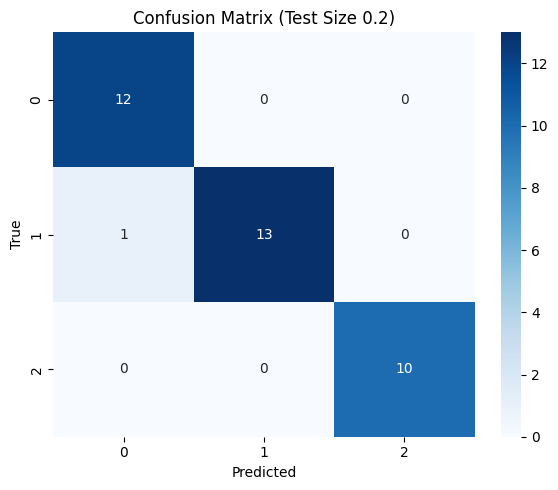

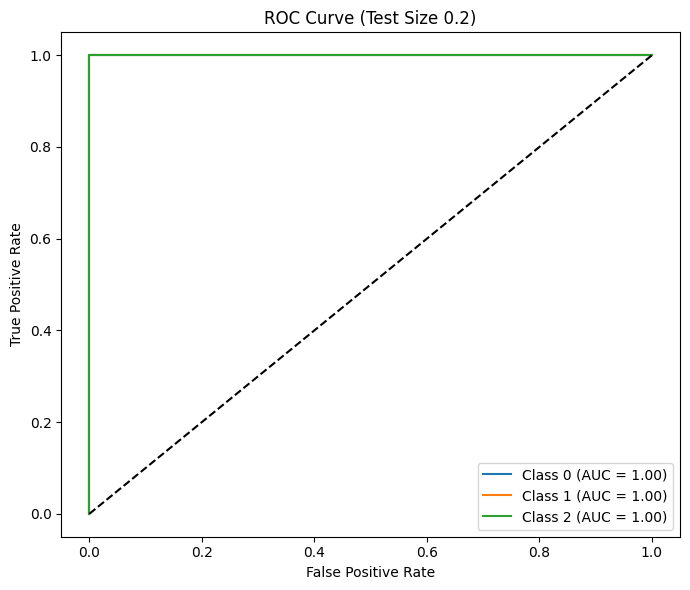


Running MLPClassifier with Test Size 0.3 and PCA n_components=5...
Accuracy: 0.9814814814814815
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.95      0.98        21
           2       1.00      1.00      1.00        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



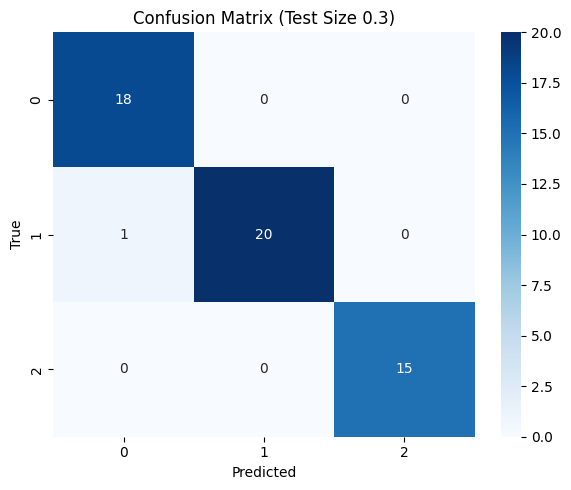

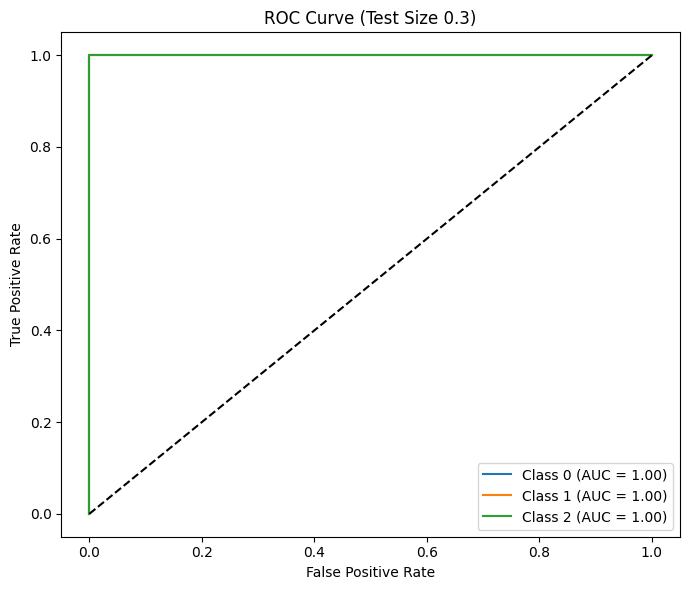


Running MLPClassifier with Test Size 0.4 and PCA n_components=5...
Accuracy: 0.9861111111111112
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      0.97      0.98        29
           2       0.95      1.00      0.97        19

    accuracy                           0.99        72
   macro avg       0.98      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72



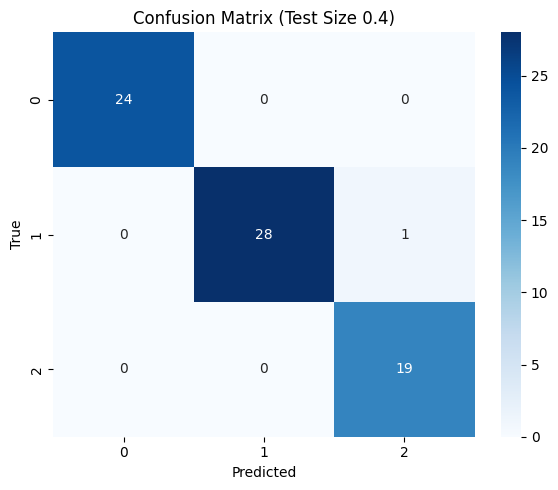

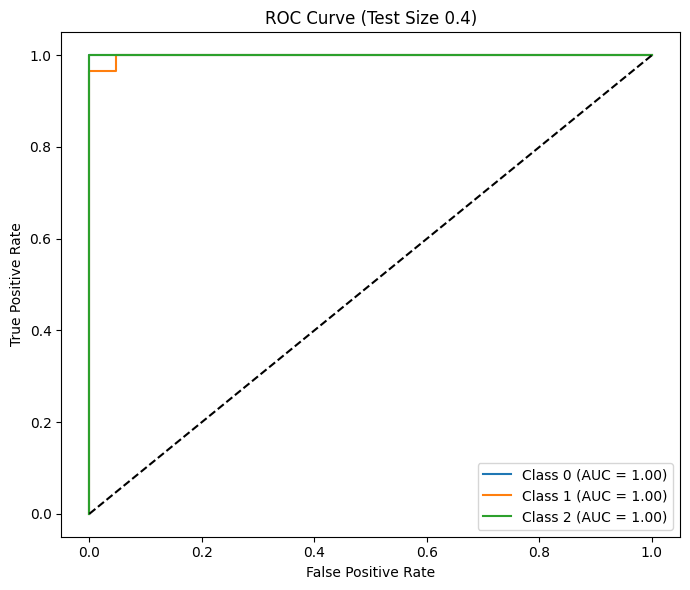


Running MLPClassifier with Test Size 0.5 and PCA n_components=5...
Accuracy: 0.9438202247191011
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        30
           1       0.97      0.89      0.93        35
           2       0.96      0.96      0.96        24

    accuracy                           0.94        89
   macro avg       0.95      0.95      0.95        89
weighted avg       0.95      0.94      0.94        89



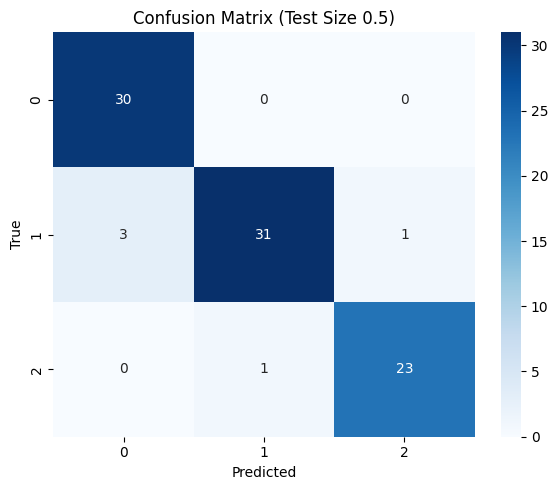

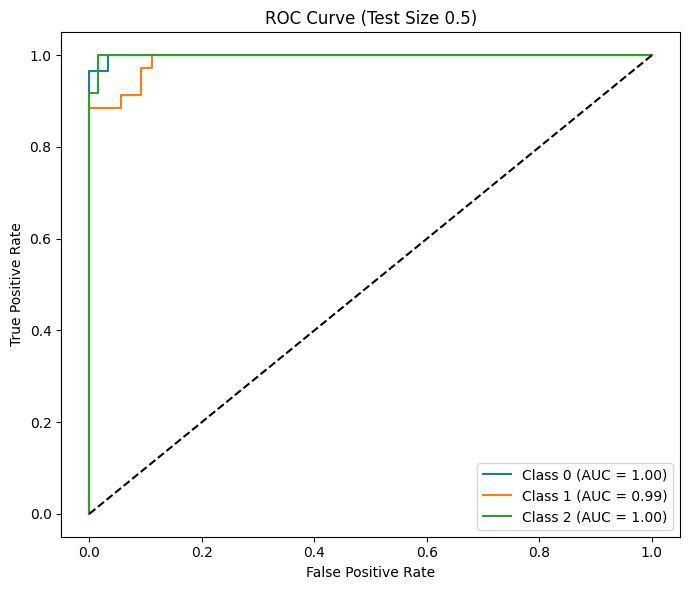


Plotting Accuracy Bar Graph Across All Test Sizes...


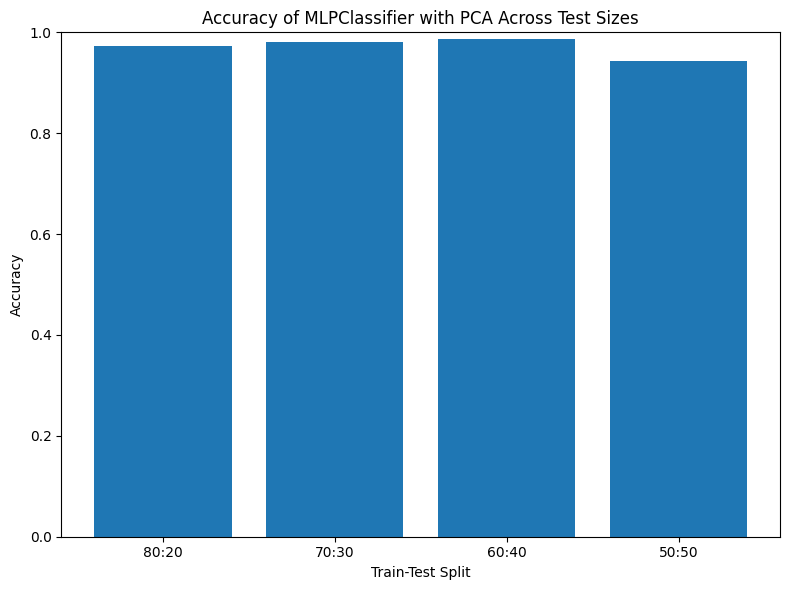

{0.2: {'accuracy': 0.9722222222222222,
  'confusion_matrix': array([[12,  0,  0],
         [ 1, 13,  0],
         [ 0,  0, 10]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96        12\n           1       1.00      0.93      0.96        14\n           2       1.00      1.00      1.00        10\n\n    accuracy                           0.97        36\n   macro avg       0.97      0.98      0.97        36\nweighted avg       0.97      0.97      0.97        36\n',
  'Y_test': 7      0
  50     0
  133    2
  169    2
  129    1
  111    1
  56     0
  19     0
  162    2
  95     1
  10     0
  54     0
  130    2
  6      0
  31     0
  59     1
  112    1
  127    1
  177    2
  60     1
  92     1
  116    1
  122    1
  73     1
  67     1
  37     0
  155    2
  168    2
  137    2
  1      0
  93     1
  27     0
  147    2
  12     0
  128    1
  143    2
  Name: target, dtype: int64,
  'Y_pred': ar

In [60]:
from sklearn.datasets import load_wine
wine = load_wine()
wine_features = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_targets = pd.Series(wine.target, name="target")

mlp_classifier_with_pca(
    X=wine_features,
    Y=wine_targets,
    test_sizes=[0.2, 0.3, 0.4, 0.5],
    momentum=0.95,
    max_iter=1000,
    learning_rate='adaptive',
    n_components=5
)

# ***Random Forest With PCA***

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.multiclass import OneVsRestClassifier


def random_forest_classifier_with_pca(X, Y, test_sizes=[0.2, 0.3, 0.4, 0.5],n_estimators=100, max_depth=5,random_state=2, n_components=5):
    """
    Random Forest classifier with PCA for dimensionality reduction.
    Tests across different train-test splits.
    Plots accuracy, confusion matrices, ROC curves.
    """

    results = {}
    accuracies = []

    # --- Fix: Detect Y correctly ---
    if isinstance(Y, pd.DataFrame):
        if "class" in Y.columns:
            Y = Y["class"]
        elif "quality" in Y.columns:
            Y = Y["quality"]
        elif "target" in Y.columns:
            Y = Y["target"]
        else:
            raise ValueError(f"Target column not found. Available: {Y.columns}")

    class_labels = np.unique(Y)

    for test_size in test_sizes:
        print(f"\nRunning RandomForestClassifier with Test Size {test_size} and PCA n_components={n_components}...")

        # Split the data
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=40, stratify=Y
        )

        # Standardize before PCA
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Apply PCA
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Train Random Forest
        rf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,random_state=random_state)
        rf.fit(X_train_pca, Y_train)
        Y_pred = rf.predict(X_test_pca)

        # Evaluate
        accuracy = accuracy_score(Y_test, Y_pred)
        cm = confusion_matrix(Y_test, Y_pred)
        class_report = classification_report(Y_test, Y_pred)

        results[test_size] = {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'classification_report': class_report,
            'Y_test': Y_test,
            'Y_pred': Y_pred
        }

        accuracies.append(accuracy)

        print("Accuracy:", accuracy)
        print("Classification Report:\n", class_report)

        # --- Confusion Matrix Heatmap ---
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f'Confusion Matrix (Test Size {test_size})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # --- ROC Curve ---
        try:
            Y_test_bin = label_binarize(Y_test, classes=class_labels)
            Y_score = OneVsRestClassifier(rf).fit(X_train_pca, Y_train).predict_proba(X_test_pca)

            fpr, tpr, roc_auc = {}, {}, {}
            plt.figure(figsize=(7, 6))
            for i, label in enumerate(class_labels):
                fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
                plt.plot(fpr[i], tpr[i],
                         label=f'Class {label} (AUC = {roc_auc[i]:.2f})')

            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve (Test Size {test_size})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Skipping ROC curve (reason: {e})")


    # --- Accuracy Bar Graph Across Test Sizes ---
    print("\nPlotting Accuracy Bar Graph Across All Test Sizes...")
    plt.figure(figsize=(8, 6))
    plt.bar([f'{int(100*(1-size))}:{int(100*size)}' for size in test_sizes], accuracies, align='center')
    plt.title('Accuracy of RandomForestClassifier with PCA Across Test Sizes')
    plt.xlabel('Train-Test Split')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

    return results



Running RandomForestClassifier with Test Size 0.2 and PCA n_components=5...
Accuracy: 0.9444444444444444
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      0.86      0.92        14
           2       1.00      1.00      1.00        10

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.95        36
weighted avg       0.95      0.94      0.94        36



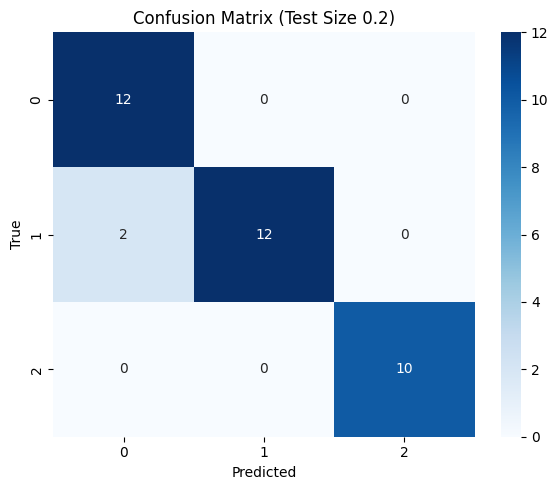

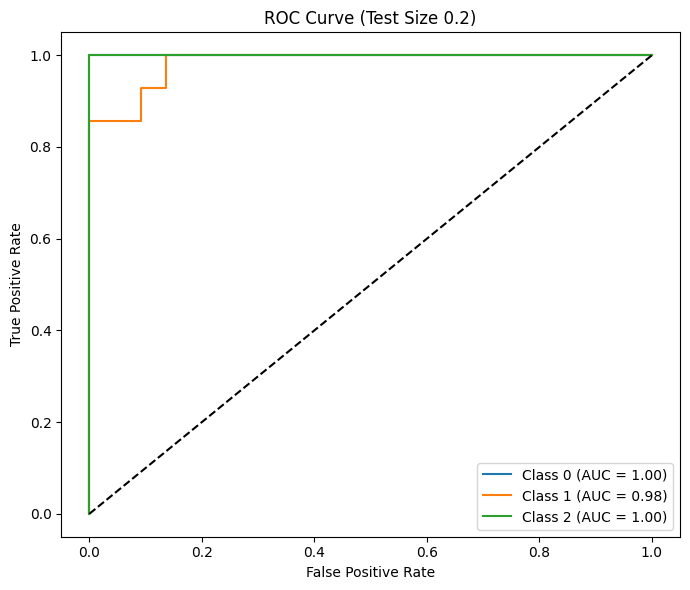


Running RandomForestClassifier with Test Size 0.3 and PCA n_components=5...
Accuracy: 0.9629629629629629
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.90      0.95        21
           2       1.00      1.00      1.00        15

    accuracy                           0.96        54
   macro avg       0.97      0.97      0.97        54
weighted avg       0.97      0.96      0.96        54



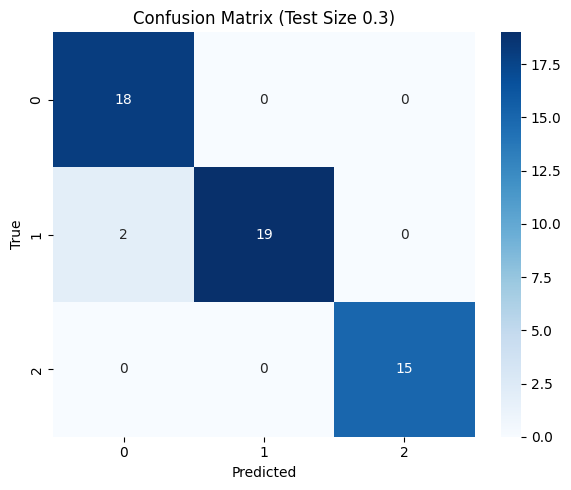

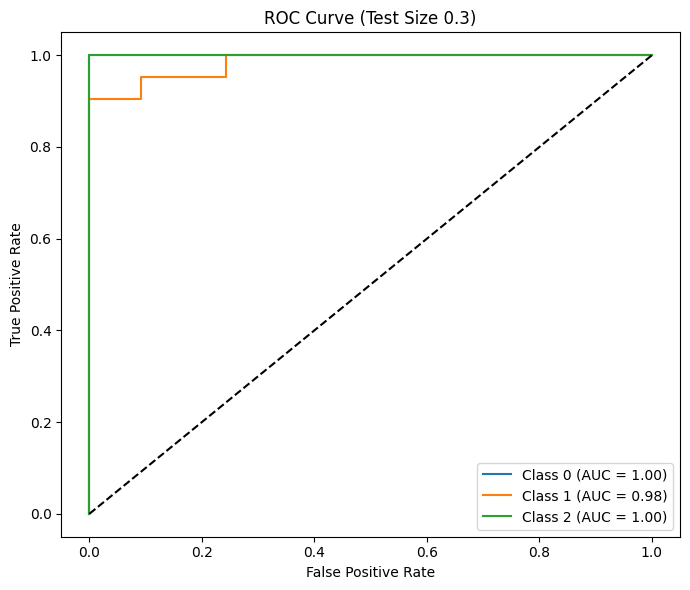


Running RandomForestClassifier with Test Size 0.4 and PCA n_components=5...
Accuracy: 0.9583333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       1.00      0.90      0.95        29
           2       0.95      1.00      0.97        19

    accuracy                           0.96        72
   macro avg       0.96      0.97      0.96        72
weighted avg       0.96      0.96      0.96        72



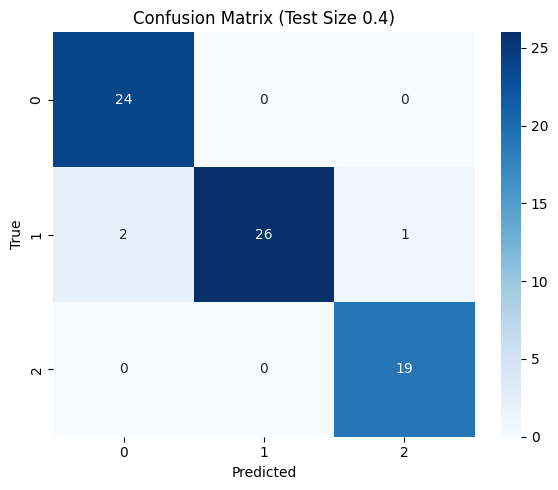

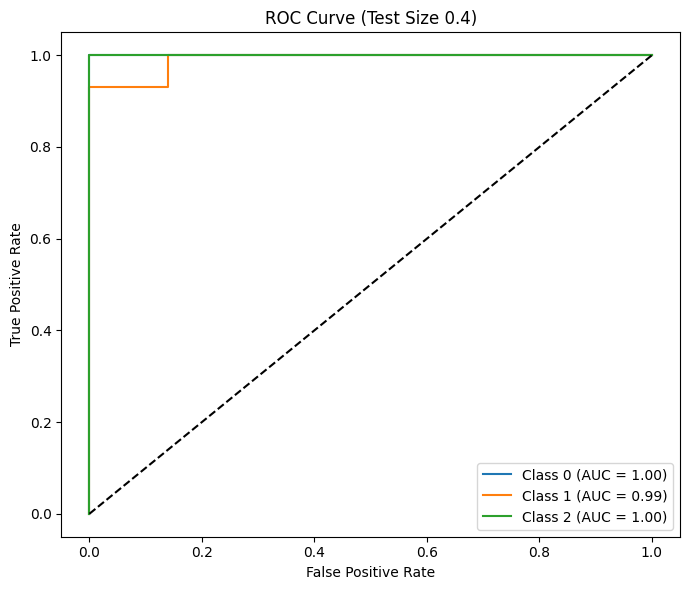


Running RandomForestClassifier with Test Size 0.5 and PCA n_components=5...
Accuracy: 0.9438202247191011
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92        30
           1       1.00      0.86      0.92        35
           2       1.00      1.00      1.00        24

    accuracy                           0.94        89
   macro avg       0.95      0.95      0.95        89
weighted avg       0.95      0.94      0.94        89



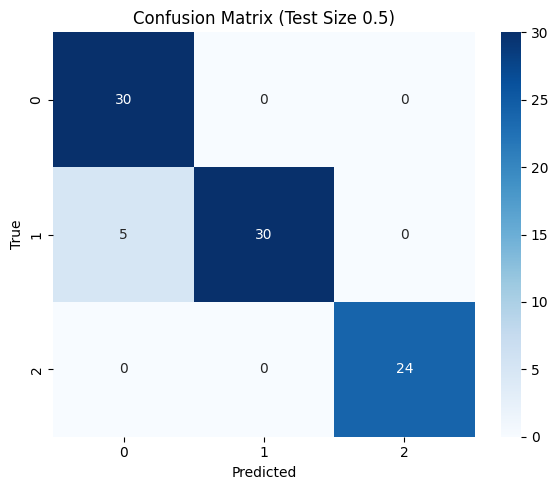

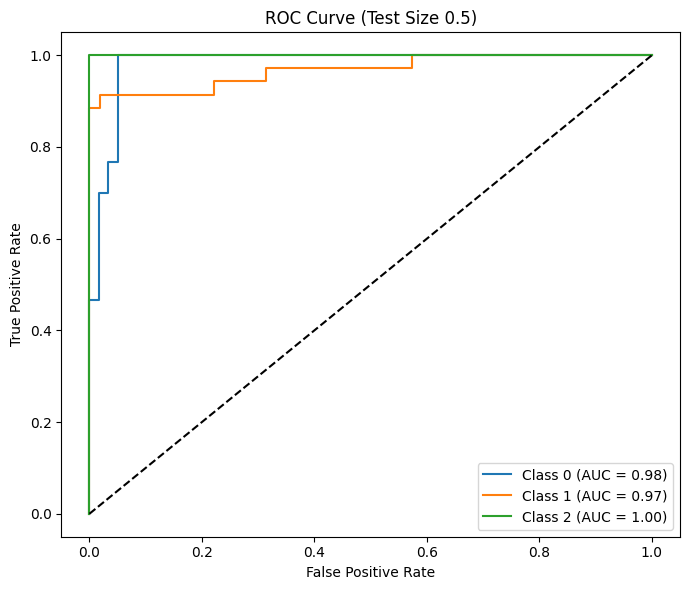


Plotting Accuracy Bar Graph Across All Test Sizes...


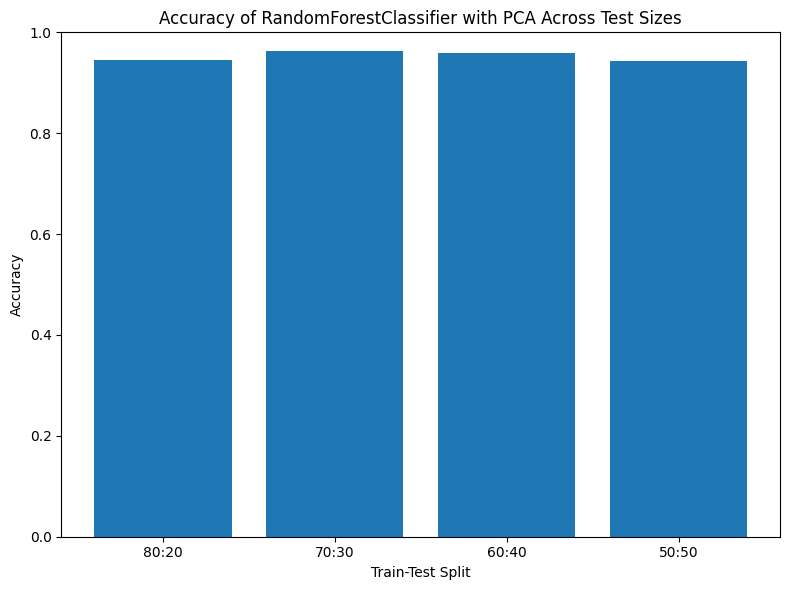

{0.2: {'accuracy': 0.9444444444444444,
  'confusion_matrix': array([[12,  0,  0],
         [ 2, 12,  0],
         [ 0,  0, 10]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.86      1.00      0.92        12\n           1       1.00      0.86      0.92        14\n           2       1.00      1.00      1.00        10\n\n    accuracy                           0.94        36\n   macro avg       0.95      0.95      0.95        36\nweighted avg       0.95      0.94      0.94        36\n',
  'Y_test': 7      0
  50     0
  133    2
  169    2
  129    1
  111    1
  56     0
  19     0
  162    2
  95     1
  10     0
  54     0
  130    2
  6      0
  31     0
  59     1
  112    1
  127    1
  177    2
  60     1
  92     1
  116    1
  122    1
  73     1
  67     1
  37     0
  155    2
  168    2
  137    2
  1      0
  93     1
  27     0
  147    2
  12     0
  128    1
  143    2
  Name: target, dtype: int64,
  'Y_pred': ar

In [62]:
random_forest_classifier_with_pca(
    X=wine_features,
    Y=wine_targets,  # or wine_targets.values.ravel()
    test_sizes=[0.2, 0.3, 0.4, 0.5],
    n_estimators=100,
    max_depth=5,
    random_state=2
)

# ***Handwritten Digit Dataset Fetching***

In [63]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
digit = fetch_ucirepo(id=80)

In [64]:
import pandas as pd
import numpy as np

# Convert features and targets into DataFrames
digit_features = pd.DataFrame(digit.data.features, columns=digit.data.feature_names)
digit_targets = pd.DataFrame(digit.data.targets, columns=digit.data.target_names)

# Optionally, combine features and target into a single DataFrame
digit_dataset = pd.concat([digit_features, digit_targets], axis=1)
digit_dataset.head()

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0           0           1           6          15          12           1   
1           0           0          10          16           6           0   
2           0           0           8          15          16          13   
3           0           0           0           3          11          16   
4           0           0           5          14           4           0   

   Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute56  \
0           0           0           0            7  ...            0   
1           0           0           0            7  ...            0   
2           0           0           0            1  ...            0   
3           0           0           0            0  ...            0   
4           0           0           0            0  ...            0   

   Attribute57  Attribute58  Attribute59  Attribute60  Attribute61  \
0            0            0            6           14            7   
1            0            0           10           16           15   
2            0            0            9           14            0   
3            0            0            0            1           15   
4            0            0            4           12           14   

   Attribute62  Attribute63  Attribute64  class  
0            1            0            0      0  
1            3            0            0      0  
2            0            0            0      7  
3            2            0            0      4  
4            7            0            0      6  

[5 rows x 65 columns]

In [65]:
#checking for null value
digit_dataset.isnull().sum()

Attribute1     0
Attribute2     0
Attribute3     0
Attribute4     0
Attribute5     0
              ..
Attribute61    0
Attribute62    0
Attribute63    0
Attribute64    0
class          0
Length: 65, dtype: int64

In [66]:
from sklearn.preprocessing import StandardScaler

# Step 1: Initialize the scaler
scaler = StandardScaler()

# Step 2: Fit the scaler on the features and transform
scaled_features = scaler.fit_transform(digit_features)
# Step 3: Convert scaled features back to DataFrame (to preserve column names)
digit_features_scaled = pd.DataFrame(scaled_features, columns=digit_features.columns)

# ***SVC Classifier***

In [67]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report,ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import numpy as np

# Load handwritten digits dataset
digits = load_digits()
X = digits.data
Y = digits.target

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


def svc_all_kernels(X, Y, kernels=['linear', 'poly', 'rbf', 'sigmoid'], test_sizes=[0.2, 0.3, 0.4, 0.5]):
    """
    Run SVC with different kernels across multiple test sizes on handwritten digits dataset.
    Show confusion matrix + metrics (Accuracy, Precision, Recall, F1).
    """

    results = {}

    for kernel in kernels:
        accuracies, precisions, recalls, f1s = [], [], [], []

        for test_size in test_sizes:
            print(f"\nRunning SVC with kernel='{kernel}' and test size={test_size}...")

            # Split data
            X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=test_size, random_state=42, stratify=Y)

            # Train model
            svc = SVC(kernel=kernel, C=1, random_state=42)
            svc.fit(X_train, Y_train)
            Y_pred = svc.predict(X_test)

            # Metrics
            accuracy = accuracy_score(Y_test, Y_pred)
            precision = precision_score(Y_test, Y_pred, average="weighted", zero_division=0)
            recall = recall_score(Y_test, Y_pred, average="weighted", zero_division=0)
            f1 = f1_score(Y_test, Y_pred, average="weighted", zero_division=0)
            cm = confusion_matrix(Y_test, Y_pred)
            class_report = classification_report(Y_test, Y_pred)

            # Save results
            results[(kernel, test_size)] = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "confusion_matrix": cm,
                "classification_report": class_report
            }

            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)

            # Print summary
            print("===================================================")
            print(f"Kernel: {kernel}, Test Size: {test_size}")
            print(f"Accuracy : {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall   : {recall:.4f}")
            print(f"F1-score : {f1:.4f}")
            print("Classification Report:\n", class_report)

            # Confusion Matrix plot
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
            disp.plot(cmap="Blues", values_format="d")
            plt.title(f"Confusion Matrix ({kernel}, test_size={test_size})")
            plt.show()

        # Plot metrics comparison for each kernel
        plt.figure(figsize=(8, 6))
        x = np.arange(len(test_sizes))
        width = 0.2
        plt.bar(x - 0.3, accuracies, width, label='Accuracy', edgecolor='black')
        plt.bar(x - 0.1, precisions, width, label='Precision', edgecolor='black')
        plt.bar(x + 0.1, recalls, width, label='Recall', edgecolor='black')
        plt.bar(x + 0.3, f1s, width, label='F1-score', edgecolor='black')

        plt.xticks(x, [f'{int(100*(1-size))}:{int(100*size)}' for size in test_sizes])
        plt.ylim(0, 1.05)
        plt.title(f'Metrics for {kernel} Kernel Across Test Sizes')
        plt.xlabel('Train-Test Split')
        plt.ylabel('Score')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return results






Running SVC with kernel='linear' and test size=0.2...
Kernel: linear, Test Size: 0.2
Accuracy : 0.9750
Precision: 0.9754
Recall   : 0.9750
F1-score : 0.9749
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.92      0.94      0.93        36
           2       1.00      1.00      1.00        35
           3       0.97      0.97      0.97        37
           4       1.00      1.00      1.00        36
           5       1.00      0.97      0.99        37
           6       1.00      1.00      1.00        36
           7       0.95      1.00      0.97        36
           8       0.97      0.89      0.93        35
           9       0.95      0.97      0.96        36

    accuracy                           0.97       360
   macro avg       0.98      0.97      0.97       360
weighted avg       0.98      0.97      0.97       360



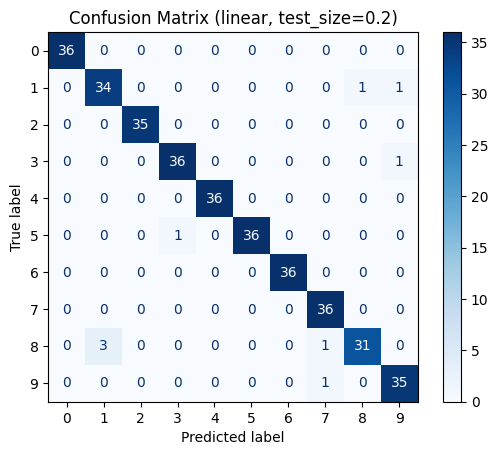


Running SVC with kernel='linear' and test size=0.3...
Kernel: linear, Test Size: 0.3
Accuracy : 0.9796
Precision: 0.9806
Recall   : 0.9796
F1-score : 0.9795
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.92      0.98      0.95        55
           2       1.00      1.00      1.00        53
           3       0.98      0.98      0.98        55
           4       1.00      1.00      1.00        54
           5       1.00      0.96      0.98        55
           6       0.98      0.98      0.98        54
           7       0.98      1.00      0.99        54
           8       1.00      0.88      0.94        52
           9       0.95      1.00      0.97        54

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540



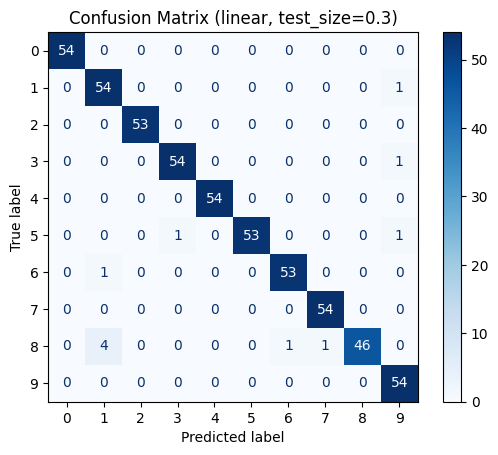


Running SVC with kernel='linear' and test size=0.4...
Kernel: linear, Test Size: 0.4
Accuracy : 0.9722
Precision: 0.9736
Recall   : 0.9722
F1-score : 0.9723
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       0.89      0.97      0.93        73
           2       1.00      0.97      0.99        71
           3       1.00      0.97      0.99        73
           4       1.00      1.00      1.00        72
           5       1.00      0.97      0.99        73
           6       0.99      0.99      0.99        72
           7       0.95      1.00      0.97        72
           8       0.98      0.89      0.93        70
           9       0.93      0.96      0.95        72

    accuracy                           0.97       719
   macro avg       0.97      0.97      0.97       719
weighted avg       0.97      0.97      0.97       719



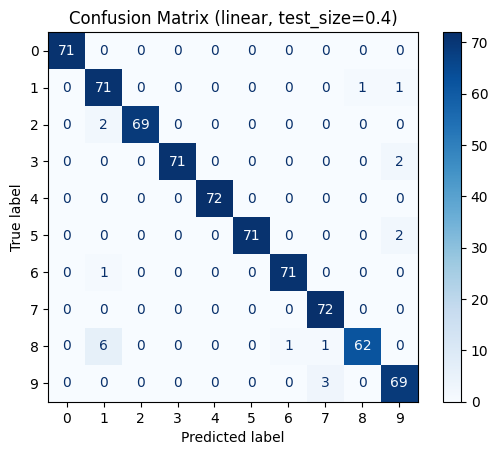


Running SVC with kernel='linear' and test size=0.5...
Kernel: linear, Test Size: 0.5
Accuracy : 0.9711
Precision: 0.9714
Recall   : 0.9711
F1-score : 0.9709
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.93      0.99      0.96        91
           2       0.99      0.99      0.99        88
           3       0.98      0.99      0.98        92
           4       0.99      1.00      0.99        91
           5       0.98      0.96      0.97        91
           6       0.99      0.99      0.99        91
           7       0.94      0.98      0.96        89
           8       0.96      0.92      0.94        87
           9       0.96      0.90      0.93        90

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899



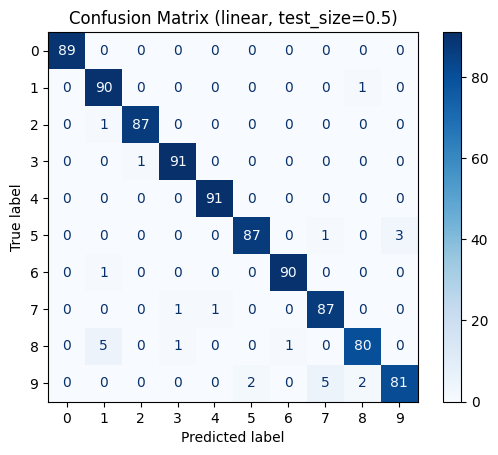

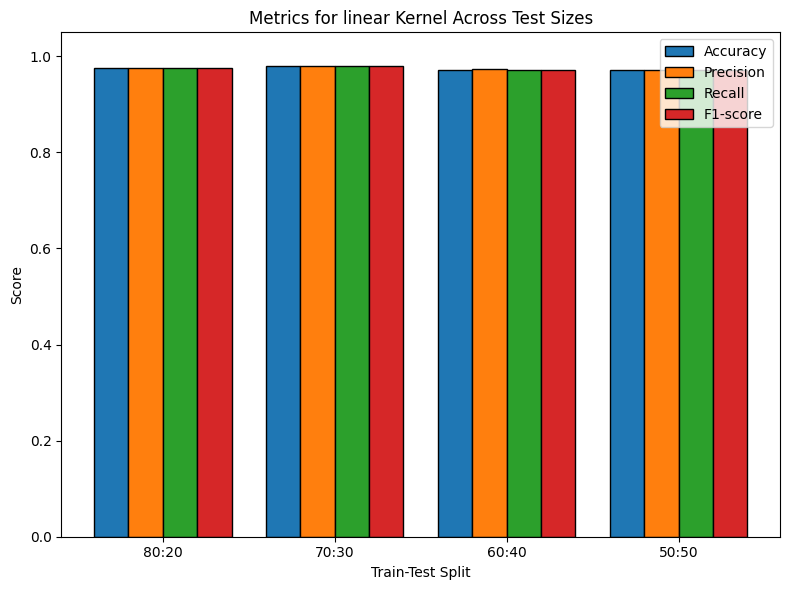


Running SVC with kernel='poly' and test size=0.2...
Kernel: poly, Test Size: 0.2
Accuracy : 0.9722
Precision: 0.9760
Recall   : 0.9722
F1-score : 0.9731
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.97      0.97      0.97        36
           2       1.00      0.97      0.99        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       1.00      1.00      1.00        37
           6       1.00      0.94      0.97        36
           7       1.00      0.97      0.99        36
           8       0.81      0.97      0.88        35
           9       1.00      0.92      0.96        36

    accuracy                           0.97       360
   macro avg       0.98      0.97      0.97       360
weighted avg       0.98      0.97      0.97       360



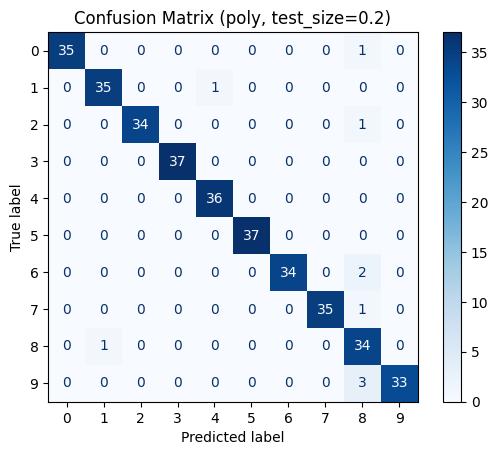


Running SVC with kernel='poly' and test size=0.3...
Kernel: poly, Test Size: 0.3
Accuracy : 0.9667
Precision: 0.9724
Recall   : 0.9667
F1-score : 0.9681
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        54
           1       0.98      0.98      0.98        55
           2       1.00      0.98      0.99        53
           3       1.00      0.96      0.98        55
           4       1.00      0.98      0.99        54
           5       1.00      0.95      0.97        55
           6       1.00      0.96      0.98        54
           7       1.00      0.98      0.99        54
           8       0.77      0.98      0.86        52
           9       0.96      0.93      0.94        54

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540



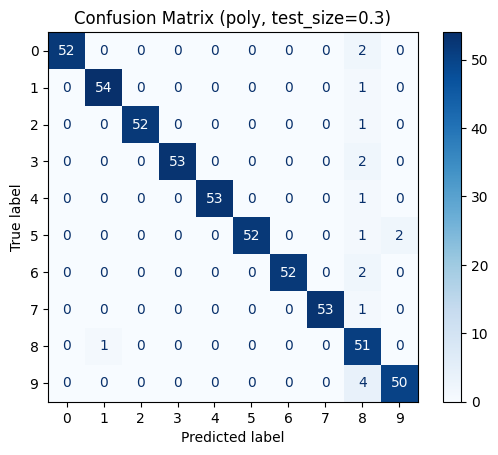


Running SVC with kernel='poly' and test size=0.4...
Kernel: poly, Test Size: 0.4
Accuracy : 0.9499
Precision: 0.9625
Recall   : 0.9499
F1-score : 0.9526
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        71
           1       0.97      0.99      0.98        73
           2       1.00      0.89      0.94        71
           3       1.00      0.96      0.98        73
           4       0.99      0.99      0.99        72
           5       1.00      0.95      0.97        73
           6       1.00      0.97      0.99        72
           7       1.00      0.97      0.99        72
           8       0.69      0.99      0.81        70
           9       0.97      0.83      0.90        72

    accuracy                           0.95       719
   macro avg       0.96      0.95      0.95       719
weighted avg       0.96      0.95      0.95       719



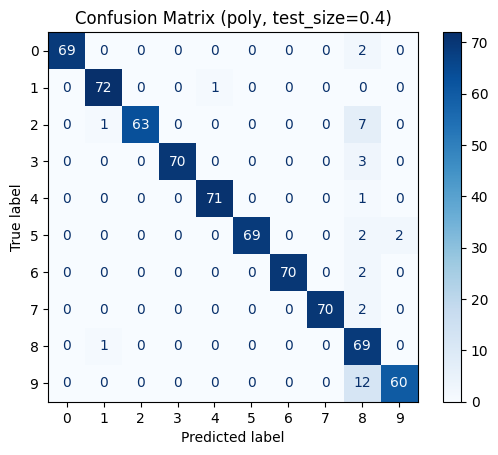


Running SVC with kernel='poly' and test size=0.5...
Kernel: poly, Test Size: 0.5
Accuracy : 0.9277
Precision: 0.9509
Recall   : 0.9277
F1-score : 0.9325
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        89
           1       0.97      0.99      0.98        91
           2       0.99      0.89      0.93        88
           3       1.00      0.87      0.93        92
           4       0.99      0.98      0.98        91
           5       0.98      0.89      0.93        91
           6       1.00      0.98      0.99        91
           7       1.00      0.97      0.98        89
           8       0.61      0.99      0.75        87
           9       0.97      0.76      0.85        90

    accuracy                           0.93       899
   macro avg       0.95      0.93      0.93       899
weighted avg       0.95      0.93      0.93       899



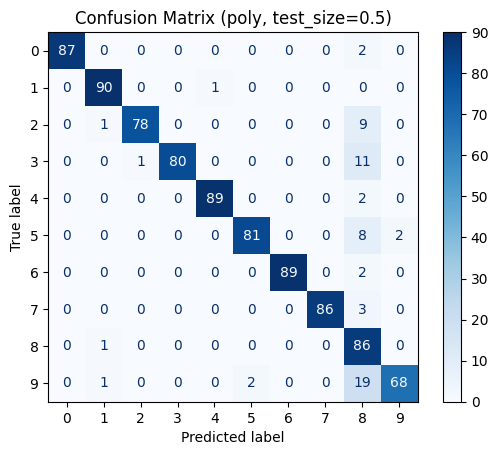

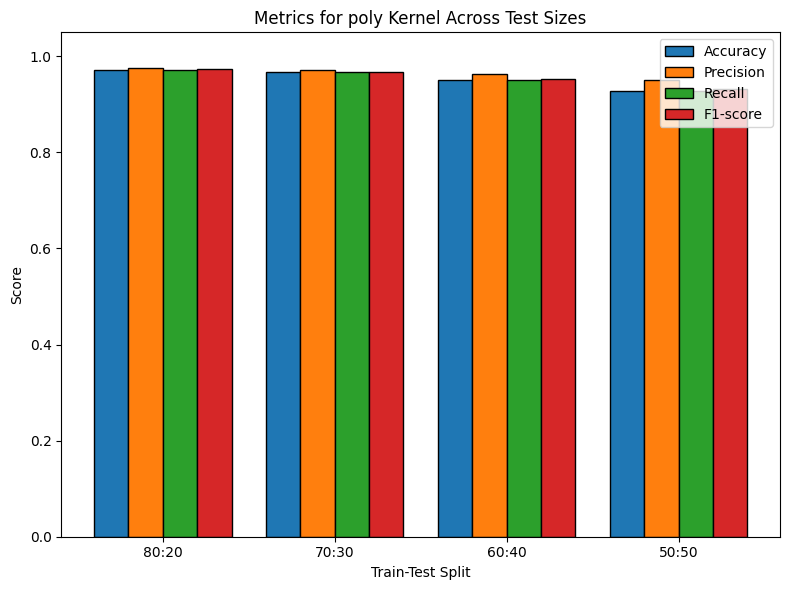


Running SVC with kernel='rbf' and test size=0.2...
Kernel: rbf, Test Size: 0.2
Accuracy : 0.9750
Precision: 0.9759
Recall   : 0.9750
F1-score : 0.9749
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      0.97      0.96        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.95      0.97      0.96        36
           5       0.97      1.00      0.99        37
           6       0.97      1.00      0.99        36
           7       0.92      0.97      0.95        36
           8       1.00      0.91      0.96        35
           9       1.00      0.92      0.96        36

    accuracy                           0.97       360
   macro avg       0.98      0.97      0.97       360
weighted avg       0.98      0.97      0.97       360



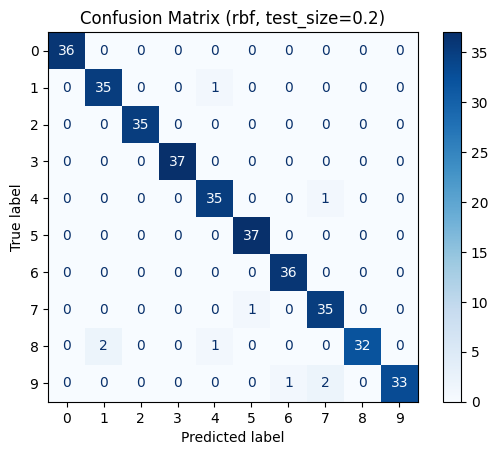


Running SVC with kernel='rbf' and test size=0.3...
Kernel: rbf, Test Size: 0.3
Accuracy : 0.9815
Precision: 0.9818
Recall   : 0.9815
F1-score : 0.9815
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.96      0.98      0.97        55
           2       1.00      0.98      0.99        53
           3       1.00      1.00      1.00        55
           4       0.95      0.98      0.96        54
           5       0.98      0.98      0.98        55
           6       0.98      1.00      0.99        54
           7       0.96      0.98      0.97        54
           8       1.00      0.94      0.97        52
           9       0.98      0.96      0.97        54

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540



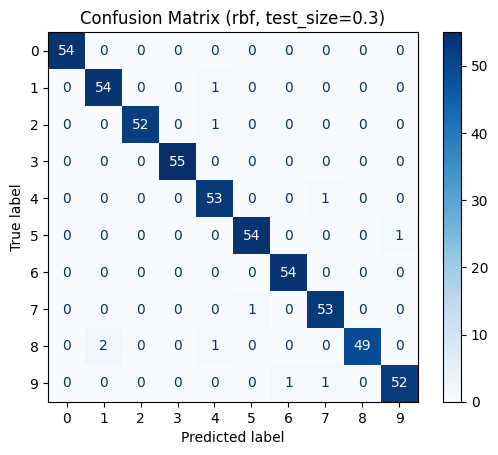


Running SVC with kernel='rbf' and test size=0.4...
Kernel: rbf, Test Size: 0.4
Accuracy : 0.9819
Precision: 0.9824
Recall   : 0.9819
F1-score : 0.9819
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       0.96      0.99      0.97        73
           2       1.00      0.94      0.97        71
           3       1.00      1.00      1.00        73
           4       0.95      0.99      0.97        72
           5       0.99      0.99      0.99        73
           6       0.99      1.00      0.99        72
           7       0.96      0.99      0.97        72
           8       1.00      0.96      0.98        70
           9       0.99      0.97      0.98        72

    accuracy                           0.98       719
   macro avg       0.98      0.98      0.98       719
weighted avg       0.98      0.98      0.98       719



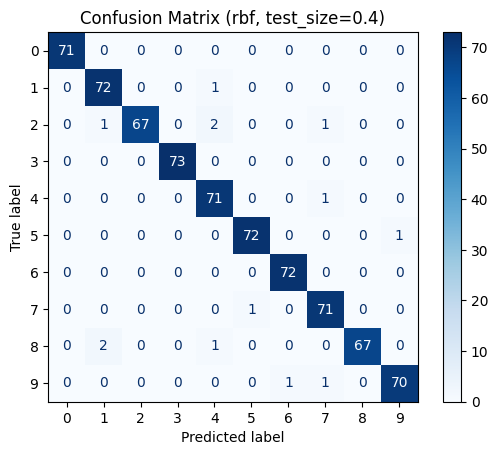


Running SVC with kernel='rbf' and test size=0.5...
Kernel: rbf, Test Size: 0.5
Accuracy : 0.9722
Precision: 0.9730
Recall   : 0.9722
F1-score : 0.9721
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.96      0.99      0.97        91
           2       1.00      0.95      0.98        88
           3       1.00      0.99      0.99        92
           4       0.97      0.97      0.97        91
           5       0.97      0.98      0.97        91
           6       0.99      0.99      0.99        91
           7       0.94      1.00      0.97        89
           8       0.92      0.97      0.94        87
           9       0.99      0.89      0.94        90

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899



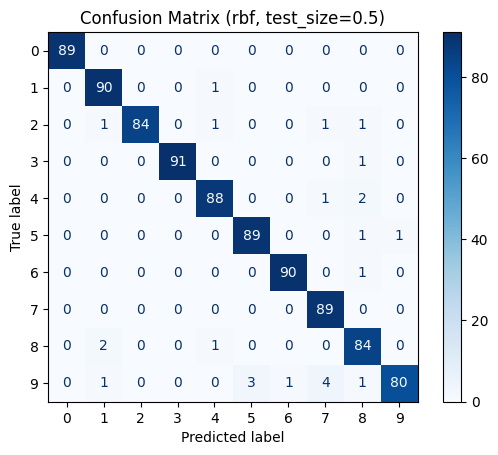

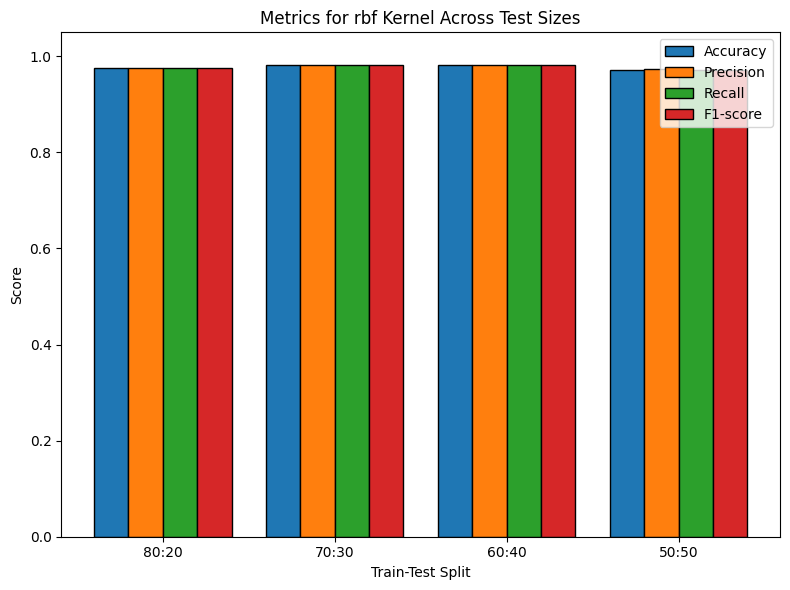


Running SVC with kernel='sigmoid' and test size=0.2...
Kernel: sigmoid, Test Size: 0.2
Accuracy : 0.9444
Precision: 0.9449
Recall   : 0.9444
F1-score : 0.9438
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.85      0.78      0.81        36
           2       0.88      1.00      0.93        35
           3       0.95      0.97      0.96        37
           4       0.97      1.00      0.99        36
           5       1.00      0.97      0.99        37
           6       1.00      1.00      1.00        36
           7       0.92      0.94      0.93        36
           8       0.97      0.89      0.93        35
           9       0.91      0.89      0.90        36

    accuracy                           0.94       360
   macro avg       0.94      0.94      0.94       360
weighted avg       0.94      0.94      0.94       360



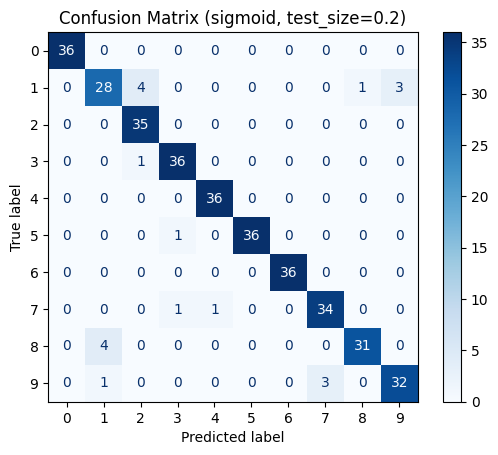


Running SVC with kernel='sigmoid' and test size=0.3...
Kernel: sigmoid, Test Size: 0.3
Accuracy : 0.9407
Precision: 0.9427
Recall   : 0.9407
F1-score : 0.9409
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.81      0.80      0.81        55
           2       0.83      0.94      0.88        53
           3       1.00      0.98      0.99        55
           4       0.98      0.98      0.98        54
           5       0.98      0.98      0.98        55
           6       1.00      1.00      1.00        54
           7       0.91      0.98      0.95        54
           8       0.98      0.87      0.92        52
           9       0.92      0.89      0.91        54

    accuracy                           0.94       540
   macro avg       0.94      0.94      0.94       540
weighted avg       0.94      0.94      0.94       540



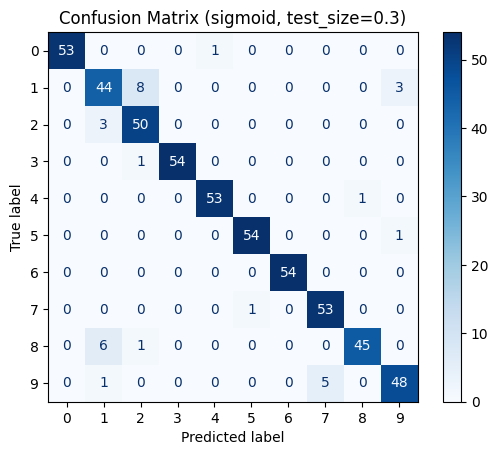


Running SVC with kernel='sigmoid' and test size=0.4...
Kernel: sigmoid, Test Size: 0.4
Accuracy : 0.9346
Precision: 0.9365
Recall   : 0.9346
F1-score : 0.9350
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        71
           1       0.79      0.79      0.79        73
           2       0.83      0.90      0.86        71
           3       0.99      0.97      0.98        73
           4       0.97      0.96      0.97        72
           5       0.97      0.97      0.97        73
           6       1.00      1.00      1.00        72
           7       0.90      0.97      0.93        72
           8       0.98      0.89      0.93        70
           9       0.93      0.90      0.92        72

    accuracy                           0.93       719
   macro avg       0.94      0.93      0.94       719
weighted avg       0.94      0.93      0.93       719



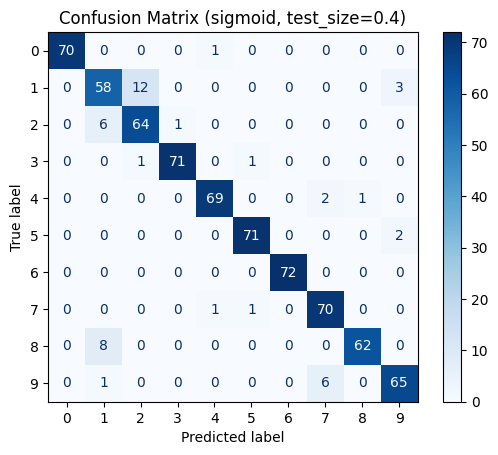


Running SVC with kernel='sigmoid' and test size=0.5...
Kernel: sigmoid, Test Size: 0.5
Accuracy : 0.9455
Precision: 0.9477
Recall   : 0.9455
F1-score : 0.9459
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        89
           1       0.82      0.87      0.84        91
           2       0.86      0.93      0.90        88
           3       1.00      0.95      0.97        92
           4       0.98      0.96      0.97        91
           5       0.97      0.99      0.98        91
           6       1.00      1.00      1.00        91
           7       0.92      0.99      0.95        89
           8       0.96      0.91      0.93        87
           9       0.96      0.88      0.92        90

    accuracy                           0.95       899
   macro avg       0.95      0.95      0.95       899
weighted avg       0.95      0.95      0.95       899



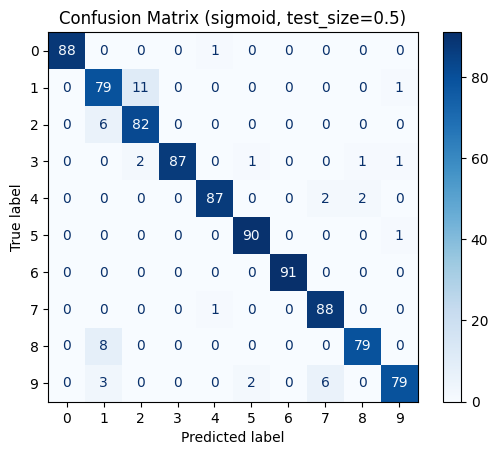

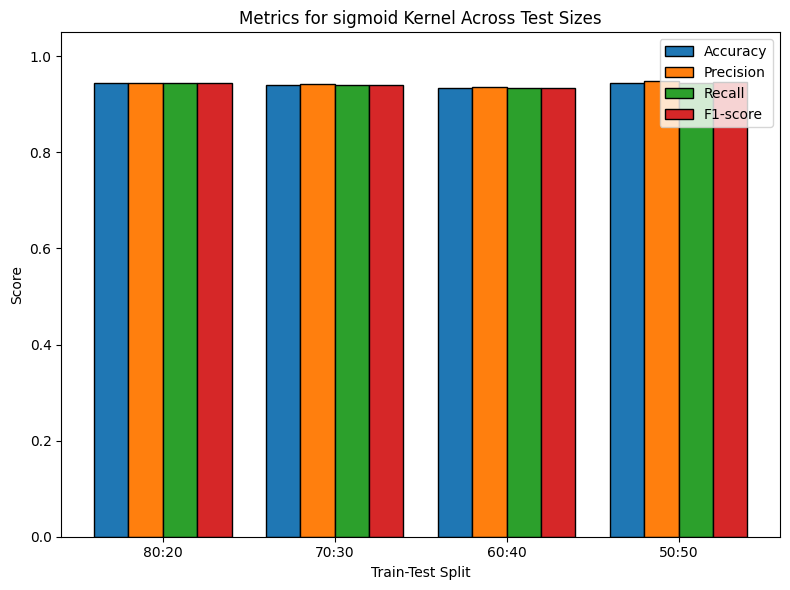

In [68]:
# Define kernels and test sizes
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
test_sizes = [0.2, 0.3, 0.4, 0.5]

# Run the function
results = svc_all_kernels(X_scaled, Y, kernels=kernels, test_sizes=test_sizes)

# ***MLP Classifier***

In [69]:
from sklearn.datasets import load_digits
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load handwritten digits dataset
digits = load_digits()
X = digits.data
Y = digits.target

# Standardize the data (important for MLP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


def mlp_classifier_all(X, Y, test_sizes=[0.2, 0.3, 0.4, 0.5],
                       momentum=0.9, max_iter=300, learning_rate='adaptive'):
    """
    Run MLPClassifier on handwritten digits dataset across multiple test sizes.
    Generates heatmap confusion matrices and training loss curves.
    """

    results = {}

    accuracies, precisions, recalls, f1s = [], [], [], []

    for test_size in test_sizes:
        print(f"\nRunning MLPClassifier with test size={test_size}...")

        # Split data
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=42, stratify=Y
        )

        # Train model
        mlp = MLPClassifier(
            hidden_layer_sizes=(100,),
            activation='relu',
            solver='sgd',
            momentum=momentum,
            learning_rate=learning_rate,
            max_iter=max_iter,
            random_state=42,
            verbose=False
        )
        mlp.fit(X_train, Y_train)
        Y_pred = mlp.predict(X_test)

        # Metrics
        accuracy = accuracy_score(Y_test, Y_pred)
        precision = precision_score(Y_test, Y_pred, average="weighted", zero_division=0)
        recall = recall_score(Y_test, Y_pred, average="weighted", zero_division=0)
        f1 = f1_score(Y_test, Y_pred, average="weighted", zero_division=0)
        cm = confusion_matrix(Y_test, Y_pred)
        class_report = classification_report(Y_test, Y_pred)

        # Save results
        results[test_size] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": cm,
            "classification_report": class_report,
            "loss_curve": mlp.loss_curve_
        }

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

        # Print summary
        print("===================================================")
        print(f"Test Size: {test_size}")
        print(f"Accuracy : {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall   : {recall:.4f}")
        print(f"F1-score : {f1:.4f}")
        print("Classification Report:\n", class_report)

        # --- Heatmap Confusion Matrix ---
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=digits.target_names, yticklabels=digits.target_names)
        plt.title(f"Confusion Matrix Heatmap (MLP, test_size={test_size})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # --- Training Loss Curve ---
        plt.figure(figsize=(6, 5))
        plt.plot(mlp.loss_curve_, marker='o')
        plt.title(f"Training Loss Curve (MLP, test_size={test_size})")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    # Plot metrics comparison
    plt.figure(figsize=(8, 6))
    x = np.arange(len(test_sizes))
    width = 0.2
    plt.bar(x - 0.3, accuracies, width, label='Accuracy', edgecolor='black')
    plt.bar(x - 0.1, precisions, width, label='Precision', edgecolor='black')
    plt.bar(x + 0.1, recalls, width, label='Recall', edgecolor='black')
    plt.bar(x + 0.3, f1s, width, label='F1-score', edgecolor='black')

    plt.xticks(x, [f'{int(100*(1-size))}:{int(100*size)}' for size in test_sizes])
    plt.ylim(0, 1.05)
    plt.title(f'MLP Metrics Across Test Sizes\n(momentum={momentum}, epochs={max_iter}, lr={learning_rate})')
    plt.xlabel('Train-Test Split')
    plt.ylabel('Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results





Running MLPClassifier with test size=0.2...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Size: 0.2
Accuracy : 0.9722
Precision: 0.9734
Recall   : 0.9722
F1-score : 0.9723
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.90      0.97      0.93        36
           2       0.97      1.00      0.99        35
           3       1.00      0.97      0.99        37
           4       0.92      0.97      0.95        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       0.97      1.00      0.99        36
           8       0.97      0.89      0.93        35
           9       1.00      0.97      0.99        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



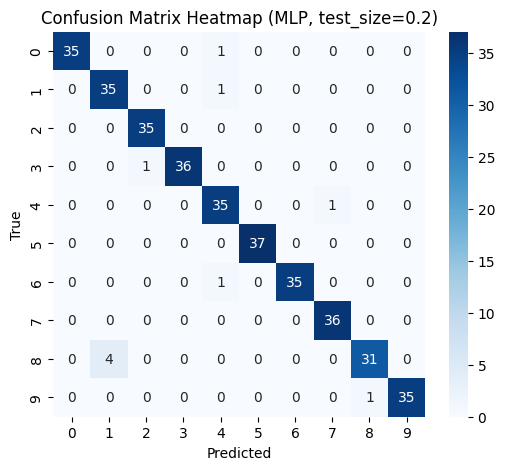

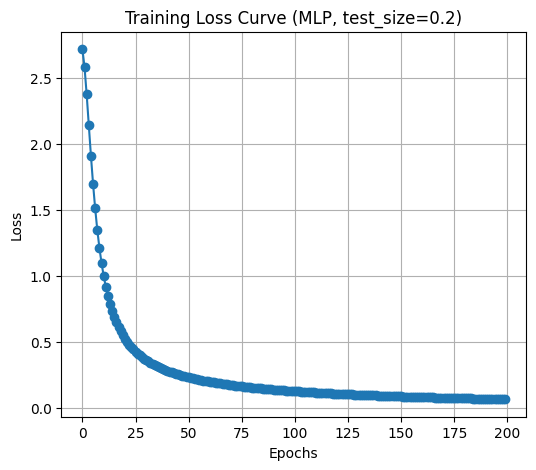


Running MLPClassifier with test size=0.3...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Size: 0.3
Accuracy : 0.9704
Precision: 0.9708
Recall   : 0.9704
F1-score : 0.9703
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.93      0.98      0.96        55
           2       0.98      0.98      0.98        53
           3       0.98      0.98      0.98        55
           4       0.96      0.94      0.95        54
           5       0.98      0.96      0.97        55
           6       1.00      0.98      0.99        54
           7       0.95      1.00      0.97        54
           8       0.96      0.90      0.93        52
           9       0.96      0.98      0.97        54

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540



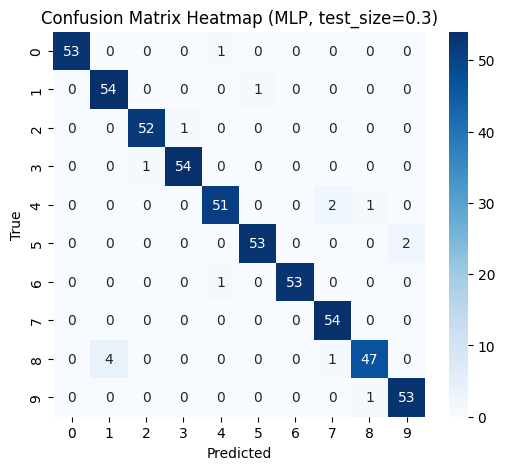

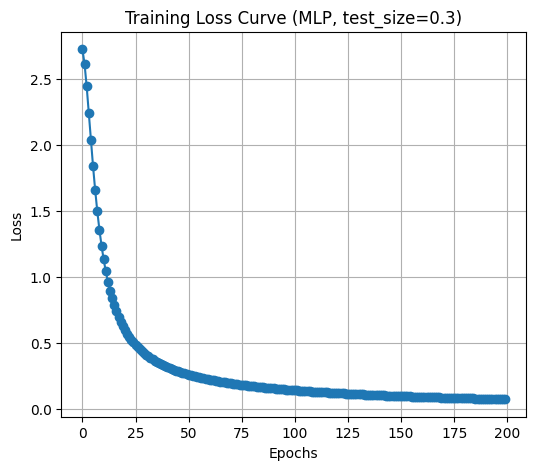


Running MLPClassifier with test size=0.4...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Size: 0.4
Accuracy : 0.9597
Precision: 0.9607
Recall   : 0.9597
F1-score : 0.9596
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        71
           1       0.91      0.97      0.94        73
           2       0.98      0.89      0.93        71
           3       0.97      0.99      0.98        73
           4       0.97      0.94      0.96        72
           5       0.99      0.97      0.98        73
           6       0.97      0.99      0.98        72
           7       0.92      1.00      0.96        72
           8       0.91      0.91      0.91        70
           9       0.97      0.94      0.96        72

    accuracy                           0.96       719
   macro avg       0.96      0.96      0.96       719
weighted avg       0.96      0.96      0.96       719



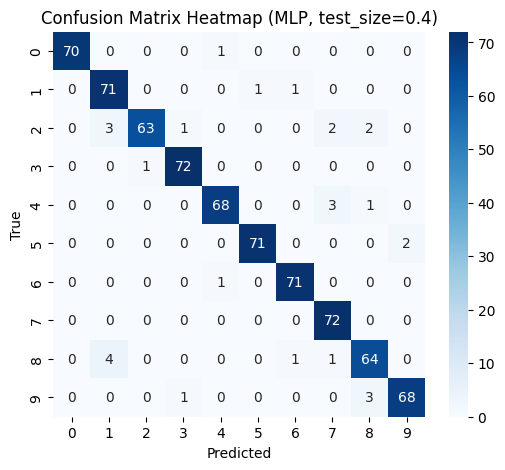

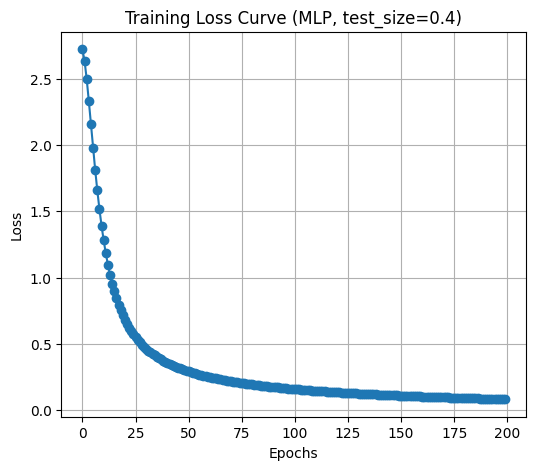


Running MLPClassifier with test size=0.5...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Size: 0.5
Accuracy : 0.9577
Precision: 0.9585
Recall   : 0.9577
F1-score : 0.9577
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        89
           1       0.91      0.98      0.94        91
           2       0.98      0.92      0.95        88
           3       0.97      0.97      0.97        92
           4       0.97      0.95      0.96        91
           5       0.97      0.97      0.97        91
           6       0.99      0.99      0.99        91
           7       0.93      1.00      0.96        89
           8       0.92      0.91      0.91        87
           9       0.96      0.91      0.94        90

    accuracy                           0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899



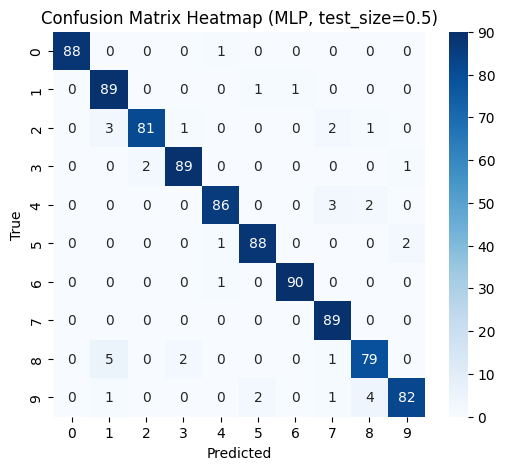

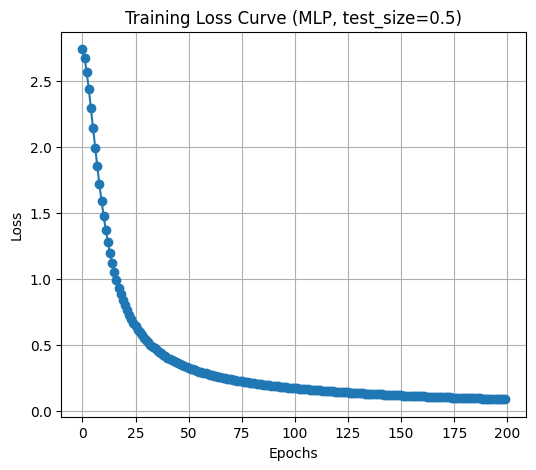

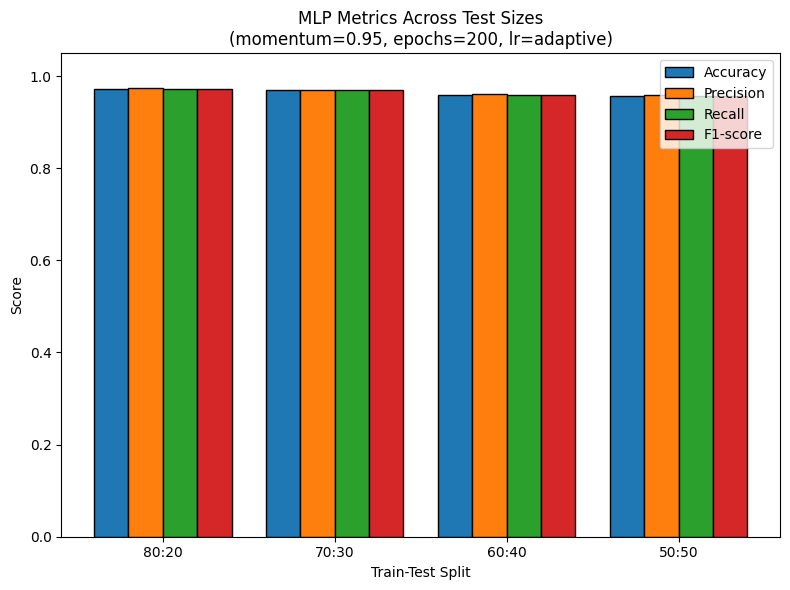

In [70]:
# Example run
test_sizes = [0.2, 0.3, 0.4, 0.5]
results = mlp_classifier_all(X_scaled, Y, test_sizes=test_sizes, momentum=0.95, max_iter=200, learning_rate='adaptive')


# ***Random Forest Classifier***

In [71]:
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load handwritten digits dataset
digits = load_digits()
X = digits.data
Y = digits.target


def random_forest_classifier_all(X, Y, test_sizes=[0.2, 0.3, 0.4, 0.5],
                                 n_estimators=100, max_depth=None, random_state=42):
    """
    Run RandomForestClassifier on handwritten digits dataset across multiple test sizes.
    Generates heatmap confusion matrices and feature importance plots.
    """

    results = {}
    accuracies, precisions, recalls, f1s = [], [], [], []

    for test_size in test_sizes:
        print(f"\nRunning RandomForestClassifier with test size={test_size}...")

        # Split data
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=random_state, stratify=Y
        )

        # Train model
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state
        )
        rf.fit(X_train, Y_train)
        Y_pred = rf.predict(X_test)

        # Metrics
        accuracy = accuracy_score(Y_test, Y_pred)
        precision = precision_score(Y_test, Y_pred, average="weighted", zero_division=0)
        recall = recall_score(Y_test, Y_pred, average="weighted", zero_division=0)
        f1 = f1_score(Y_test, Y_pred, average="weighted", zero_division=0)
        cm = confusion_matrix(Y_test, Y_pred)
        class_report = classification_report(Y_test, Y_pred)

        # Save results
        results[test_size] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": cm,
            "classification_report": class_report,
            "feature_importances": rf.feature_importances_
        }

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

        # Print summary
        print("===================================================")
        print(f"Test Size: {test_size}")
        print(f"Accuracy : {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall   : {recall:.4f}")
        print(f"F1-score : {f1:.4f}")
        print("Classification Report:\n", class_report)

        # --- Heatmap Confusion Matrix ---
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                    xticklabels=digits.target_names, yticklabels=digits.target_names)
        plt.title(f"Confusion Matrix Heatmap (Random Forest, test_size={test_size})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # --- Feature Importance Plot ---
        importances = rf.feature_importances_
        indices = np.argsort(importances)[-15:]  # Top 15 features
        plt.figure(figsize=(8, 5))
        plt.barh(range(len(indices)), importances[indices], align="center")
        plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
        plt.xlabel("Importance")
        plt.title(f"Top 15 Feature Importances (RF, test_size={test_size})")
        plt.tight_layout()
        plt.show()

    # Plot metrics comparison across test sizes
    plt.figure(figsize=(8, 6))
    x = np.arange(len(test_sizes))
    width = 0.2
    plt.bar(x - 0.3, accuracies, width, label='Accuracy', edgecolor='black')
    plt.bar(x - 0.1, precisions, width, label='Precision', edgecolor='black')
    plt.bar(x + 0.1, recalls, width, label='Recall', edgecolor='black')
    plt.bar(x + 0.3, f1s, width, label='F1-score', edgecolor='black')

    plt.xticks(x, [f'{int(100*(1-size))}:{int(100*size)}' for size in test_sizes])
    plt.ylim(0, 1.05)
    plt.title(f'Random Forest Metrics Across Test Sizes\n(n_estimators={n_estimators}, max_depth={max_depth})')
    plt.xlabel('Train-Test Split')
    plt.ylabel('Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results






Running RandomForestClassifier with test size=0.2...
Test Size: 0.2
Accuracy : 0.9639
Precision: 0.9644
Recall   : 0.9639
F1-score : 0.9636
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.92      0.97      0.95        36
           2       1.00      0.97      0.99        35
           3       0.97      0.97      0.97        37
           4       0.97      1.00      0.99        36
           5       0.97      1.00      0.99        37
           6       1.00      0.97      0.99        36
           7       0.92      1.00      0.96        36
           8       0.94      0.86      0.90        35
           9       0.97      0.92      0.94        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



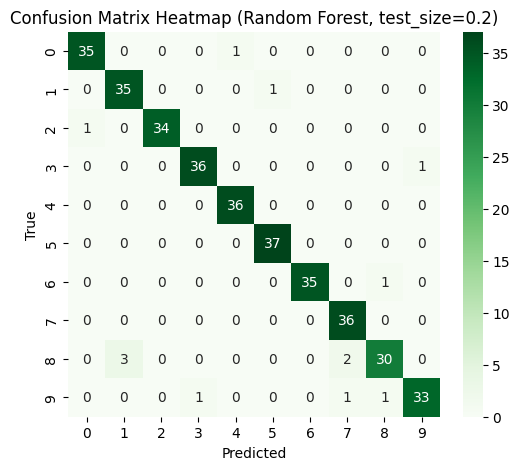

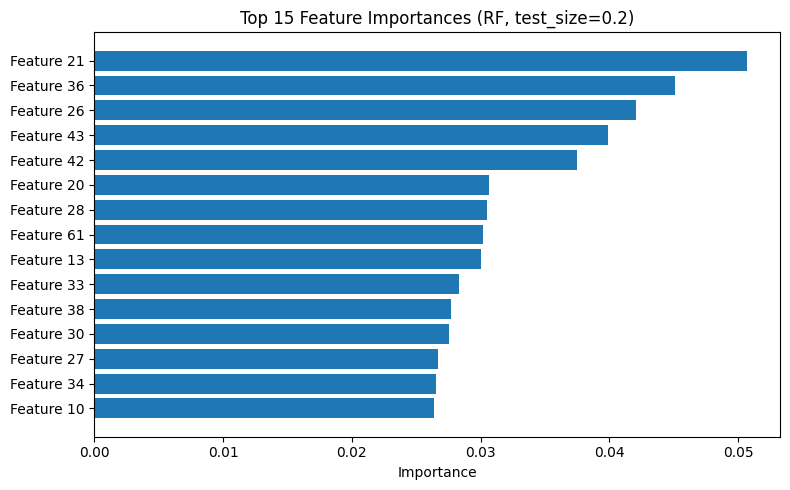


Running RandomForestClassifier with test size=0.3...
Test Size: 0.3
Accuracy : 0.9648
Precision: 0.9655
Recall   : 0.9648
F1-score : 0.9646
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        54
           1       0.93      1.00      0.96        55
           2       1.00      1.00      1.00        53
           3       0.96      0.96      0.96        55
           4       0.96      0.98      0.97        54
           5       1.00      0.98      0.99        55
           6       1.00      0.98      0.99        54
           7       0.92      1.00      0.96        54
           8       0.92      0.87      0.89        52
           9       0.96      0.91      0.93        54

    accuracy                           0.96       540
   macro avg       0.97      0.96      0.96       540
weighted avg       0.97      0.96      0.96       540



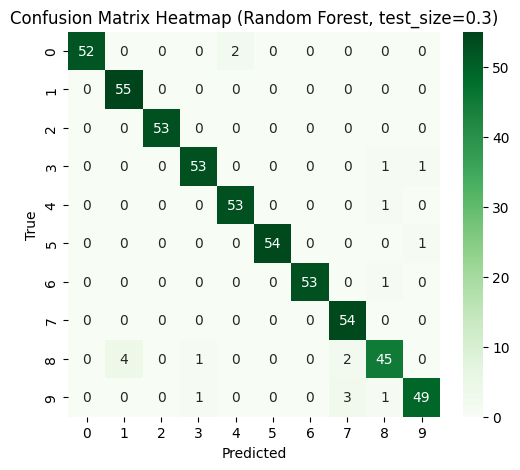

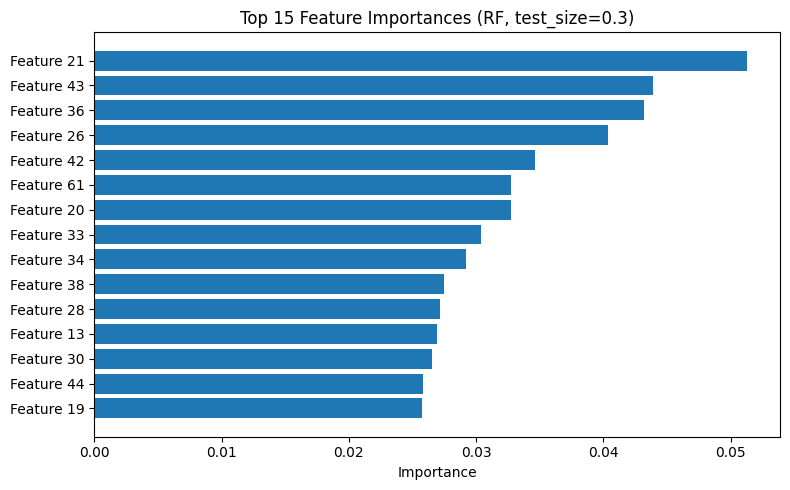


Running RandomForestClassifier with test size=0.4...
Test Size: 0.4
Accuracy : 0.9652
Precision: 0.9665
Recall   : 0.9652
F1-score : 0.9651
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.92      0.97      0.95        73
           2       1.00      0.96      0.98        71
           3       0.97      1.00      0.99        73
           4       0.97      0.99      0.98        72
           5       0.99      0.99      0.99        73
           6       0.99      0.99      0.99        72
           7       0.90      1.00      0.95        72
           8       0.95      0.90      0.93        70
           9       0.98      0.89      0.93        72

    accuracy                           0.97       719
   macro avg       0.97      0.96      0.97       719
weighted avg       0.97      0.97      0.97       719



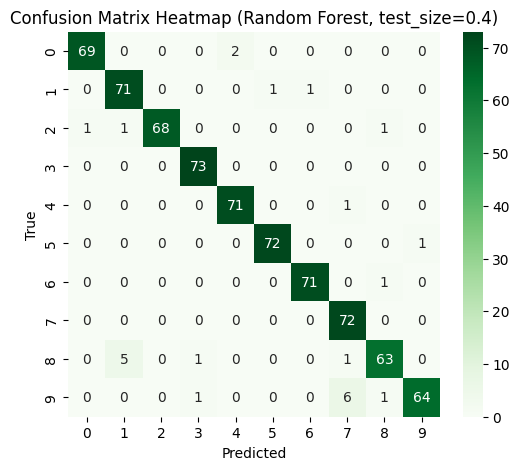

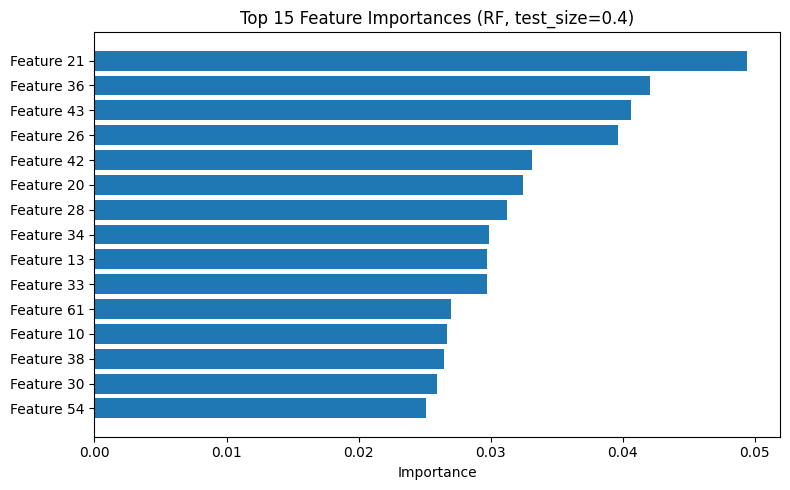


Running RandomForestClassifier with test size=0.5...
Test Size: 0.5
Accuracy : 0.9611
Precision: 0.9623
Recall   : 0.9611
F1-score : 0.9609
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        89
           1       0.94      0.99      0.96        91
           2       1.00      0.98      0.99        88
           3       0.97      0.96      0.96        92
           4       0.97      0.97      0.97        91
           5       0.96      0.98      0.97        91
           6       1.00      0.98      0.99        91
           7       0.89      1.00      0.94        89
           8       0.96      0.92      0.94        87
           9       0.96      0.87      0.91        90

    accuracy                           0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899



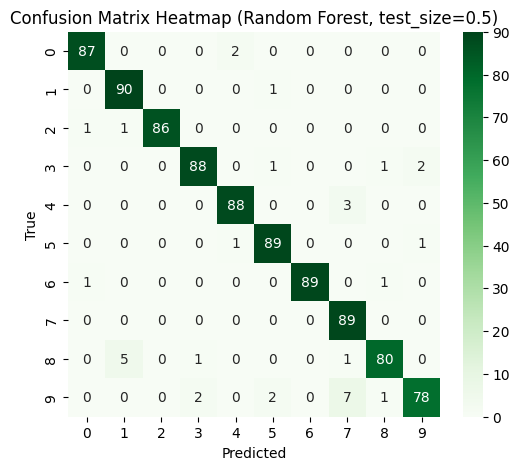

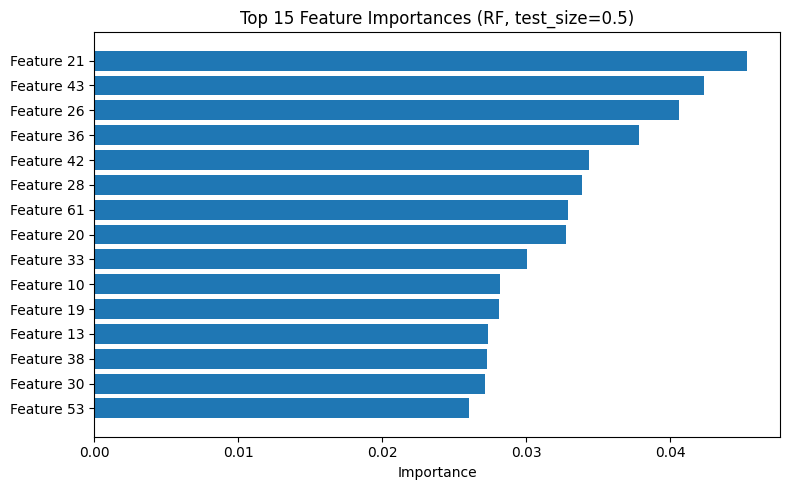

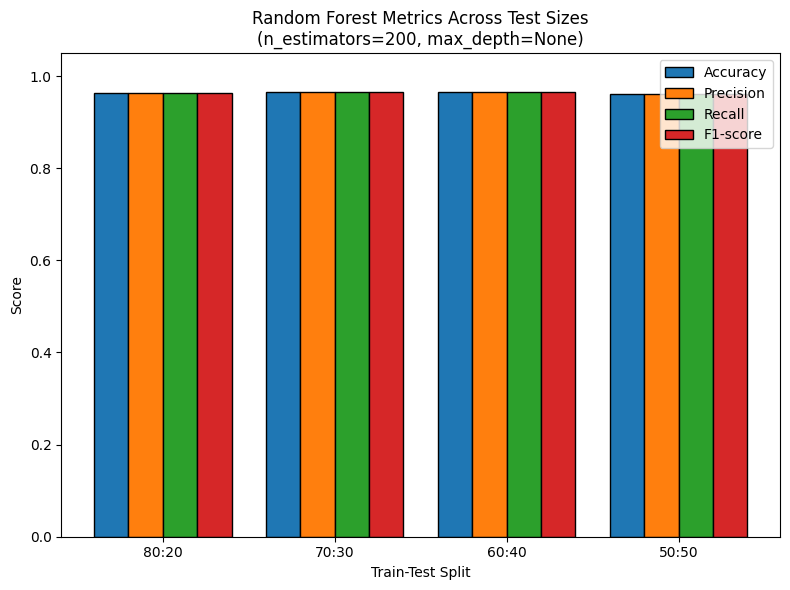

In [72]:
# Example run
test_sizes = [0.2, 0.3, 0.4, 0.5]
results_rf = random_forest_classifier_all(X, Y, test_sizes=test_sizes, n_estimators=200, max_depth=None)

# ***SVC With PCA***


Running SVC with kernel 'linear' and test size 0.2...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: linear, Test Size: 0.2
Accuracy : 0.8434
Precision: 0.8422
Recall   : 0.8434
F1-Score : 0.8415
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       110
           1       0.79      0.94      0.86       101
           2       0.91      0.88      0.90       118
           3       0.83      0.86      0.85       108
           4       0.94      0.89      0.91       120
           5       0.67      0.70      0.69       105
           6       0.97      0.97      0.97       118
           7       0.89      0.88      0.89       112
           8       0.67      0.55      0.61       107
           9       0.75      0.74      0.74       125

    accuracy                           0.84      1124
   macro avg       0.84      0.84      0.84      1124
weighted avg       0.84      0.84      0.84      1124



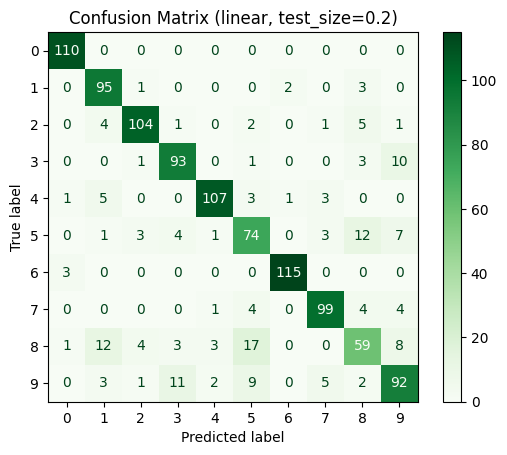


Running SVC with kernel 'linear' and test size 0.3...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: linear, Test Size: 0.3
Accuracy : 0.8375
Precision: 0.8345
Recall   : 0.8375
F1-Score : 0.8347
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       159
           1       0.80      0.93      0.86       164
           2       0.92      0.89      0.90       179
           3       0.81      0.89      0.85       167
           4       0.92      0.89      0.91       172
           5       0.70      0.70      0.70       164
           6       0.97      0.97      0.97       168
           7       0.88      0.87      0.88       159
           8       0.62      0.51      0.56       164
           9       0.76      0.74      0.75       190

    accuracy                           0.84      1686
   macro avg       0.83      0.84      0.84      1686
weighted avg       0.83      0.84      0.83      1686



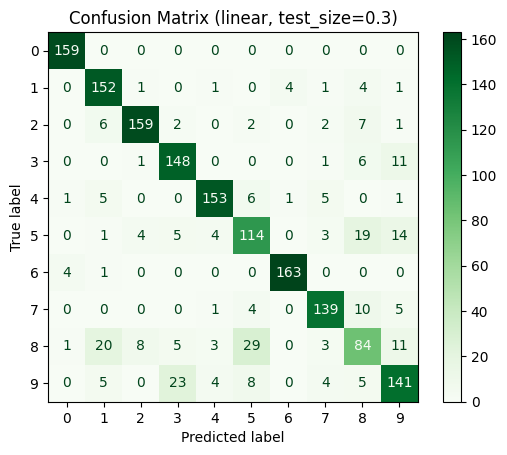


Running SVC with kernel 'linear' and test size 0.4...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: linear, Test Size: 0.4
Accuracy : 0.8403
Precision: 0.8376
Recall   : 0.8403
F1-Score : 0.8372
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       218
           1       0.82      0.93      0.88       230
           2       0.90      0.86      0.88       231
           3       0.82      0.89      0.85       223
           4       0.90      0.90      0.90       226
           5       0.68      0.71      0.69       218
           6       0.96      0.97      0.97       230
           7       0.89      0.90      0.90       203
           8       0.69      0.53      0.60       228
           9       0.76      0.75      0.75       241

    accuracy                           0.84      2248
   macro avg       0.84      0.84      0.84      2248
weighted avg       0.84      0.84      0.84      2248



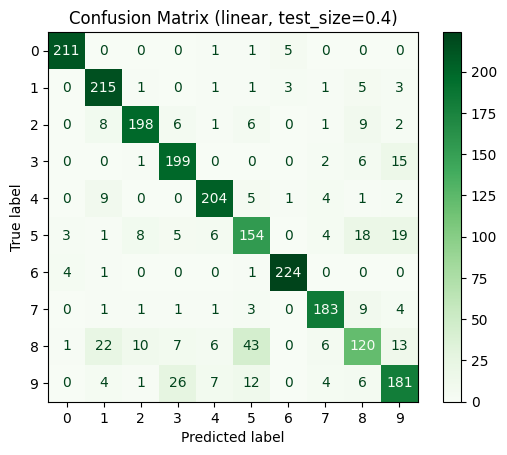


Running SVC with kernel 'linear' and test size 0.5...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: linear, Test Size: 0.5
Accuracy : 0.8278
Precision: 0.8240
Recall   : 0.8278
F1-Score : 0.8242
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       281
           1       0.83      0.91      0.87       283
           2       0.92      0.88      0.90       283
           3       0.81      0.86      0.84       273
           4       0.92      0.92      0.92       289
           5       0.67      0.65      0.66       280
           6       0.95      0.97      0.96       293
           7       0.83      0.89      0.86       251
           8       0.65      0.49      0.56       284
           9       0.69      0.74      0.72       293

    accuracy                           0.83      2810
   macro avg       0.82      0.83      0.82      2810
weighted avg       0.82      0.83      0.82      2810



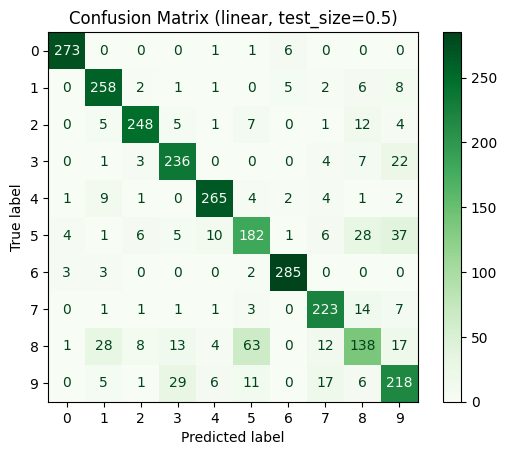


Accuracy, Precision, Recall, F1 across test sizes



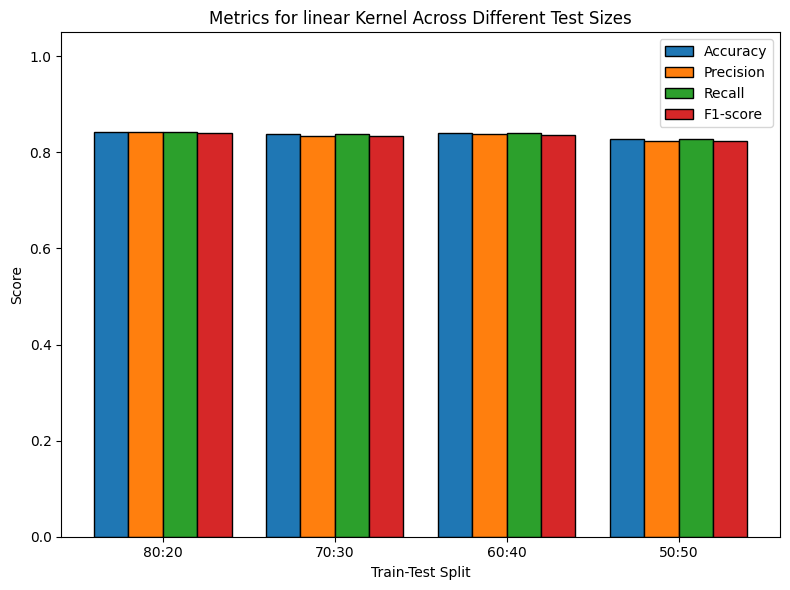


Running SVC with kernel 'poly' and test size 0.2...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: poly, Test Size: 0.2
Accuracy : 0.8514
Precision: 0.8677
Recall   : 0.8514
F1-Score : 0.8540
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       110
           1       0.90      0.94      0.92       101
           2       0.96      0.88      0.92       118
           3       0.94      0.85      0.89       108
           4       0.97      0.93      0.94       120
           5       0.66      0.47      0.55       105
           6       0.98      0.97      0.98       118
           7       0.89      0.87      0.88       112
           8       0.51      0.82      0.63       107
           9       0.84      0.78      0.81       125

    accuracy                           0.85      1124
   macro avg       0.86      0.85      0.85      1124
weighted avg       0.87      0.85      0.85      1124



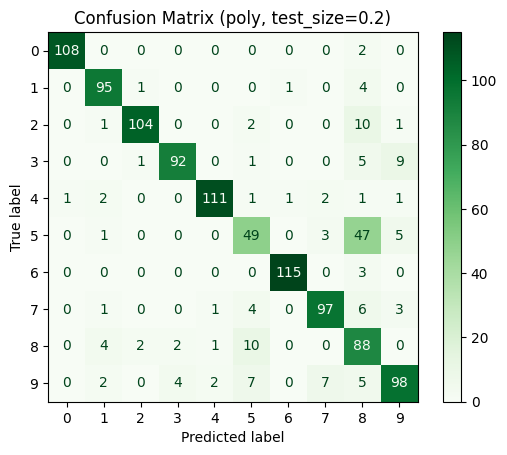


Running SVC with kernel 'poly' and test size 0.3...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: poly, Test Size: 0.3
Accuracy : 0.8405
Precision: 0.8608
Recall   : 0.8405
F1-Score : 0.8443
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       159
           1       0.87      0.92      0.90       164
           2       0.97      0.85      0.91       179
           3       0.91      0.86      0.88       167
           4       0.96      0.91      0.94       172
           5       0.69      0.48      0.56       164
           6       0.97      0.96      0.96       168
           7       0.90      0.87      0.89       159
           8       0.49      0.80      0.61       164
           9       0.85      0.79      0.82       190

    accuracy                           0.84      1686
   macro avg       0.86      0.84      0.84      1686
weighted avg       0.86      0.84      0.84      1686



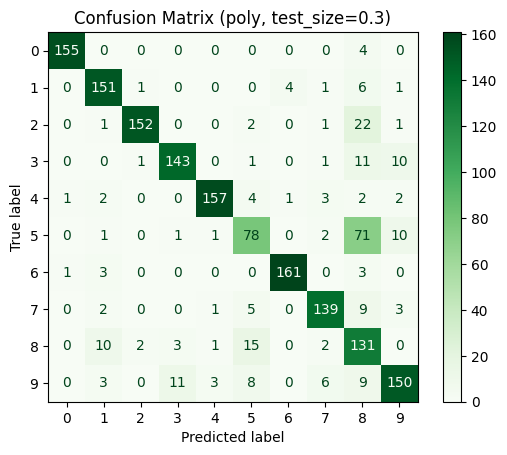


Running SVC with kernel 'poly' and test size 0.4...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: poly, Test Size: 0.4
Accuracy : 0.8430
Precision: 0.8637
Recall   : 0.8430
F1-Score : 0.8466
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       218
           1       0.91      0.92      0.92       230
           2       0.97      0.82      0.89       231
           3       0.93      0.85      0.89       223
           4       0.95      0.91      0.93       226
           5       0.70      0.50      0.58       218
           6       0.96      0.97      0.96       230
           7       0.89      0.84      0.87       203
           8       0.52      0.86      0.65       228
           9       0.81      0.79      0.80       241

    accuracy                           0.84      2248
   macro avg       0.86      0.84      0.85      2248
weighted avg       0.86      0.84      0.85      2248



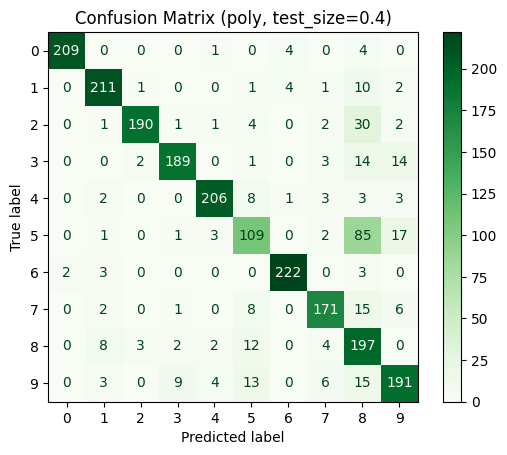


Running SVC with kernel 'poly' and test size 0.5...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: poly, Test Size: 0.5
Accuracy : 0.8324
Precision: 0.8562
Recall   : 0.8324
F1-Score : 0.8353
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       281
           1       0.91      0.93      0.92       283
           2       0.98      0.80      0.88       283
           3       0.92      0.85      0.89       273
           4       0.95      0.91      0.93       289
           5       0.73      0.45      0.56       280
           6       0.95      0.96      0.95       293
           7       0.85      0.86      0.85       251
           8       0.50      0.85      0.63       284
           9       0.79      0.76      0.77       293

    accuracy                           0.83      2810
   macro avg       0.86      0.83      0.84      2810
weighted avg       0.86      0.83      0.84      2810



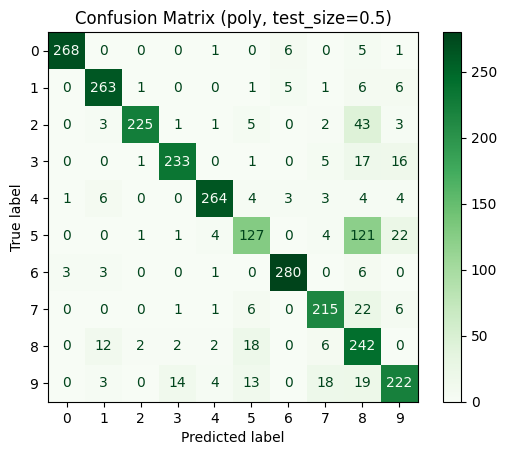


Accuracy, Precision, Recall, F1 across test sizes



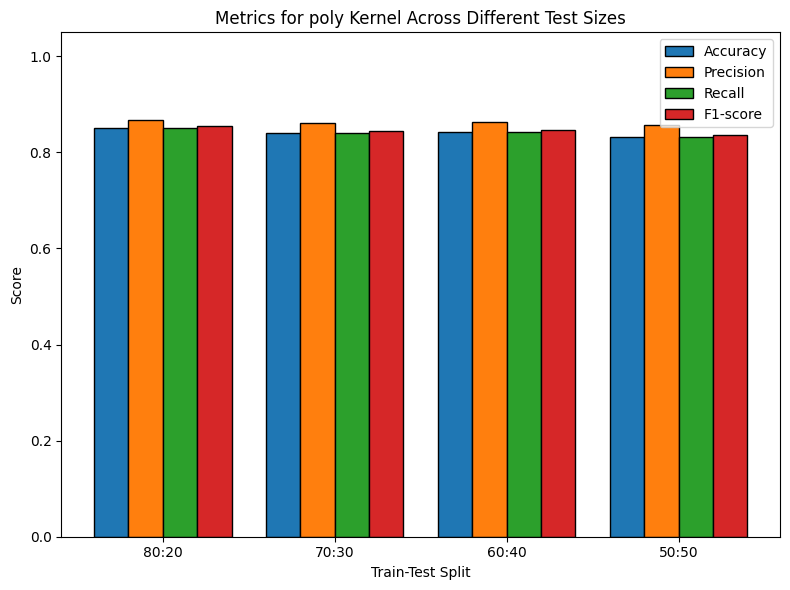


Running SVC with kernel 'rbf' and test size 0.2...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: rbf, Test Size: 0.2
Accuracy : 0.8799
Precision: 0.8794
Recall   : 0.8799
F1-Score : 0.8793
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       110
           1       0.89      0.95      0.92       101
           2       0.97      0.94      0.95       118
           3       0.90      0.87      0.88       108
           4       0.97      0.93      0.95       120
           5       0.75      0.76      0.75       105
           6       0.97      0.98      0.97       118
           7       0.84      0.88      0.86       112
           8       0.73      0.67      0.70       107
           9       0.80      0.80      0.80       125

    accuracy                           0.88      1124
   macro avg       0.88      0.88      0.88      1124
weighted avg       0.88      0.88      0.88      1124



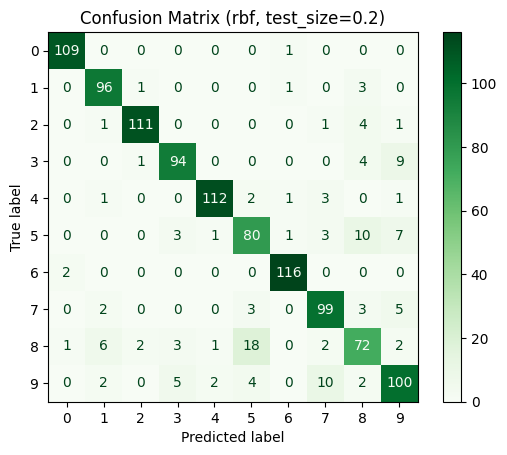


Running SVC with kernel 'rbf' and test size 0.3...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: rbf, Test Size: 0.3
Accuracy : 0.8695
Precision: 0.8694
Recall   : 0.8695
F1-Score : 0.8690
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       159
           1       0.87      0.94      0.90       164
           2       0.96      0.92      0.94       179
           3       0.88      0.89      0.88       167
           4       0.96      0.93      0.95       172
           5       0.71      0.76      0.74       164
           6       0.96      0.98      0.97       168
           7       0.85      0.87      0.86       159
           8       0.67      0.62      0.64       164
           9       0.84      0.80      0.82       190

    accuracy                           0.87      1686
   macro avg       0.87      0.87      0.87      1686
weighted avg       0.87      0.87      0.87      1686



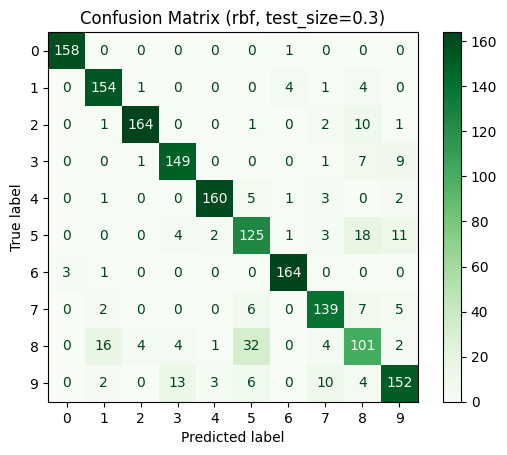


Running SVC with kernel 'rbf' and test size 0.4...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: rbf, Test Size: 0.4
Accuracy : 0.8728
Precision: 0.8730
Recall   : 0.8728
F1-Score : 0.8725
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       218
           1       0.90      0.96      0.93       230
           2       0.97      0.89      0.93       231
           3       0.89      0.88      0.89       223
           4       0.94      0.92      0.93       226
           5       0.73      0.74      0.74       218
           6       0.96      0.97      0.97       230
           7       0.86      0.90      0.88       203
           8       0.70      0.66      0.68       228
           9       0.80      0.83      0.82       241

    accuracy                           0.87      2248
   macro avg       0.87      0.87      0.87      2248
weighted avg       0.87      0.87      0.87      2248



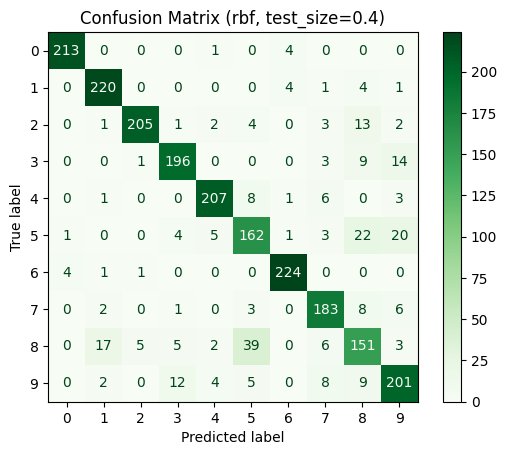


Running SVC with kernel 'rbf' and test size 0.5...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: rbf, Test Size: 0.5
Accuracy : 0.8601
Precision: 0.8598
Recall   : 0.8601
F1-Score : 0.8593
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       281
           1       0.88      0.95      0.92       283
           2       0.97      0.89      0.93       283
           3       0.88      0.88      0.88       273
           4       0.94      0.92      0.93       289
           5       0.71      0.72      0.72       280
           6       0.96      0.97      0.96       293
           7       0.80      0.90      0.85       251
           8       0.68      0.61      0.65       284
           9       0.78      0.78      0.78       293

    accuracy                           0.86      2810
   macro avg       0.86      0.86      0.86      2810
weighted avg       0.86      0.86      0.86      2810



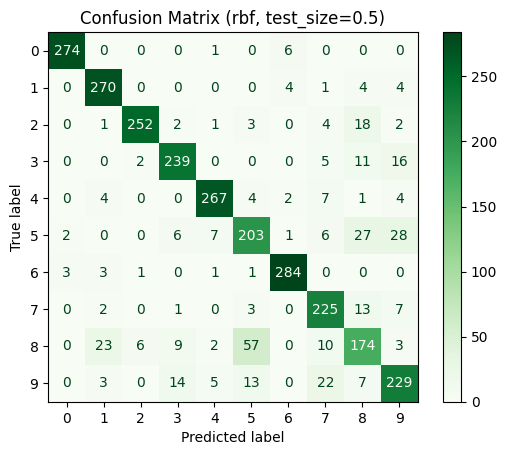


Accuracy, Precision, Recall, F1 across test sizes



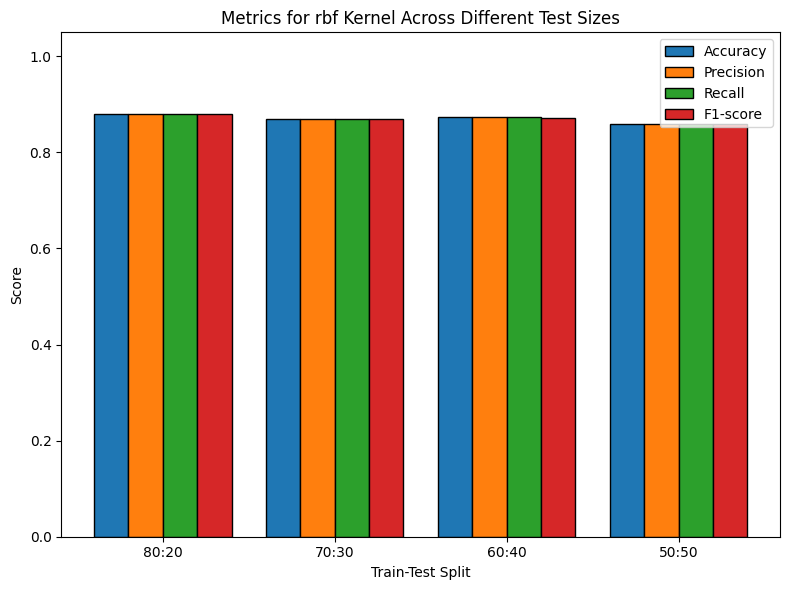


Running SVC with kernel 'sigmoid' and test size 0.2...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: sigmoid, Test Size: 0.2
Accuracy : 0.6423
Precision: 0.6468
Recall   : 0.6423
F1-Score : 0.6352
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.87       110
           1       0.50      0.70      0.58       101
           2       0.61      0.73      0.67       118
           3       0.74      0.76      0.75       108
           4       0.56      0.74      0.64       120
           5       0.57      0.45      0.50       105
           6       0.97      0.77      0.86       118
           7       0.59      0.72      0.65       112
           8       0.36      0.21      0.26       107
           9       0.64      0.47      0.54       125

    accuracy                           0.64      1124
   macro avg       0.64      0.64      0.63      1124
weighted avg       0.65      0.64      0.64      1124



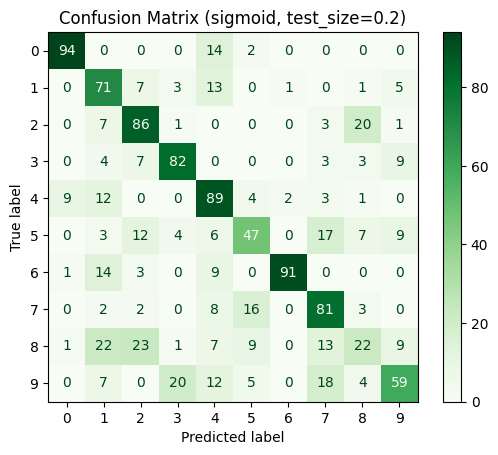


Running SVC with kernel 'sigmoid' and test size 0.3...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: sigmoid, Test Size: 0.3
Accuracy : 0.6340
Precision: 0.6325
Recall   : 0.6340
F1-Score : 0.6260
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       159
           1       0.54      0.68      0.60       164
           2       0.61      0.69      0.65       179
           3       0.75      0.72      0.74       167
           4       0.53      0.73      0.61       172
           5       0.57      0.42      0.48       164
           6       0.94      0.83      0.88       168
           7       0.58      0.73      0.65       159
           8       0.34      0.20      0.25       164
           9       0.59      0.48      0.53       190

    accuracy                           0.63      1686
   macro avg       0.63      0.64      0.63      1686
weighted avg       0.63      0.63      0.63      1686



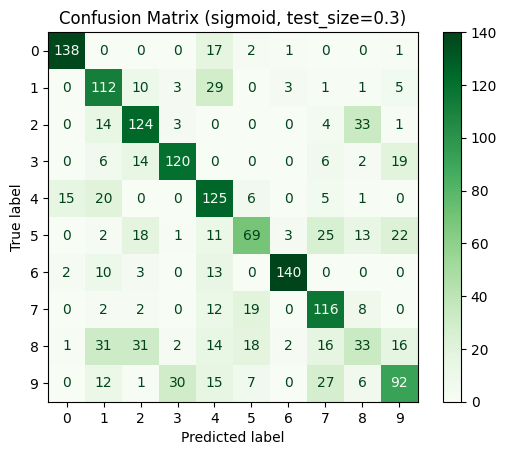


Running SVC with kernel 'sigmoid' and test size 0.4...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: sigmoid, Test Size: 0.4
Accuracy : 0.6250
Precision: 0.6202
Recall   : 0.6250
F1-Score : 0.6135
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89       218
           1       0.56      0.71      0.62       230
           2       0.59      0.69      0.64       231
           3       0.77      0.76      0.76       223
           4       0.55      0.68      0.61       226
           5       0.55      0.39      0.45       218
           6       0.95      0.79      0.86       230
           7       0.51      0.75      0.61       203
           8       0.28      0.14      0.18       228
           9       0.55      0.50      0.52       241

    accuracy                           0.62      2248
   macro avg       0.62      0.63      0.61      2248
weighted avg       0.62      0.62      0.61      2248



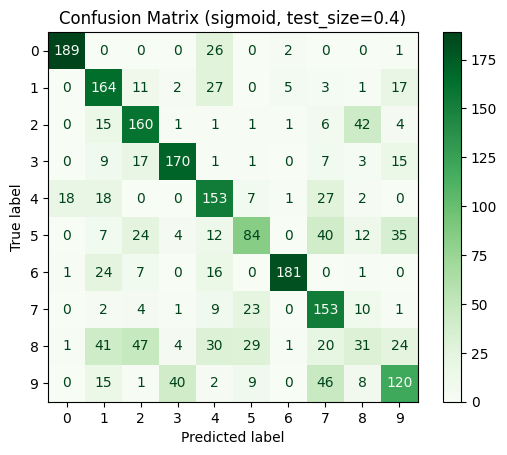


Running SVC with kernel 'sigmoid' and test size 0.5...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kernel: sigmoid, Test Size: 0.5
Accuracy : 0.6253
Precision: 0.6272
Recall   : 0.6253
F1-Score : 0.6150
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       281
           1       0.53      0.73      0.62       283
           2       0.56      0.72      0.63       283
           3       0.74      0.67      0.70       273
           4       0.63      0.62      0.62       289
           5       0.52      0.33      0.40       280
           6       0.93      0.77      0.84       293
           7       0.52      0.79      0.63       251
           8       0.40      0.21      0.28       284
           9       0.55      0.52      0.53       293

    accuracy                           0.63      2810
   macro avg       0.63      0.63      0.61      2810
weighted avg       0.63      0.63      0.61      2810



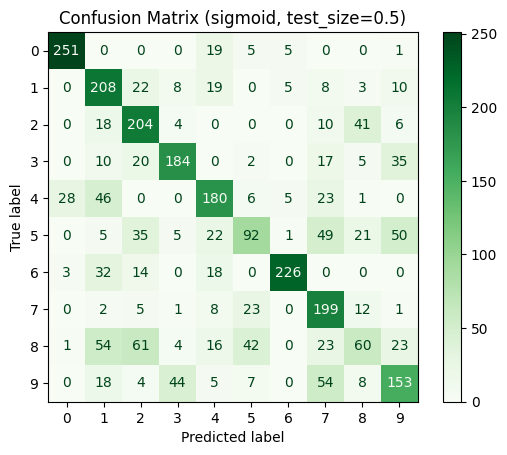


Accuracy, Precision, Recall, F1 across test sizes



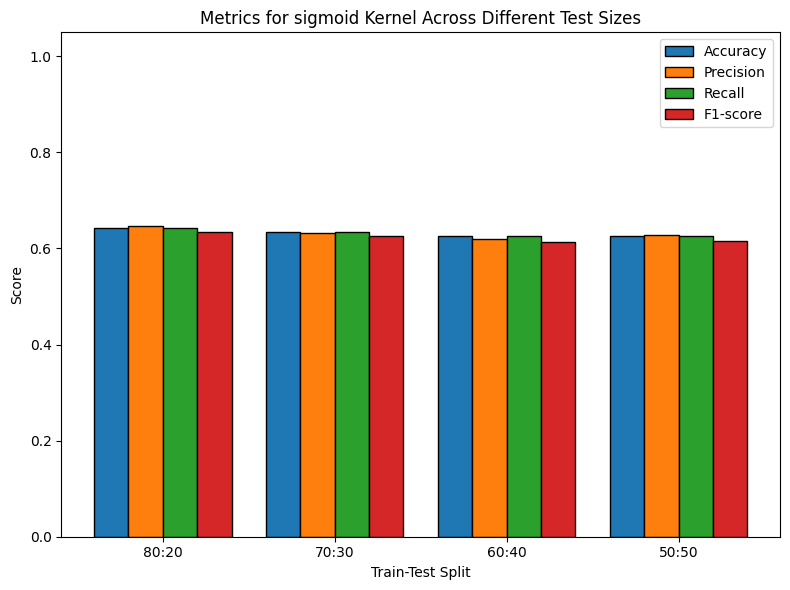

{('linear', 0.2): {'accuracy': 0.8434163701067615,
  'precision': 0.8422279224150334,
  'recall': 0.8434163701067615,
  'f1': 0.8414795922183413,
  'confusion_matrix': array([[110,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,  95,   1,   0,   0,   0,   2,   0,   3,   0],
         [  0,   4, 104,   1,   0,   2,   0,   1,   5,   1],
         [  0,   0,   1,  93,   0,   1,   0,   0,   3,  10],
         [  1,   5,   0,   0, 107,   3,   1,   3,   0,   0],
         [  0,   1,   3,   4,   1,  74,   0,   3,  12,   7],
         [  3,   0,   0,   0,   0,   0, 115,   0,   0,   0],
         [  0,   0,   0,   0,   1,   4,   0,  99,   4,   4],
         [  1,  12,   4,   3,   3,  17,   0,   0,  59,   8],
         [  0,   3,   1,  11,   2,   9,   0,   5,   2,  92]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.96      1.00      0.98       110\n           1       0.79      0.94      0.86       101\n           2       0.91    

In [73]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
test_sizes = [0.2, 0.3, 0.4, 0.5]

# Call the function to run SVC classifier for each kernel and test size
svc_classifier_with_pca(X=digit_features_scaled, Y=digit_targets, kernels=kernels, test_sizes=test_sizes)

# ***MLP Classifier With PCA***


Running MLPClassifier with Test Size 0.2 and PCA n_components=5...
Accuracy: 0.8505338078291815
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       111
           1       0.88      0.94      0.91       114
           2       0.94      0.91      0.93       111
           3       0.86      0.89      0.88       114
           4       0.95      0.93      0.94       114
           5       0.67      0.57      0.62       112
           6       0.98      0.97      0.98       112
           7       0.88      0.92      0.90       113
           8       0.59      0.61      0.60       111
           9       0.75      0.76      0.76       112

    accuracy                           0.85      1124
   macro avg       0.85      0.85      0.85      1124
weighted avg       0.85      0.85      0.85      1124



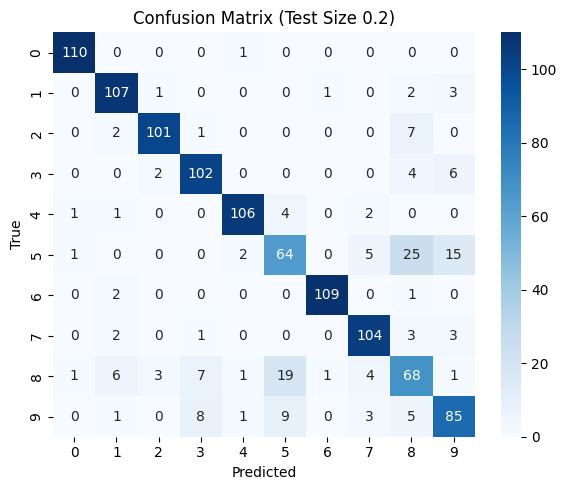

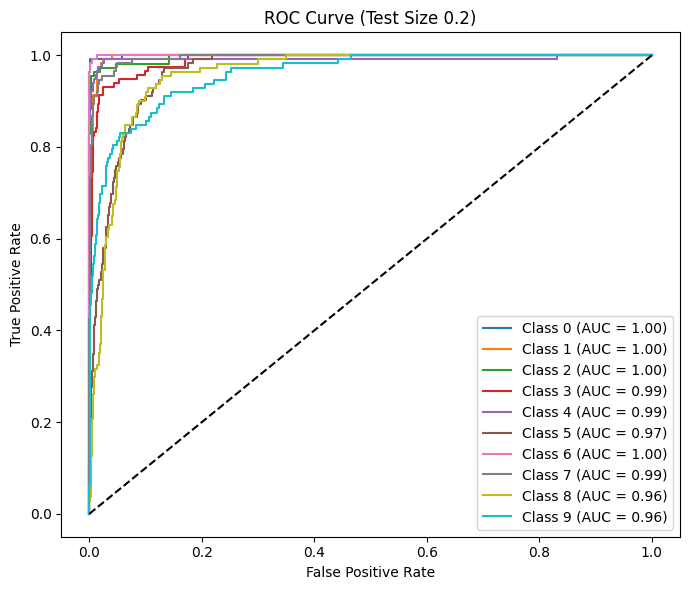


Running MLPClassifier with Test Size 0.3 and PCA n_components=5...
Accuracy: 0.8481613285883749
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       166
           1       0.90      0.92      0.91       171
           2       0.96      0.89      0.93       167
           3       0.82      0.89      0.85       172
           4       0.96      0.93      0.95       170
           5       0.68      0.64      0.66       168
           6       0.96      0.98      0.97       167
           7       0.84      0.91      0.88       170
           8       0.62      0.61      0.62       166
           9       0.74      0.73      0.74       169

    accuracy                           0.85      1686
   macro avg       0.85      0.85      0.85      1686
weighted avg       0.85      0.85      0.85      1686



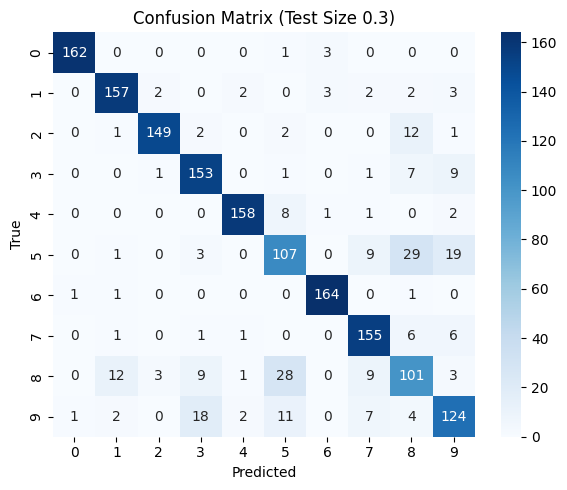

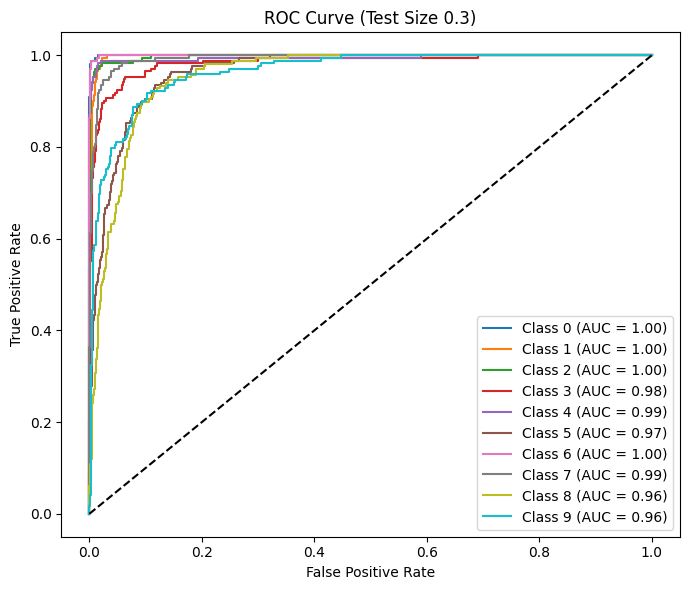


Running MLPClassifier with Test Size 0.4 and PCA n_components=5...
Accuracy: 0.8491992882562278
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       222
           1       0.90      0.91      0.90       228
           2       0.95      0.89      0.92       223
           3       0.84      0.90      0.86       229
           4       0.95      0.92      0.93       227
           5       0.66      0.70      0.68       223
           6       0.96      0.99      0.97       223
           7       0.82      0.93      0.87       226
           8       0.62      0.56      0.59       222
           9       0.81      0.74      0.77       225

    accuracy                           0.85      2248
   macro avg       0.85      0.85      0.85      2248
weighted avg       0.85      0.85      0.85      2248



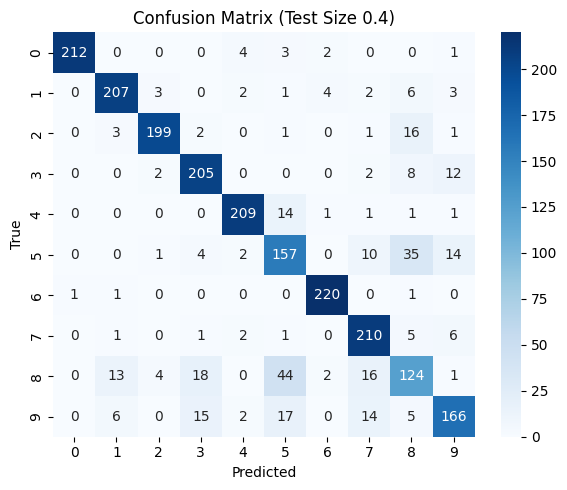

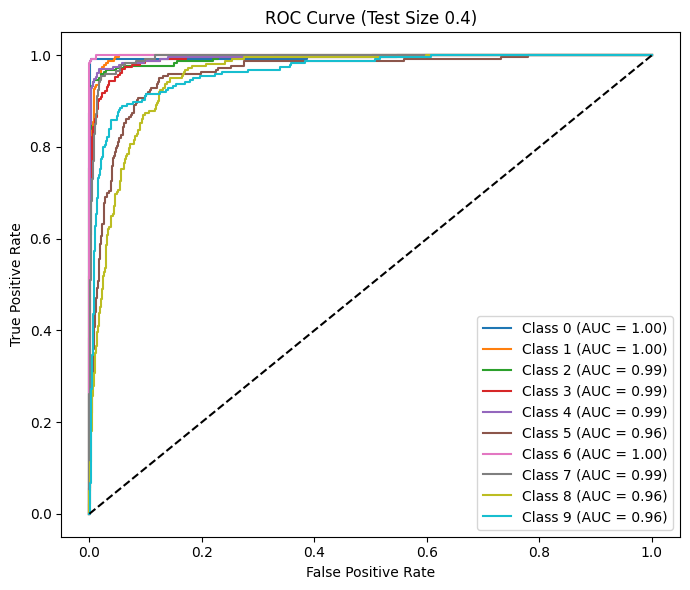


Running MLPClassifier with Test Size 0.5 and PCA n_components=5...
Accuracy: 0.8455516014234875
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       277
           1       0.90      0.91      0.90       286
           2       0.94      0.88      0.91       278
           3       0.84      0.88      0.86       286
           4       0.95      0.91      0.93       284
           5       0.66      0.70      0.67       279
           6       0.94      0.99      0.96       279
           7       0.80      0.92      0.85       283
           8       0.64      0.59      0.61       277
           9       0.81      0.72      0.76       281

    accuracy                           0.85      2810
   macro avg       0.85      0.85      0.84      2810
weighted avg       0.85      0.85      0.84      2810



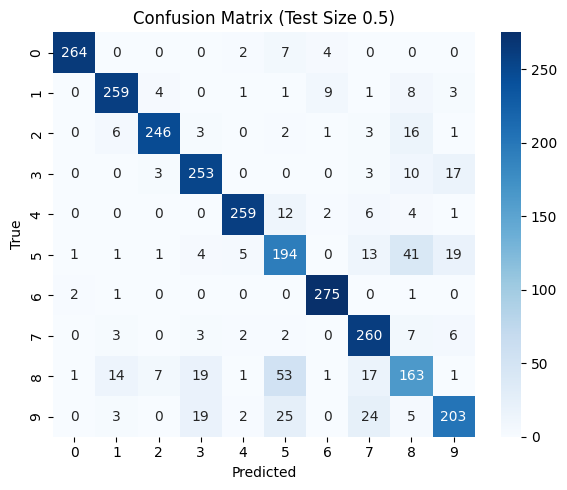

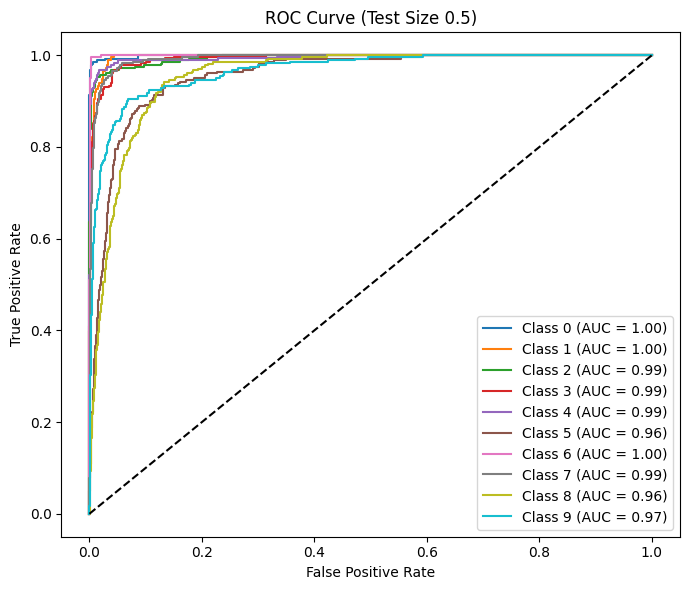


Plotting Accuracy Bar Graph Across All Test Sizes...


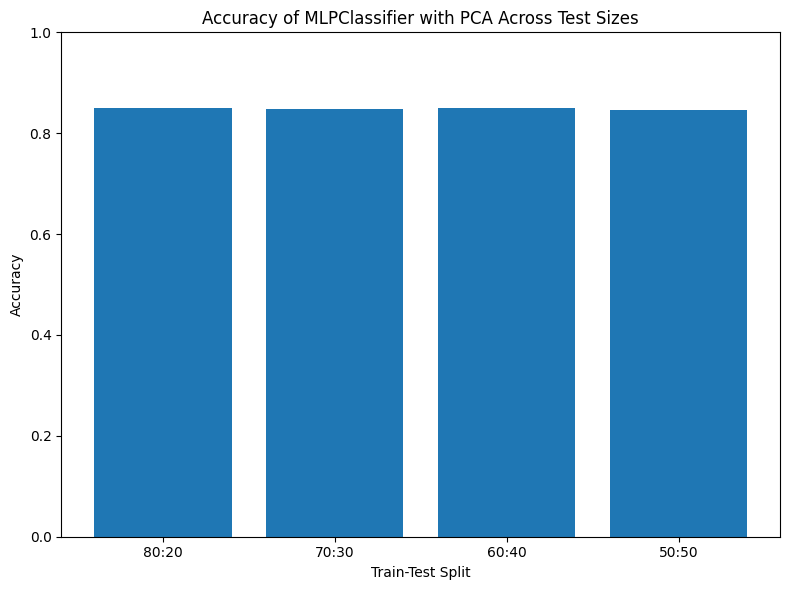

{0.2: {'accuracy': 0.8505338078291815,
  'confusion_matrix': array([[110,   0,   0,   0,   1,   0,   0,   0,   0,   0],
         [  0, 107,   1,   0,   0,   0,   1,   0,   2,   3],
         [  0,   2, 101,   1,   0,   0,   0,   0,   7,   0],
         [  0,   0,   2, 102,   0,   0,   0,   0,   4,   6],
         [  1,   1,   0,   0, 106,   4,   0,   2,   0,   0],
         [  1,   0,   0,   0,   2,  64,   0,   5,  25,  15],
         [  0,   2,   0,   0,   0,   0, 109,   0,   1,   0],
         [  0,   2,   0,   1,   0,   0,   0, 104,   3,   3],
         [  1,   6,   3,   7,   1,  19,   1,   4,  68,   1],
         [  0,   1,   0,   8,   1,   9,   0,   3,   5,  85]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.97      0.99      0.98       111\n           1       0.88      0.94      0.91       114\n           2       0.94      0.91      0.93       111\n           3       0.86      0.89      0.88       114\n           4       0.95 

In [74]:
mlp_classifier_with_pca(
    X=digit_features_scaled,
    Y=digit_targets,
    test_sizes=[0.2, 0.3, 0.4, 0.5],
    momentum=0.95,
    max_iter=1000,
    learning_rate='adaptive',
    n_components=5
)

# ***Random Forest Classifier With PCA***


Running RandomForestClassifier with Test Size 0.2 and PCA n_components=5...
Accuracy: 0.7864768683274022
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       111
           1       0.82      0.93      0.87       114
           2       0.87      0.86      0.86       111
           3       0.77      0.75      0.76       114
           4       0.98      0.88      0.93       114
           5       0.72      0.28      0.40       112
           6       0.97      0.93      0.95       112
           7       0.79      0.91      0.84       113
           8       0.45      0.64      0.53       111
           9       0.67      0.72      0.70       112

    accuracy                           0.79      1124
   macro avg       0.80      0.79      0.78      1124
weighted avg       0.80      0.79      0.78      1124



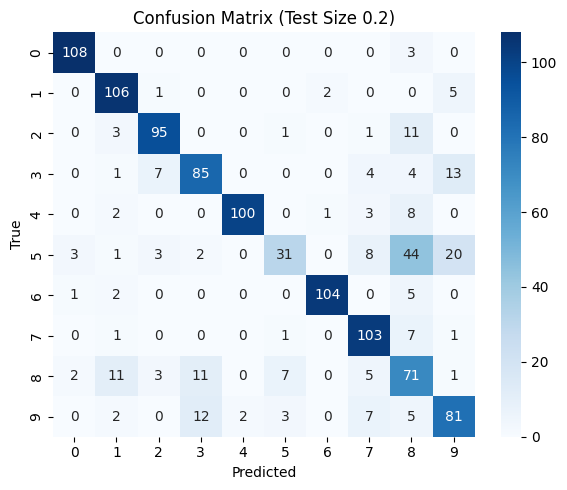

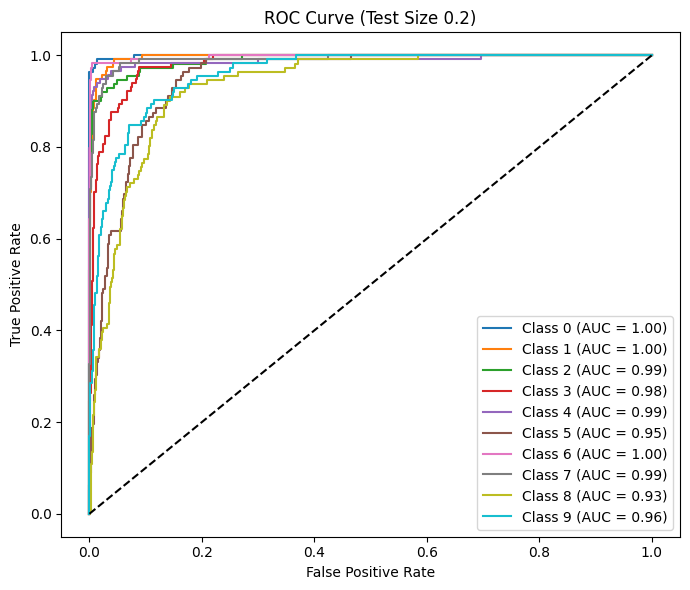


Running RandomForestClassifier with Test Size 0.3 and PCA n_components=5...
Accuracy: 0.7781731909845789
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       166
           1       0.81      0.94      0.87       171
           2       0.88      0.83      0.85       167
           3       0.78      0.72      0.75       172
           4       0.95      0.86      0.90       170
           5       0.77      0.30      0.44       168
           6       0.97      0.95      0.96       167
           7       0.73      0.91      0.81       170
           8       0.46      0.62      0.53       166
           9       0.64      0.70      0.67       169

    accuracy                           0.78      1686
   macro avg       0.79      0.78      0.77      1686
weighted avg       0.79      0.78      0.77      1686



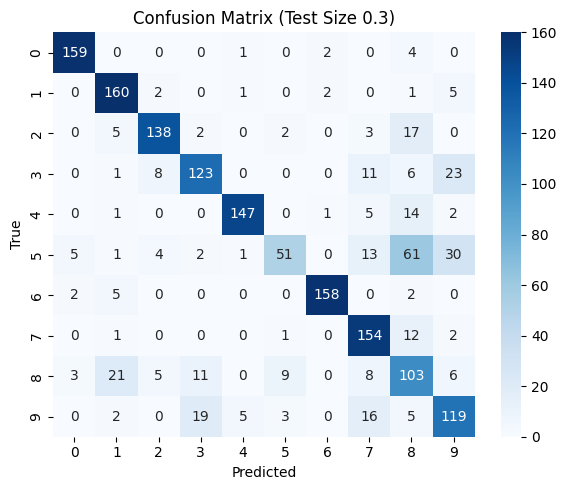

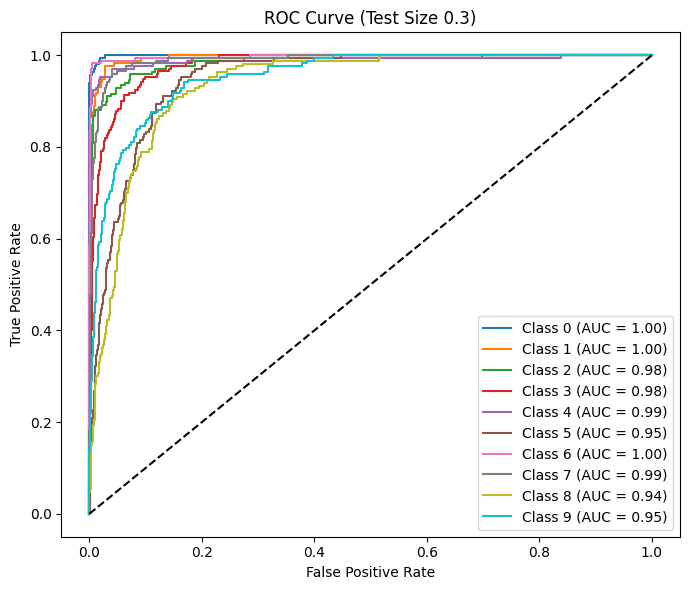


Running RandomForestClassifier with Test Size 0.4 and PCA n_components=5...
Accuracy: 0.7820284697508897
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       222
           1       0.83      0.92      0.87       228
           2       0.90      0.83      0.86       223
           3       0.79      0.75      0.77       229
           4       0.93      0.86      0.90       227
           5       0.77      0.30      0.43       223
           6       0.96      0.96      0.96       223
           7       0.74      0.89      0.81       226
           8       0.46      0.64      0.54       222
           9       0.64      0.71      0.67       225

    accuracy                           0.78      2248
   macro avg       0.80      0.78      0.78      2248
weighted avg       0.80      0.78      0.78      2248



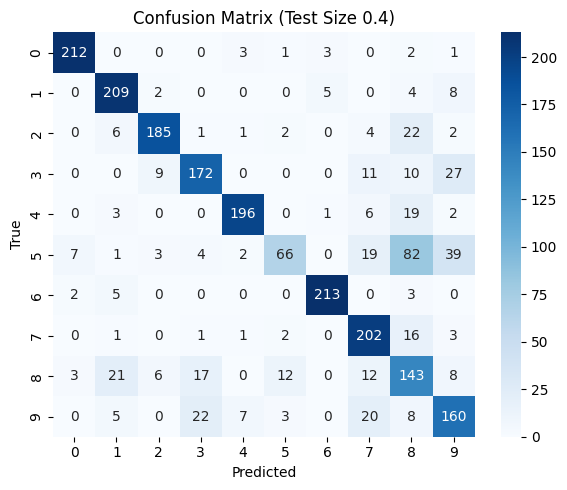

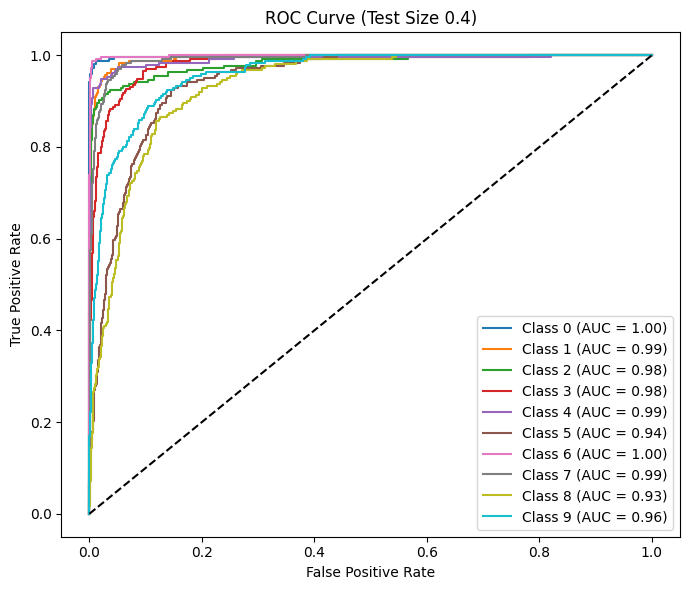


Running RandomForestClassifier with Test Size 0.5 and PCA n_components=5...
Accuracy: 0.7654804270462633
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       277
           1       0.80      0.92      0.86       286
           2       0.86      0.78      0.82       278
           3       0.78      0.73      0.75       286
           4       0.94      0.83      0.88       284
           5       0.72      0.23      0.34       279
           6       0.94      0.95      0.94       279
           7       0.76      0.87      0.81       283
           8       0.44      0.68      0.53       277
           9       0.65      0.72      0.68       281

    accuracy                           0.77      2810
   macro avg       0.78      0.77      0.76      2810
weighted avg       0.78      0.77      0.76      2810



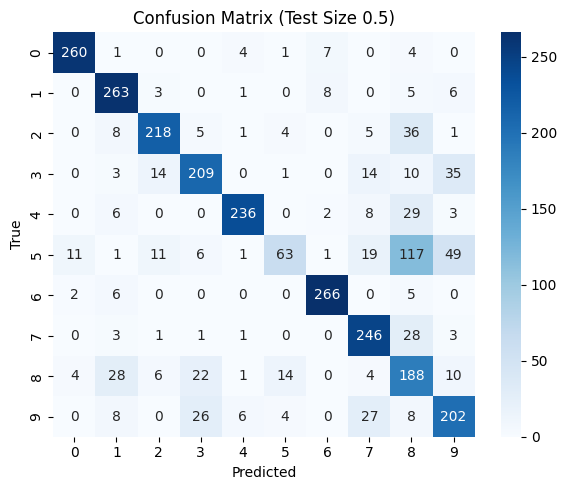

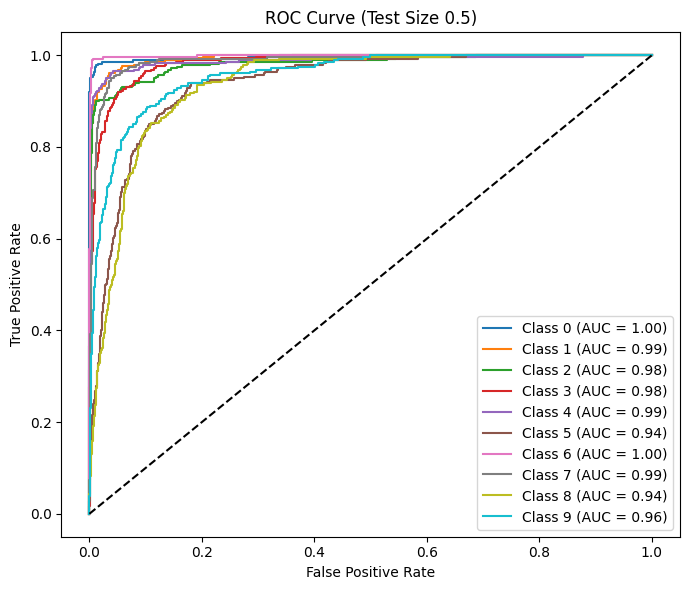


Plotting Accuracy Bar Graph Across All Test Sizes...


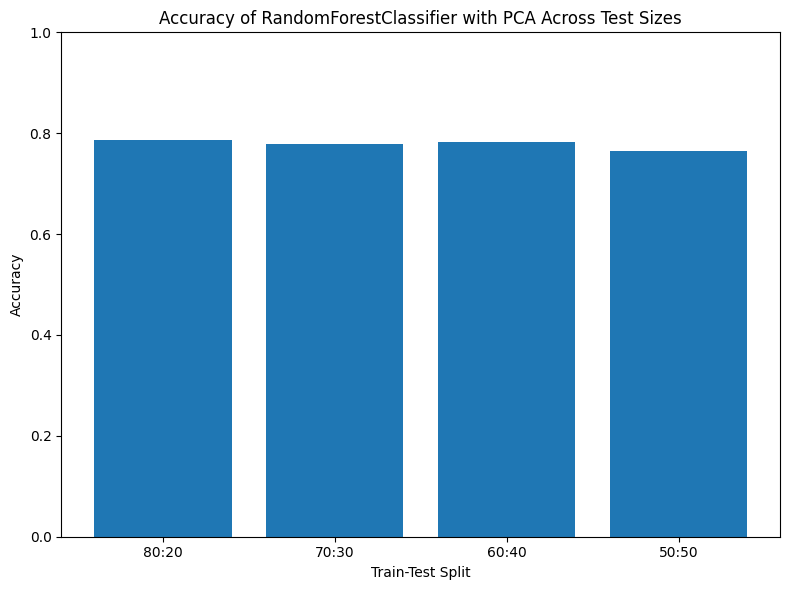

{0.2: {'accuracy': 0.7864768683274022,
  'confusion_matrix': array([[108,   0,   0,   0,   0,   0,   0,   0,   3,   0],
         [  0, 106,   1,   0,   0,   0,   2,   0,   0,   5],
         [  0,   3,  95,   0,   0,   1,   0,   1,  11,   0],
         [  0,   1,   7,  85,   0,   0,   0,   4,   4,  13],
         [  0,   2,   0,   0, 100,   0,   1,   3,   8,   0],
         [  3,   1,   3,   2,   0,  31,   0,   8,  44,  20],
         [  1,   2,   0,   0,   0,   0, 104,   0,   5,   0],
         [  0,   1,   0,   0,   0,   1,   0, 103,   7,   1],
         [  2,  11,   3,  11,   0,   7,   0,   5,  71,   1],
         [  0,   2,   0,  12,   2,   3,   0,   7,   5,  81]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.95      0.97      0.96       111\n           1       0.82      0.93      0.87       114\n           2       0.87      0.86      0.86       111\n           3       0.77      0.75      0.76       114\n           4       0.98 

In [45]:
random_forest_classifier_with_pca(
    X=digit_features_scaled,
    Y=digit_targets,
    test_sizes=[0.2, 0.3, 0.4, 0.5],
    n_estimators=100,
    max_depth=5,
    random_state=2
)